# **ADA project**

* [Part I. Data Pre-Treatment](#PartI)    
    * [1) Pre-processing Data](#I.1)
        * [1.1) Import Data](#I.1.1)
        * [1.2) Are quotations unique?](#I.1.2)
        * [1.3) Punctuation Removal](#I.1.3)
        * [1.4) Tokenization](#I.1.4)
        * [1.5) Stop word removal](#I.1.5)
        * [1.6) Lemmatization](#I.1.6)
        * [1.7) Do we have only phase E quotations?](#I.1.7)
    * [2) Pre-analyzing Data](#2)
        * [2.1) Comparison before and after pre-processing](#I.2.1)
            * [2.1.1) Analysis about characters](#I.2.1.1)
            * [2.1.2) Analysis about words](#I.2.1.2)
        * [2.2) Selection of quotations AND comparison before and after selection](#I.2.2)
            * [2.2.1) Dropping quotations where the main speaker is "None"](#I.2.2.1)
            * [2.2.2) Dropping quotations with too weak speaker probability](#I.2.2.2)
            * [2.2.3) Dropping quotations which do not have a sufficient number of words](#I.2.3.3)
        * [2.3) Filter english text](#I.2.3)
        * [2.4) Final adjustments](#I.2.4)
* [Part II. Tools for our project about Trump](#PartII) 
    * [1) Data](#II.1)
    * [2) LDA function](#II.2)
    * [3) Sentiment analysis](#II.3)
        * [3.1) Flair](#II.3.1)
        * [3.2) VaderSentiment](#II.3.2)
    * [4) Additional data](#II.4)
* [Part III. Our project about Trump](#PartIII) 
    * [Question 1: What were Donald Trump’s favorite topics to talk about during the campaign (starting in 2015)? and his time in office (20/01/2017 - 20/01/2021)? Is there a change in Trump’s speech/favorite topics between before and after he was elected? Can we note different periods? Can we correlate changes in the ideas expressed by Trump with external events?](#III.1)
    * [Question 2: Can we quantify Trump popularity over time and correlate it with external events? Can we see the impact of his speech on the population (different groups of population?)?](#III.2)
        * [2.1) Trump popularity over time](#III.2.1)
            * [2.1.1) With Flair](#III.2.1.1)
            * [2.1.2) With Vader](#III.2.1.2)
            * [2.1.3) Comparison with approval ratings](#III.2.1.3)
        * [2.2) Trump popularity and population groups](#III.2.2)
            * [2.2.1) Processing of the speakers data](#III.2.2.1)     
            * [2.2.2) Analyzing sentiment according population](#III.2.2.2) 
    * [Question 3: In which newspapers are Trump's quotations published? Is there a link between the newspapers that published the most quotations of Trump and the political affiliation of these newspapers?](#III.3)
        * [3.1) In which newspaper are Trump's quotations published ?](#III.3.1)
        * [3.2) Is there a link between the newspapers that published the most quotations of Trump and the political affiliation of these newspapers?](III.3.2)

In [1]:
import string
import re
import math
import bz2
import json
import pickle
import numpy as np
import pandas as pd

# nlp/preprocessing
import nltk
from nltk.stem import WordNetLemmatizer
import langdetect

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from wordcloud import WordCloud
from scipy.interpolate import make_interp_spline

# topic extraction
import spacy
from empath import Empath
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# sentiment analysis
import flair
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2 # country to continent
import statsmodels.formula.api as smf # statistical test
from urllib.parse import urlparse

C:\Users\felic\anaconda3\envs\ada\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# Part I. Data Pre-Treatment <a class="anchor" id="PartI"></a>

## 1) Pre-processing Data  <a class="anchor" id="I.1"></a>

### 1.1) Import Data  <a class="anchor" id="I.1.1"></a>

To avoid having to download and import all the data in this Jupyter Notebook, we opened all the data on Google Colab from Google Drive (cf. Mounting Google Drive) and we retrieved only the data that interested us for our project. We end up with two bz2 files: a file where Trump is the speaker and a file where the word "trump" appears in the quotation. The code used on Google Colab is the following:

```
import bz2
import json

input_files = [f'/content/drive/MyDrive/Quotebank/quotes-20{i}.json.bz2' for i in range(15, 21)]
file_about_trump = '/content/quotes-about-trump.json.bz2'
file_from_trump = '/content/quotes-from-trump.json.bz2'

for input_file in input_files:
    with bz2.open(input_file, 'rb') as s_file:
        about_file = bz2.open(file_about_trump, 'ab')
        from_file = bz2.open(file_from_trump, 'wb')
        for instance in s_file:
            instance = json.loads(instance) # loading a sample
            trump_speaking = instance['speaker'].lower().__contains__('trump')
            about_trump = instance['quotation'].lower().__contains__('trump')
            if trump_speaking:
                from_file.write((json.dumps(instance)+'\n').encode('utf-8'))
            elif about_trump:
                about_file.write((json.dumps(instance)+'\n').encode('utf-8'))
        about_file.close()
        from_file.close()

```

We open the first file where Trump is the speaker:

In [6]:
data = []
with bz2.open('data/quotes-from-trump.json.bz2', "rt") as data_file :
    for line in data_file :
        try :
            lignedata = json.loads(line)
            data.append(lignedata)
        except:
            continue

df_from = pd.DataFrame()

df_from["quoteID"] = list(map(lambda d : d["quoteID"], data))
df_from["quotation"] = list(map(lambda d : d["quotation"], data))
df_from["speaker"] = list(map(lambda d : d["speaker"], data))
df_from["qids"] = list(map(lambda d : d["qids"], data))
df_from["date"] = list(map(lambda d : d["date"], data))
df_from["numOccurrences"] = list(map(lambda d : d["numOccurrences"], data))
df_from["probas"] = list(map(lambda d : d["probas"], data))
df_from["urls"] = list(map(lambda d : d["urls"], data))
df_from["phase"] = list(map(lambda d : d["phase"], data))

df_from.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2015-07-17-029255,I am incredibly pleased that my message is res...,Donald Trump,"[Q22686, Q27947481]",2015-07-17 10:28:58,2,"[[Donald Trump, 0.8415], [None, 0.1356], [Rand...",[http://washingtontimes.com/news/2015/jul/17/d...,E
1,2015-12-10-038891,I don't want this person representing either t...,Donald Trump,"[Q22686, Q27947481]",2015-12-10 16:20:00,1,"[[Donald Trump, 0.509], [None, 0.491]]",[http://www.westernmorningnews.co.uk/Petition-...,E
2,2015-11-14-003251,And I will tell you what -- you can say what y...,Donald Trump,"[Q22686, Q27947481]",2015-11-14 22:45:14,6,"[[Donald Trump, 0.798], [None, 0.202]]",[http://news.yahoo.com/paris-wouldve-different...,E
3,2015-10-07-007656,angry at our leaders for not knowing what's ha...,Donald Trump,"[Q22686, Q27947481]",2015-10-07 19:18:48,1,"[[Donald Trump, 0.9064], [None, 0.0936]]",[http://www.radioiowa.com/2015/10/07/trump-rap...,E
4,2015-09-20-019882,I never called Jeb Bush and I never asked him ...,Donald Trump,"[Q22686, Q27947481]",2015-09-20 14:01:28,2,"[[Donald Trump, 0.5131], [None, 0.459], [Jeb B...",[http://tpmdc.talkingpointsmemo.com/livewire/d...,E


In [7]:
# Checking that the speaker is correct
print(df_from.speaker.unique())

['Donald Trump' 'DONALD Trump' 'DONALD TRUMP' 'President Donald Trump'
 'Donald J. Trump' 'Ivanka Trump' 'Andreas Trumpp' 'President Trump'
 'donald trump' 'Ivana Trump' 'Donald Trump Jr. .' 'Donnie Trumpet'
 'Melania Trump' 'Joan Trumpauer Mulholland' 'Judd Trump' 'Eric Trump'
 'Donald John Trump' 'Melania Knauss-Trump' 'president Trump'
 'Melania trump' 'PRESIDENT TRUMP' 'Donald trump' 'JUDD TRUMP'
 'Barron Trump' 'Tiffany Trump' 'Donald Trump , Jr. .'
 'president Donald Trump' 'Maryanne Trump Barry' 'Lara Trump'
 'President Donald J. Trump' 'Lara trump' 'Bob Trumpy' 'William Trump'
 'Trumpet Black' 'Donald Trump Jr' 'Baroness Trumpington'
 'Elizabeth Trump' 'MELANIA TRUMP' 'Donald J Trump' 'Blaine Trump'
 'Simon Trumper' 'Donald L. Trump' 'DOnald Trump' 'Vanessa Trump'
 'Timmy Trumpet' 'Jean Barker , Baroness Trumpington' 'DONALD J. TRUMP'
 'Tiffany Ariana Trump' 'ivanka trump' 'President Donald John Trump'
 'melania trump' 'IVANKA TRUMP' 'Donald J. Trump Jr. .'
 'president Donald J

We see that actually some speakers are not Donald Trump but other people named Trump, so below we select the correct speakers.

In [8]:
# Fixing the speaker so that we only have quotes spoken by Donald Trump
num_quotes_before = len(df_from)
df_from = df_from[df_from.speaker.str.lower().isin(["donald trump", "president donald trump", "president trump", "donald j. trump", "president donald j. trump", "donald j trump", "donald john trump", "president donald john trump"])]
num_quotes_after = len(df_from)

print(f"Removed {round((num_quotes_before-num_quotes_after)/num_quotes_before*100, 1)}% of quotes")

Removed 7.1% of quotes


Secondly, we open the second file where the quotation is about Trump:

We made the choice to select the quotes about Trump in a quite general way (contains 'trump') so as not to lose too many quotes. We are aware that some of those quotes will not actually be about Donald Trump but we expect that those will not influence the results much.

In [9]:
data = []
with bz2.open('data/quotes-about-trump.json.bz2', "rt") as data_file :
    for line in data_file :
        try :
            lignedata = json.loads(line)
            data.append(lignedata)
        except:
            continue

df_about = pd.DataFrame()

df_about["quoteID"] = list(map(lambda d : d["quoteID"], data))
df_about["quotation"] = list(map(lambda d : d["quotation"], data))
df_about["speaker"] = list(map(lambda d : d["speaker"], data))
df_about["qids"] = list(map(lambda d : d["qids"], data))
df_about["date"] = list(map(lambda d : d["date"], data))
df_about["numOccurrences"] = list(map(lambda d : d["numOccurrences"], data))
df_about["probas"] = list(map(lambda d : d["probas"], data))
df_about["urls"] = list(map(lambda d : d["urls"], data))
df_about["phase"] = list(map(lambda d : d["phase"], data))

df_about.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2015-06-18-018819,How long do you think it'll take for Donald Tr...,Chris Matthews,"[Q15735939, Q25189328, Q5107375, Q5110828, Q51...",2015-06-18 10:00:00,1,"[[Chris Matthews, 0.3869], [None, 0.3198], [Do...",[http://talkingpointsmemo.com/dc/donald-trump-...,E
1,2015-09-16-006359,And I'm just pointing out the absurd on both s...,Kathleen Madigan,[Q6376814],2015-09-16 05:44:37,1,"[[Kathleen Madigan, 0.8025], [None, 0.1975]]",[http://northjersey.com/arts-and-entertainment...,E
2,2015-05-11-003168,"And you had Michael Jackson roller skating, an...",Jim McMahon,"[Q1689159, Q17306267, Q6196886]",2015-05-11 02:03:27,1,"[[Jim McMahon, 0.8731], [None, 0.1232], [Linda...",[http://www.seattletimes.com/seattle-news/bell...,E
3,2015-10-20-044420,I like that he's not spinning things. He seems...,None,[],2015-10-20 23:46:58,1,"[[None, 0.7832], [Ben Carson, 0.0755], [Bobby ...",[http://detroitnews.com/story/news/politics/20...,E
4,2015-12-22-031341,"I promise, I won't talk about Trump again,",Jeb Bush,[Q221997],2015-12-22 20:43:59,10,"[[Jeb Bush, 0.7816], [None, 0.1677], [Donald T...",[http://www.politico.com/story/2015/12/jeb-bus...,E


Finally we combine the two dataframes in a single one:

In [10]:
# Concatenate the two DataFrame in a single one for pre-processing
df = pd.concat([df_about, df_from], axis=0)

df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2015-06-18-018819,How long do you think it'll take for Donald Tr...,Chris Matthews,"[Q15735939, Q25189328, Q5107375, Q5110828, Q51...",2015-06-18 10:00:00,1,"[[Chris Matthews, 0.3869], [None, 0.3198], [Do...",[http://talkingpointsmemo.com/dc/donald-trump-...,E
1,2015-09-16-006359,And I'm just pointing out the absurd on both s...,Kathleen Madigan,[Q6376814],2015-09-16 05:44:37,1,"[[Kathleen Madigan, 0.8025], [None, 0.1975]]",[http://northjersey.com/arts-and-entertainment...,E
2,2015-05-11-003168,"And you had Michael Jackson roller skating, an...",Jim McMahon,"[Q1689159, Q17306267, Q6196886]",2015-05-11 02:03:27,1,"[[Jim McMahon, 0.8731], [None, 0.1232], [Linda...",[http://www.seattletimes.com/seattle-news/bell...,E
3,2015-10-20-044420,I like that he's not spinning things. He seems...,None,[],2015-10-20 23:46:58,1,"[[None, 0.7832], [Ben Carson, 0.0755], [Bobby ...",[http://detroitnews.com/story/news/politics/20...,E
4,2015-12-22-031341,"I promise, I won't talk about Trump again,",Jeb Bush,[Q221997],2015-12-22 20:43:59,10,"[[Jeb Bush, 0.7816], [None, 0.1677], [Donald T...",[http://www.politico.com/story/2015/12/jeb-bus...,E


### 1.2) Are quotations unique?  <a class="anchor" id="I.1.2"></a>

In [11]:
print(f"Are quotations unique? {df.quotation.is_unique}")

Are quotations unique? True


### 1.3) Punctuation Removal  <a class="anchor" id="I.1.3"></a>

Removing punctuation because it doesn't add semantic meaning

In [12]:
def remove_punctuation(text):
    punctuationfree = "".join([i for i in text if i not in string.punctuation])
    return punctuationfree

df['quote_punctfree']= df['quotation'].apply(lambda x: remove_punctuation(x))

df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,quote_punctfree
0,2015-06-18-018819,How long do you think it'll take for Donald Tr...,Chris Matthews,"[Q15735939, Q25189328, Q5107375, Q5110828, Q51...",2015-06-18 10:00:00,1,"[[Chris Matthews, 0.3869], [None, 0.3198], [Do...",[http://talkingpointsmemo.com/dc/donald-trump-...,E,How long do you think itll take for Donald Tru...
1,2015-09-16-006359,And I'm just pointing out the absurd on both s...,Kathleen Madigan,[Q6376814],2015-09-16 05:44:37,1,"[[Kathleen Madigan, 0.8025], [None, 0.1975]]",[http://northjersey.com/arts-and-entertainment...,E,And Im just pointing out the absurd on both si...
2,2015-05-11-003168,"And you had Michael Jackson roller skating, an...",Jim McMahon,"[Q1689159, Q17306267, Q6196886]",2015-05-11 02:03:27,1,"[[Jim McMahon, 0.8731], [None, 0.1232], [Linda...",[http://www.seattletimes.com/seattle-news/bell...,E,And you had Michael Jackson roller skating and...
3,2015-10-20-044420,I like that he's not spinning things. He seems...,None,[],2015-10-20 23:46:58,1,"[[None, 0.7832], [Ben Carson, 0.0755], [Bobby ...",[http://detroitnews.com/story/news/politics/20...,E,I like that hes not spinning things He seems g...
4,2015-12-22-031341,"I promise, I won't talk about Trump again,",Jeb Bush,[Q221997],2015-12-22 20:43:59,10,"[[Jeb Bush, 0.7816], [None, 0.1677], [Donald T...",[http://www.politico.com/story/2015/12/jeb-bus...,E,I promise I wont talk about Trump again


### 1.4) Tokenization  <a class="anchor" id="I.1.4"></a>

In [13]:
def tokenization(text):
    tokens = re.split('\W+',text)
    return tokens

df['quote_punctfree_token']= df['quote_punctfree'].apply(lambda x: tokenization(x))

df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,quote_punctfree,quote_punctfree_token
0,2015-06-18-018819,How long do you think it'll take for Donald Tr...,Chris Matthews,"[Q15735939, Q25189328, Q5107375, Q5110828, Q51...",2015-06-18 10:00:00,1,"[[Chris Matthews, 0.3869], [None, 0.3198], [Do...",[http://talkingpointsmemo.com/dc/donald-trump-...,E,How long do you think itll take for Donald Tru...,"[How, long, do, you, think, itll, take, for, D..."
1,2015-09-16-006359,And I'm just pointing out the absurd on both s...,Kathleen Madigan,[Q6376814],2015-09-16 05:44:37,1,"[[Kathleen Madigan, 0.8025], [None, 0.1975]]",[http://northjersey.com/arts-and-entertainment...,E,And Im just pointing out the absurd on both si...,"[And, Im, just, pointing, out, the, absurd, on..."
2,2015-05-11-003168,"And you had Michael Jackson roller skating, an...",Jim McMahon,"[Q1689159, Q17306267, Q6196886]",2015-05-11 02:03:27,1,"[[Jim McMahon, 0.8731], [None, 0.1232], [Linda...",[http://www.seattletimes.com/seattle-news/bell...,E,And you had Michael Jackson roller skating and...,"[And, you, had, Michael, Jackson, roller, skat..."
3,2015-10-20-044420,I like that he's not spinning things. He seems...,None,[],2015-10-20 23:46:58,1,"[[None, 0.7832], [Ben Carson, 0.0755], [Bobby ...",[http://detroitnews.com/story/news/politics/20...,E,I like that hes not spinning things He seems g...,"[I, like, that, hes, not, spinning, things, He..."
4,2015-12-22-031341,"I promise, I won't talk about Trump again,",Jeb Bush,[Q221997],2015-12-22 20:43:59,10,"[[Jeb Bush, 0.7816], [None, 0.1677], [Donald T...",[http://www.politico.com/story/2015/12/jeb-bus...,E,I promise I wont talk about Trump again,"[I, promise, I, wont, talk, about, Trump, again]"


### 1.5) Stop word removal  <a class="anchor" id="I.1.6"></a>

We chose to use as stopwords words in the english language which don't add much semantic meaning. 

In [14]:
# Stop words present in the library
nltk.download('stopwords')
stopwords = [s.replace("'", "") for s in nltk.corpus.stopwords.words('english')] # removing apostrophes from stopwords
print(stopwords) # checking that we don't remove useful words

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'youre', 'youve', 'youll', 'youd', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'shes', 'her', 'hers', 'herself', 'it', 'its', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'thatll', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\felic\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
def remove_stopwords(text):
    output = [i for i in text if i not in stopwords]
    return output

df['quote_punctfree_token_NoStopWord'] = df['quote_punctfree_token'].apply(lambda x: remove_stopwords(x))

df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,quote_punctfree,quote_punctfree_token,quote_punctfree_token_NoStopWord
0,2015-06-18-018819,How long do you think it'll take for Donald Tr...,Chris Matthews,"[Q15735939, Q25189328, Q5107375, Q5110828, Q51...",2015-06-18 10:00:00,1,"[[Chris Matthews, 0.3869], [None, 0.3198], [Do...",[http://talkingpointsmemo.com/dc/donald-trump-...,E,How long do you think itll take for Donald Tru...,"[How, long, do, you, think, itll, take, for, D...","[How, long, think, itll, take, Donald, Trump, ..."
1,2015-09-16-006359,And I'm just pointing out the absurd on both s...,Kathleen Madigan,[Q6376814],2015-09-16 05:44:37,1,"[[Kathleen Madigan, 0.8025], [None, 0.1975]]",[http://northjersey.com/arts-and-entertainment...,E,And Im just pointing out the absurd on both si...,"[And, Im, just, pointing, out, the, absurd, on...","[And, Im, pointing, absurd, sides, Im, sidetak..."
2,2015-05-11-003168,"And you had Michael Jackson roller skating, an...",Jim McMahon,"[Q1689159, Q17306267, Q6196886]",2015-05-11 02:03:27,1,"[[Jim McMahon, 0.8731], [None, 0.1232], [Linda...",[http://www.seattletimes.com/seattle-news/bell...,E,And you had Michael Jackson roller skating and...,"[And, you, had, Michael, Jackson, roller, skat...","[And, Michael, Jackson, roller, skating, Donal..."
3,2015-10-20-044420,I like that he's not spinning things. He seems...,None,[],2015-10-20 23:46:58,1,"[[None, 0.7832], [Ben Carson, 0.0755], [Bobby ...",[http://detroitnews.com/story/news/politics/20...,E,I like that hes not spinning things He seems g...,"[I, like, that, hes, not, spinning, things, He...","[I, like, hes, spinning, things, He, seems, ge..."
4,2015-12-22-031341,"I promise, I won't talk about Trump again,",Jeb Bush,[Q221997],2015-12-22 20:43:59,10,"[[Jeb Bush, 0.7816], [None, 0.1677], [Donald T...",[http://www.politico.com/story/2015/12/jeb-bus...,E,I promise I wont talk about Trump again,"[I, promise, I, wont, talk, about, Trump, again]","[I, promise, I, talk, Trump]"


We also made a function to find the words which occur in the most quotes. We do not use it yet, but if the topics are not being extracted well then we can use this to remove the most frequent words as well.

In [10]:
# Function for getting the frequency of quotes in which words appear
def get_doc_frequency(data):
    joined_data = " ".join(data)
    words = {w: set() for w in set(joined_data.split())}
    for i, vote in enumerate(data):
        for w in vote.split():
            if w in words:
                words[w].add(i)
    
    data_len = len([d for d in data if d != ''])
    words = sorted({w: len(words[w])/data_len for w in words}.items(), key=lambda x: -x[1])
    return words

In [17]:
get_doc_frequency([" ".join(q) for q in list(df['quote_punctfree_token_NoStopWord'])])[:20] # most frequent words

[('Trump', 0.47321455127734313),
 ('I', 0.21698171044461023),
 ('Donald', 0.131514110048117),
 ('President', 0.11906815592405928),
 ('The', 0.10000345990726235),
 ('people', 0.0901014481229396),
 ('Trumps', 0.08879457437981163),
 ('going', 0.06862270803906417),
 ('think', 0.06519132983660132),
 ('would', 0.06492667728109561),
 ('We', 0.06323799973656145),
 ('like', 0.05986974966660455),
 ('And', 0.05096443397434691),
 ('know', 0.04912097110491835),
 ('one', 0.04672453007478863),
 ('get', 0.04294776814736534),
 ('country', 0.04182967180048111),
 ('president', 0.04079655563197027),
 ('said', 0.04059442420769641),
 ('want', 0.04015252728015476)]

### 1.6) Lemmatization  <a class="anchor" id="I.1.7"></a>

We are not sure if this will improve our results so we will try with and without and see which works best.

In [18]:
nltk.download('wordnet')
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatizer(text):
    lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
    return lemm_text

df['quote_punctfree_token_NoStopWord_lemm'] = df['quote_punctfree_token_NoStopWord'].apply(lambda x: lemmatizer(x))
df['final_quote'] = df['quote_punctfree_token_NoStopWord_lemm']

df.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\felic\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,quote_punctfree,quote_punctfree_token,quote_punctfree_token_NoStopWord,quote_punctfree_token_NoStopWord_lemm,final_quote
0,2015-06-18-018819,How long do you think it'll take for Donald Tr...,Chris Matthews,"[Q15735939, Q25189328, Q5107375, Q5110828, Q51...",2015-06-18 10:00:00,1,"[[Chris Matthews, 0.3869], [None, 0.3198], [Do...",[http://talkingpointsmemo.com/dc/donald-trump-...,E,How long do you think itll take for Donald Tru...,"[How, long, do, you, think, itll, take, for, D...","[How, long, think, itll, take, Donald, Trump, ...","[How, long, think, itll, take, Donald, Trump, ...","[How, long, think, itll, take, Donald, Trump, ..."
1,2015-09-16-006359,And I'm just pointing out the absurd on both s...,Kathleen Madigan,[Q6376814],2015-09-16 05:44:37,1,"[[Kathleen Madigan, 0.8025], [None, 0.1975]]",[http://northjersey.com/arts-and-entertainment...,E,And Im just pointing out the absurd on both si...,"[And, Im, just, pointing, out, the, absurd, on...","[And, Im, pointing, absurd, sides, Im, sidetak...","[And, Im, pointing, absurd, side, Im, sidetaki...","[And, Im, pointing, absurd, side, Im, sidetaki..."
2,2015-05-11-003168,"And you had Michael Jackson roller skating, an...",Jim McMahon,"[Q1689159, Q17306267, Q6196886]",2015-05-11 02:03:27,1,"[[Jim McMahon, 0.8731], [None, 0.1232], [Linda...",[http://www.seattletimes.com/seattle-news/bell...,E,And you had Michael Jackson roller skating and...,"[And, you, had, Michael, Jackson, roller, skat...","[And, Michael, Jackson, roller, skating, Donal...","[And, Michael, Jackson, roller, skating, Donal...","[And, Michael, Jackson, roller, skating, Donal..."
3,2015-10-20-044420,I like that he's not spinning things. He seems...,None,[],2015-10-20 23:46:58,1,"[[None, 0.7832], [Ben Carson, 0.0755], [Bobby ...",[http://detroitnews.com/story/news/politics/20...,E,I like that hes not spinning things He seems g...,"[I, like, that, hes, not, spinning, things, He...","[I, like, hes, spinning, things, He, seems, ge...","[I, like, he, spinning, thing, He, seems, genu...","[I, like, he, spinning, thing, He, seems, genu..."
4,2015-12-22-031341,"I promise, I won't talk about Trump again,",Jeb Bush,[Q221997],2015-12-22 20:43:59,10,"[[Jeb Bush, 0.7816], [None, 0.1677], [Donald T...",[http://www.politico.com/story/2015/12/jeb-bus...,E,I promise I wont talk about Trump again,"[I, promise, I, wont, talk, about, Trump, again]","[I, promise, I, talk, Trump]","[I, promise, I, talk, Trump]","[I, promise, I, talk, Trump]"


### 1.8) Do we have only phase E quotations?  <a class="anchor" id="1.8"></a>

Phase E is good because it is more precise than the other phases.

In [19]:
df.groupby(df.phase).agg('count')

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,quote_punctfree,quote_punctfree_token,quote_punctfree_token_NoStopWord,quote_punctfree_token_NoStopWord_lemm,final_quote
phase,,,,,,,,,,,,,
E,1647515,1647515,1647515,1647515,1647515,1647515,1647515,1647515,1647515,1647515,1647515,1647515,1647515


## 2) Pre-analyzing Data  <a class="anchor" id="I.2"></a>

### 2.1) Comparison before and after pre-processing  <a class="anchor" id="I.2.1"></a>

#### 2.1.1) Analysis about characters  <a class="anchor" id="I.2.1.1"></a>

In [20]:
# Creation of a new table for the analysis
analyze = df.loc[:, ['quoteID', 'quotation', 'final_quote']].copy(deep=True)

In [21]:
# Creation of a new column with the number of characters per citation (spaces included)
analyze["ch_quote"] = analyze["quotation"].apply(lambda x: len(x))

analyze.head()

,quoteID,quotation,final_quote,ch_quote
0,2015-06-18-018819,How long do you think it'll take for Donald Tr...,"[How, long, think, itll, take, Donald, Trump, ...",113
1,2015-09-16-006359,And I'm just pointing out the absurd on both s...,"[And, Im, pointing, absurd, side, Im, sidetaki...",407
2,2015-05-11-003168,"And you had Michael Jackson roller skating, an...","[And, Michael, Jackson, roller, skating, Donal...",61
3,2015-10-20-044420,I like that he's not spinning things. He seems...,"[I, like, he, spinning, thing, He, seems, genu...",148
4,2015-12-22-031341,"I promise, I won't talk about Trump again,","[I, promise, I, talk, Trump]",42


In [22]:
# Creation of a new column with the number of characters of the final quote without tokenization
analyze["ch_final_quote"] = (df["final_quote"].apply(lambda x: ' '.join(x))).apply(lambda x: len(x))

analyze.head()

,quoteID,quotation,final_quote,ch_quote,ch_final_quote
0,2015-06-18-018819,How long do you think it'll take for Donald Tr...,"[How, long, think, itll, take, Donald, Trump, ...",113,77
1,2015-09-16-006359,And I'm just pointing out the absurd on both s...,"[And, Im, pointing, absurd, side, Im, sidetaki...",407,291
2,2015-05-11-003168,"And you had Michael Jackson roller skating, an...","[And, Michael, Jackson, roller, skating, Donal...",61,47
3,2015-10-20-044420,I like that he's not spinning things. He seems...,"[I, like, he, spinning, thing, He, seems, genu...",148,89
4,2015-12-22-031341,"I promise, I won't talk about Trump again,","[I, promise, I, talk, Trump]",42,22


In [23]:
# Creation of a new column with the percentage of characters removed after pre-processing
analyze["ch_removed"] = (analyze["ch_quote"]-analyze["ch_final_quote"])*100/analyze["ch_quote"]

analyze.head()

,quoteID,quotation,final_quote,ch_quote,ch_final_quote,ch_removed
0,2015-06-18-018819,How long do you think it'll take for Donald Tr...,"[How, long, think, itll, take, Donald, Trump, ...",113,77,31.858407
1,2015-09-16-006359,And I'm just pointing out the absurd on both s...,"[And, Im, pointing, absurd, side, Im, sidetaki...",407,291,28.501229
2,2015-05-11-003168,"And you had Michael Jackson roller skating, an...","[And, Michael, Jackson, roller, skating, Donal...",61,47,22.950820
3,2015-10-20-044420,I like that he's not spinning things. He seems...,"[I, like, he, spinning, thing, He, seems, genu...",148,89,39.864865
4,2015-12-22-031341,"I promise, I won't talk about Trump again,","[I, promise, I, talk, Trump]",42,22,47.619048


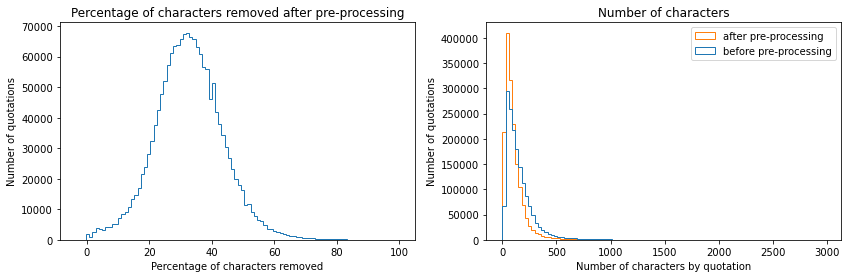

In [24]:
# Plot the distribution of the number of characters by quotation before pre-processing data and after pre-processing data
# And plot of the distribution of the percentage of characters removed after pre-processing

fig, ax = plt.subplots(1,2,figsize=(14,4))

ax[0].hist(analyze.ch_removed, bins=100, histtype='step')
ax[0].set_title('Percentage of characters removed after pre-processing')
ax[0].set_xlabel('Percentage of characters removed')
ax[0].set_ylabel('Number of quotations')

ax[1].hist([analyze.ch_quote, analyze.ch_final_quote], bins=100, histtype='step', label=['before pre-processing', 'after pre-processing'])
ax[1].set_title('Number of characters')
ax[1].set_xlabel('Number of characters by quotation')
ax[1].set_ylabel('Number of quotations')

plt.legend()
plt.show()

In [25]:
# Describe the column about the percentage of characters removed
analyze.ch_removed.describe()

count    1.647515e+06
mean     3.265374e+01
std      1.090174e+01
min     -3.448276e+00
25%      2.571429e+01
50%      3.239437e+01
75%      3.935018e+01
max      1.000000e+02
Name: ch_removed, dtype: float64

The percentage of characters removed after pre-processing seems to follow a Gaussian law centered on 33 percents. This is confirmed by the description of the column, as the median is 32%. It means that we removed around one third of the quotation characters. The standard deviation is quite low (11%), meaning that the percentage of characters removed is quite similar accross all the column.

The distribution of the character number per citation seems to follow an heavy-tailed distribution. This could be useful to confirm that for the rest of the analysis, so let's use a logarithmic scale.

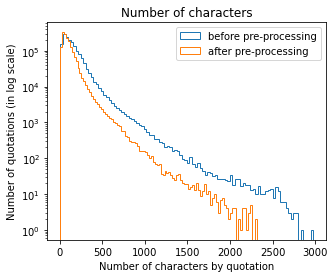

In [26]:
# Same but with log scale for the x-axis
plt.figure(figsize=(5,4))
array0 = plt.hist(analyze.ch_quote, bins=100, log=True, histtype='step')
array1 = plt.hist(analyze.ch_final_quote, bins=100, log=True, histtype='step')
plt.xlabel('Number of characters by quotation')
plt.ylabel('Number of quotations (in log scale)')
plt.title('Number of characters')
plt.legend(['before pre-processing', 'after pre-processing'])
plt.show()

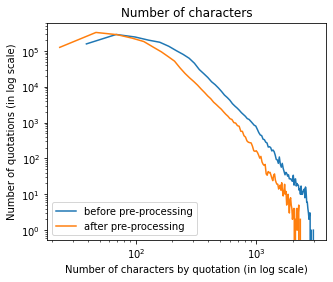

In [27]:
# Same but with log scale for the x-axis and the y-axis
plt.figure(figsize=(5,4))
plt.loglog(array0[1][1:],array0[0])
plt.loglog(array1[1][1:],array1[0])
plt.xlabel('Number of characters by quotation (in log scale)')
plt.ylabel('Number of quotations (in log scale)')
plt.title('Number of characters')
plt.legend(['before pre-processing', 'after pre-processing'])
plt.show()

The log-log axis confirms that distributions follow power laws.

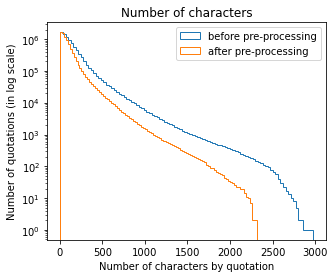

In [28]:
# Same but with log scale for the y-axis and cumulative
plt.figure(figsize=(5,4))
array_cumulative0 = plt.hist(analyze.ch_quote, bins=100, log=True, histtype='step', cumulative=-1)
array_cumulative1 = plt.hist(analyze.ch_final_quote, bins=100, log=True, histtype='step', cumulative=-1)
plt.xlabel('Number of characters by quotation')
plt.ylabel('Number of quotations (in log scale)')
plt.title('Number of characters')
plt.legend(['before pre-processing', 'after pre-processing'])
plt.show()

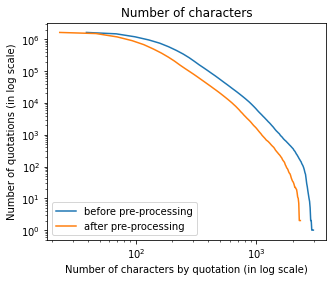

In [29]:
# Same but with log scale for the x-axis and the y-axis and cumulative
plt.figure(figsize=(5,4))
plt.loglog(array_cumulative0[1][1:],array_cumulative0[0])
plt.loglog(array_cumulative1[1][1:],array_cumulative1[0])
plt.xlabel('Number of characters by quotation (in log scale)')
plt.ylabel('Number of quotations (in log scale)')
plt.title('Number of characters')
plt.legend(['before pre-processing', 'after pre-processing'])
plt.show()

The shift between the two curves confirms that we successfully removed characters between data before processing and data after processing. Some quotations have a very large number of characters (more than 2,000). These outliers will be keept has they can bring robustness to our analysis. However, the quotations with 0 characters will be removed later as they do not provide anything to our analysis.

#### 2.1.2) Analysis about words  <a class="anchor" id="I.2.1.2"></a>

In [30]:
# Creation of a two columns with the number of words per citation before and after NoStopWord (cf. pre-processing)
analyze["wd_quote"] = df["quote_punctfree_token"].apply(lambda x: len(x))
analyze["wd_final_quote"] = df["final_quote"].apply(lambda x: len(x))

analyze.head()

,quoteID,quotation,final_quote,ch_quote,ch_final_quote,ch_removed,wd_quote,wd_final_quote
0,2015-06-18-018819,How long do you think it'll take for Donald Tr...,"[How, long, think, itll, take, Donald, Trump, ...",113,77,31.858407,22,13
1,2015-09-16-006359,And I'm just pointing out the absurd on both s...,"[And, Im, pointing, absurd, side, Im, sidetaki...",407,291,28.501229,73,52
2,2015-05-11-003168,"And you had Michael Jackson roller skating, an...","[And, Michael, Jackson, roller, skating, Donal...",61,47,22.950820,10,7
3,2015-10-20-044420,I like that he's not spinning things. He seems...,"[I, like, he, spinning, thing, He, seems, genu...",148,89,39.864865,29,17
4,2015-12-22-031341,"I promise, I won't talk about Trump again,","[I, promise, I, talk, Trump]",42,22,47.619048,8,5


In [31]:
# Creation of a new column with the percentage of words removed after pre-processing
analyze["wd_removed"] = (analyze["wd_quote"]-analyze["wd_final_quote"])*100/analyze["wd_quote"]

analyze.head()

,quoteID,quotation,final_quote,ch_quote,ch_final_quote,ch_removed,wd_quote,wd_final_quote,wd_removed
0,2015-06-18-018819,How long do you think it'll take for Donald Tr...,"[How, long, think, itll, take, Donald, Trump, ...",113,77,31.858407,22,13,40.909091
1,2015-09-16-006359,And I'm just pointing out the absurd on both s...,"[And, Im, pointing, absurd, side, Im, sidetaki...",407,291,28.501229,73,52,28.767123
2,2015-05-11-003168,"And you had Michael Jackson roller skating, an...","[And, Michael, Jackson, roller, skating, Donal...",61,47,22.950820,10,7,30.000000
3,2015-10-20-044420,I like that he's not spinning things. He seems...,"[I, like, he, spinning, thing, He, seems, genu...",148,89,39.864865,29,17,41.379310
4,2015-12-22-031341,"I promise, I won't talk about Trump again,","[I, promise, I, talk, Trump]",42,22,47.619048,8,5,37.500000


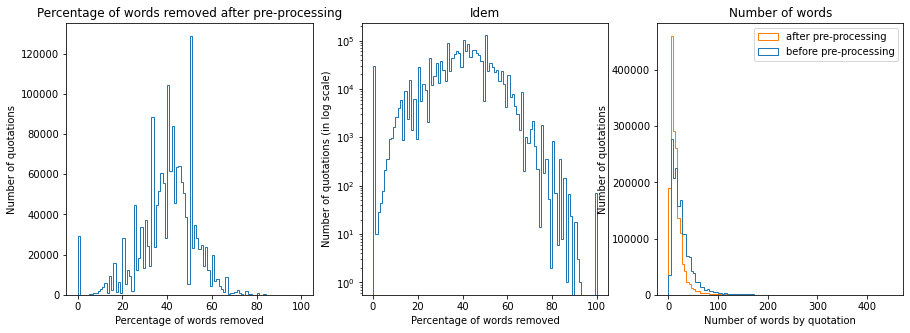

In [32]:
# Plot the distribution of the number of words by quotation before pre-processing data and after pre-processing data
# And plot of the distribution of the percentage of words removed after pre-processing

fig, ax = plt.subplots(1,3,figsize=(15,5))

ax[0].hist(analyze.wd_removed, bins=100, histtype='step')
ax[0].set_title('Percentage of words removed after pre-processing')
ax[0].set_xlabel('Percentage of words removed')
ax[0].set_ylabel('Number of quotations')

ax[1].hist(analyze.wd_removed, bins=100, log=True, histtype='step')
ax[1].set_title('Idem')
ax[1].set_xlabel('Percentage of words removed')
ax[1].set_ylabel('Number of quotations (in log scale)')

ax[2].hist([analyze.wd_quote, analyze.wd_final_quote], bins=100, histtype='step', label=['before pre-processing', 'after pre-processing'])
ax[2].set_title('Number of words')
ax[2].set_xlabel('Number of words by quotation')
ax[2].set_ylabel('Number of quotations')

plt.legend()
plt.show()

In [33]:
#Describe the column about the percentage of characters removed
analyze.wd_removed.describe()

count    1.647515e+06
mean     4.032738e+01
std      1.212191e+01
min      0.000000e+00
25%      3.333333e+01
50%      4.146341e+01
75%      4.821429e+01
max      1.000000e+02
Name: wd_removed, dtype: float64

Again, it seems that the number of words per quotations follow a heavy-tailed distribution, so we will check it later.
The words removed follow a Gaussion distribution centered on around 40%, which is confirmed by the median (41 % of the quotation words removed). The std (12%) shows that the dispersion is quite low.

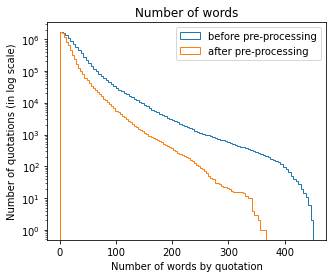

In [34]:
# Same but with log scale for the y-axis and cumulative
plt.figure(figsize=(5,4))
array_cumulative0 = plt.hist(analyze.wd_quote, bins=100, log=True, histtype='step', cumulative=-1)
array_cumulative1 = plt.hist(analyze.wd_final_quote, bins=100, log=True, histtype='step', cumulative=-1)
plt.xlabel('Number of words by quotation')
plt.ylabel('Number of quotations (in log scale)')
plt.title('Number of words')
plt.legend(['before pre-processing', 'after pre-processing'])
plt.show()

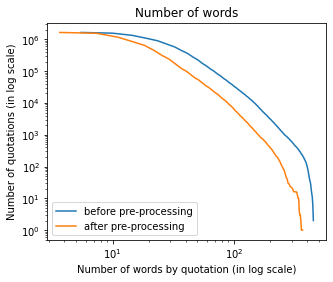

In [35]:
# Same but with log scale for the x-axis and the y-axis and cumulative
plt.figure(figsize=(5,4))
plt.loglog(array_cumulative0[1][1:],array_cumulative0[0])
plt.loglog(array_cumulative1[1][1:],array_cumulative1[0])
plt.xlabel('Number of words by quotation (in log scale)')
plt.ylabel('Number of quotations (in log scale)')
plt.title('Number of words')
plt.legend(['before pre-processing', 'after pre-processing'])
plt.show()

Once again, the shift between the two curves confirm that words were removed during the pre-processing.

### 2.2) Selection of quotations AND comparison before and after selection  <a class="anchor" id="I.2.2"></a>

In [36]:
# Creation of a new dataframe where we will select only interesting quotations
df_select = df.copy(deep=True)
df_select = df.drop(['quote_punctfree', 'quote_punctfree_token', 'quote_punctfree_token_NoStopWord', 'quote_punctfree_token_NoStopWord_lemm'], 1)
df_select.reset_index(inplace=True)
df_select.head()

C:\Users\felic\AppData\Local\Temp/ipykernel_23684/3449708622.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_select = df.drop(['quote_punctfree', 'quote_punctfree_token', 'quote_punctfree_token_NoStopWord', 'quote_punctfree_token_NoStopWord_lemm'], 1)


,index,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,final_quote
0,0,2015-06-18-018819,How long do you think it'll take for Donald Tr...,Chris Matthews,"[Q15735939, Q25189328, Q5107375, Q5110828, Q51...",2015-06-18 10:00:00,1,"[[Chris Matthews, 0.3869], [None, 0.3198], [Do...",[http://talkingpointsmemo.com/dc/donald-trump-...,E,"[How, long, think, itll, take, Donald, Trump, ..."
1,1,2015-09-16-006359,And I'm just pointing out the absurd on both s...,Kathleen Madigan,[Q6376814],2015-09-16 05:44:37,1,"[[Kathleen Madigan, 0.8025], [None, 0.1975]]",[http://northjersey.com/arts-and-entertainment...,E,"[And, Im, pointing, absurd, side, Im, sidetaki..."
2,2,2015-05-11-003168,"And you had Michael Jackson roller skating, an...",Jim McMahon,"[Q1689159, Q17306267, Q6196886]",2015-05-11 02:03:27,1,"[[Jim McMahon, 0.8731], [None, 0.1232], [Linda...",[http://www.seattletimes.com/seattle-news/bell...,E,"[And, Michael, Jackson, roller, skating, Donal..."
3,3,2015-10-20-044420,I like that he's not spinning things. He seems...,None,[],2015-10-20 23:46:58,1,"[[None, 0.7832], [Ben Carson, 0.0755], [Bobby ...",[http://detroitnews.com/story/news/politics/20...,E,"[I, like, he, spinning, thing, He, seems, genu..."
4,4,2015-12-22-031341,"I promise, I won't talk about Trump again,",Jeb Bush,[Q221997],2015-12-22 20:43:59,10,"[[Jeb Bush, 0.7816], [None, 0.1677], [Donald T...",[http://www.politico.com/story/2015/12/jeb-bus...,E,"[I, promise, I, talk, Trump]"


In [37]:
# Number of quotations before doing the selection
NbIni_quotes = len(df_select)
NbIni_quotes

1647515

In [38]:
# Checking that there is no NA for quotations and speakers
print("{} of NA quotations".format(df_select[df_select.quotation.isnull()].shape[0]))
print("{} of NA speakers".format(df_select[df_select.speaker.isnull()].shape[0]))

0 of NA quotations
0 of NA speakers


#### 2.2.1) Dropping quotations where the main speaker is "None"  <a class="anchor" id="I.2.2.1"></a>

In [39]:
# Dropping rows where the main speaker is "None"
indexNames = df_select[df_select['speaker']=='None'].index
df_select.drop(indexNames, inplace=True)
df_select.head()

,index,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,final_quote
0,0,2015-06-18-018819,How long do you think it'll take for Donald Tr...,Chris Matthews,"[Q15735939, Q25189328, Q5107375, Q5110828, Q51...",2015-06-18 10:00:00,1,"[[Chris Matthews, 0.3869], [None, 0.3198], [Do...",[http://talkingpointsmemo.com/dc/donald-trump-...,E,"[How, long, think, itll, take, Donald, Trump, ..."
1,1,2015-09-16-006359,And I'm just pointing out the absurd on both s...,Kathleen Madigan,[Q6376814],2015-09-16 05:44:37,1,"[[Kathleen Madigan, 0.8025], [None, 0.1975]]",[http://northjersey.com/arts-and-entertainment...,E,"[And, Im, pointing, absurd, side, Im, sidetaki..."
2,2,2015-05-11-003168,"And you had Michael Jackson roller skating, an...",Jim McMahon,"[Q1689159, Q17306267, Q6196886]",2015-05-11 02:03:27,1,"[[Jim McMahon, 0.8731], [None, 0.1232], [Linda...",[http://www.seattletimes.com/seattle-news/bell...,E,"[And, Michael, Jackson, roller, skating, Donal..."
4,4,2015-12-22-031341,"I promise, I won't talk about Trump again,",Jeb Bush,[Q221997],2015-12-22 20:43:59,10,"[[Jeb Bush, 0.7816], [None, 0.1677], [Donald T...",[http://www.politico.com/story/2015/12/jeb-bus...,E,"[I, promise, I, talk, Trump]"
6,6,2015-07-21-047379,I'm sure the Republicans are enjoying Mr. Trum...,President Barack Obama,[Q76],2015-07-21 15:18:20,205,"[[President Barack Obama, 0.6523], [None, 0.19...",[http://azdailysun.com/entertainment/televisio...,E,"[Im, sure, Republicans, enjoying, Mr, Trumps, ..."


In [40]:
# Number/Percentage of quotations removed because their main author was "None"
print(f"{NbIni_quotes - len(df_select)} quotations has been removed.")
print(f"{(NbIni_quotes - len(df_select))*100/NbIni_quotes:.0f}% of quotations has been removed.")

391435 quotations has been removed.
24% of quotations has been removed.


#### 2.2.2) Dropping quotations with too weak speaker probability  <a class="anchor" id="I.2.2.2"></a>

Text(0, 0.5, 'Number of quotations')

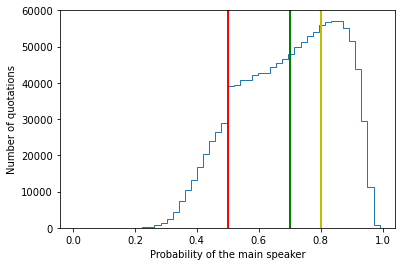

In [41]:
# Distribution of the probability attributed to the main speaker
proba_speaker1 = df_select['probas'].apply(lambda x: x[0][1]).astype(float)
plt.hist(proba_speaker1, bins=50, histtype='step')
plt.axvline(x=0.5, linewidth=2, color='r')
plt.axvline(x=0.7, linewidth=2, color='g')
plt.axvline(x=0.8, linewidth=2, color='y')
plt.xlabel('Probability of the main speaker')
plt.ylabel('Number of quotations')

Each vertical line represents a threshold (0.5, 0.7, 0.8). The aim will be to determined the best threshold to deel with the tradeoff between a good probability for the speaker identity and keeping enough quotations to carry out LDA in the last part.

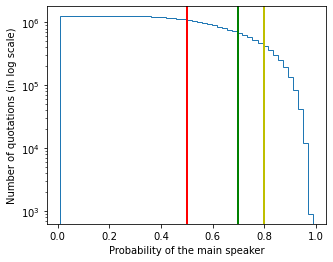

In [42]:
# Same but with log scale for the y-axis and cumulative
plt.figure(figsize=(5,4))
array_cumulative = plt.hist(proba_speaker1, bins=50, log=True, histtype='step', cumulative=-1)
plt.axvline(x=0.5, linewidth=2, color='r')
plt.axvline(x=0.7, linewidth=2, color='g')
plt.axvline(x=0.8, linewidth=2, color='y')
plt.xlabel('Probability of the main speaker')
plt.ylabel('Number of quotations (in log scale)')
plt.show()

In [43]:
# Percentage of quotations removed with the probability p attributed to the main speaker >=0.5 or >=0.7 or >=0.8
print(f"{(len(proba_speaker1[proba_speaker1<0.5]))*100/len(proba_speaker1):.0f}% of quotations would be removed if p>=0.5.")
print(f"{(len(proba_speaker1[proba_speaker1<0.7]))*100/len(proba_speaker1):.0f}% of quotations would be removed if p>=0.7.")
print(f"{(len(proba_speaker1[proba_speaker1<0.8]))*100/len(proba_speaker1):.0f}% of quotations would be removed if p>=0.8.")

# Median probability for the main speaker if if p>=0.5 or p>=0.7 or >=0.8
print(f"p_median = {proba_speaker1[proba_speaker1>0.5].median()} if p>=0.5.")
print(f"p_median = {proba_speaker1[proba_speaker1>0.7].median()} if p>=0.7.")
print(f"p_median = {proba_speaker1[proba_speaker1>0.8].median()} if p>=0.8.")

13% of quotations would be removed if p>=0.5.
47% of quotations would be removed if p>=0.7.
68% of quotations would be removed if p>=0.8.
p_median = 0.7459 if p>=0.5.
p_median = 0.8244 if p>=0.7.
p_median = 0.8696 if p>=0.8.


It seems that removing all the quotations for which the speaker probability is under 0.5 is a good way to deel with the tradeoff: we will know the identity of the speaker with 50% of certitude (in this case, the median probability for the main speaker will be 0.75, which is very good), and theorically we would have enough data to carry the LDA.

In [44]:
# Dropping rows where the probability of the main speaker is < 0.5
indexNames = df_select[df_select['probas'].apply(lambda x: x[0][1]).astype(float)<0.5].index
df_select.drop(indexNames, inplace=True)
df_select.head()

,index,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,final_quote
1,1,2015-09-16-006359,And I'm just pointing out the absurd on both s...,Kathleen Madigan,[Q6376814],2015-09-16 05:44:37,1,"[[Kathleen Madigan, 0.8025], [None, 0.1975]]",[http://northjersey.com/arts-and-entertainment...,E,"[And, Im, pointing, absurd, side, Im, sidetaki..."
2,2,2015-05-11-003168,"And you had Michael Jackson roller skating, an...",Jim McMahon,"[Q1689159, Q17306267, Q6196886]",2015-05-11 02:03:27,1,"[[Jim McMahon, 0.8731], [None, 0.1232], [Linda...",[http://www.seattletimes.com/seattle-news/bell...,E,"[And, Michael, Jackson, roller, skating, Donal..."
4,4,2015-12-22-031341,"I promise, I won't talk about Trump again,",Jeb Bush,[Q221997],2015-12-22 20:43:59,10,"[[Jeb Bush, 0.7816], [None, 0.1677], [Donald T...",[http://www.politico.com/story/2015/12/jeb-bus...,E,"[I, promise, I, talk, Trump]"
6,6,2015-07-21-047379,I'm sure the Republicans are enjoying Mr. Trum...,President Barack Obama,[Q76],2015-07-21 15:18:20,205,"[[President Barack Obama, 0.6523], [None, 0.19...",[http://azdailysun.com/entertainment/televisio...,E,"[Im, sure, Republicans, enjoying, Mr, Trumps, ..."
7,7,2015-07-22-051864,"it in particular thrives on theater, which Tru...",Frank Bruni,[Q1443006],2015-07-22 13:33:11,1,"[[Frank Bruni, 0.8479], [None, 0.1246], [Donal...",[http://www.adweek.com/tvnewser/bob-kerrey-on-...,E,"[particular, thrives, theater, Trump, provides..."


#### 2.2.3) Dropping quotations which do not have a sufficient number of words   <a class="anchor" id="I.2.2.3"></a>

In [122]:
# Creation of a new dataframe analyze_select to analyze the dataframe df_select
analyze_select = df_select.loc[:, ['quoteID', 'quotation', 'final_quote']].copy(deep=True)

# Adding a column with the number of words per quotation
analyze_select["len_quote"] = df_select["final_quote"].apply(lambda x: len(x))

analyze_select.head()

,quoteID,quotation,final_quote,len_quote
1,2015-09-16-006359,And I'm just pointing out the absurd on both s...,"[And, Im, pointing, absurd, side, Im, sidetaki...",52
2,2015-05-11-003168,"And you had Michael Jackson roller skating, an...","[And, Michael, Jackson, roller, skating, Donal...",7
4,2015-12-22-031341,"I promise, I won't talk about Trump again,","[I, promise, I, talk, Trump]",5
6,2015-07-21-047379,I'm sure the Republicans are enjoying Mr. Trum...,"[Im, sure, Republicans, enjoying, Mr, Trumps, ...",9
7,2015-07-22-051864,"it in particular thrives on theater, which Tru...","[particular, thrives, theater, Trump, provides...",6


Text(0, 0.5, 'Number of quotations')

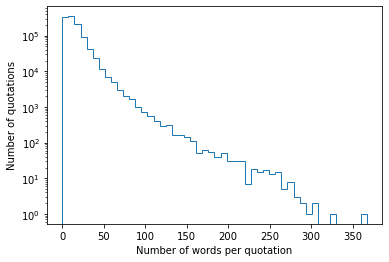

In [123]:
# Distribution of the number of words per quotation
plt.hist(analyze_select["len_quote"], bins=50, histtype='step', log=True)
#plt.axvline(x=0.5, linewidth=2, color='r')
plt.xlabel('Number of words per quotation')
plt.ylabel('Number of quotations')

In [124]:
# Description of the number of words per quotations
analyze_select.len_quote.describe()

count    1.097785e+06
mean     1.480351e+01
std      1.337286e+01
min      0.000000e+00
25%      7.000000e+00
50%      1.100000e+01
75%      1.900000e+01
max      3.670000e+02
Name: len_quote, dtype: float64

Even if most of the quotations have a small number of words (median = 11 words, please note that the median has increased since we remove quotations with no speaker and quotations without words), there are outliers (the maximum is at 367 words). Furthermore, the standard deviation is quite high (~equal to the median value). This phenomenon can be explain by the  heavy-tailed distribution of the data. 
We decided to keep the huge values, as they probably contains important information and bring more precision to our LDA analysis. Nevertheless, if their study reveals that they induce a bias in our conclusions, we will remove them. 

In [125]:
# Number of quotations with 0 words
print(str(analyze_select[analyze_select["len_quote"]==0].shape[0]) + " quotations with 0 words.")

# Dropping quotations with 0 words from analyze
indexNames = analyze_select[analyze_select["len_quote"]==0].index
analyze_select.drop(indexNames, inplace=True)

# Number of quotations with 0 words
print(str(analyze_select[analyze_select["len_quote"]==0].shape[0]) + " quotations with 0 words.")

56 quotations with 0 words.
0 quotations with 0 words.


In [126]:
# Dropping quotations with 0 words from df_select
df_select.drop(indexNames, inplace=True)

In [127]:
# Median of the number of words per quotation
analyze_select["len_quote"].median()

11.0

In [128]:
# % of total lines dropped
print(str(round((df.shape[0] - df_select.shape[0])*100/df.shape[0])) + ".2% of quotations removed.")

# total number of quotations in df_select
print("There is still " + str(df_select.shape[0]) + " quotations in the dataframe.")

# total number of words in df-select
print("There is still " + str(analyze_select.len_quote.sum()) + " words in the dataframe.")

33.2% of quotations removed.
There is still 1097729 quotations in the dataframe.
There is still 16251069 words in the dataframe.


Approximately 30% of the quotations have been removed by the entire selection processus. 

### 2.3) Filter english text  <a class="anchor" id="I.2.3"></a>

We know that the QuoteBank dataset contains quotations that are not in english. Even though some of these may be related to Donald Trump, we decided to focus on english quotations only. This choice is motivated by the fact that we will apply a topic extraction algorithm based on word frequencies. As most of the quotes will be in english, quotes in other languages will not be properly classified by this approach. We will use the `langdetect` library to detect the language and remove the non-english quotes.

In [129]:
df_select.reset_index(inplace=True)

for index, row in df_select.iterrows():
    try:
        if not langdetect.detect(row["quotation"])=='en' :
            df_select.drop(index, inplace=True)
    except:
        print("error: {} / index: {}".format(row["quotation"], index))

error: 35, 45, 55% / index: 527829
error: ÐÐ 3/4 Ñ ÑÑÐ ¸ ÑÐµÐ ± ÑÐ 3/4 Ð ± Ð ¸ Ð ¶ Ð ° Ð / index: 653431
error: 5... 7... 5... / index: 755160
error: 75%... 50% / index: 772725
error: 10, 20, 40% / index: 864509


We choose to let all these error rows except the one in index 653431 which can be removed.

In [ ]:
df_select.drop(653431, inplace=True)

In [137]:
df_select.reset_index(drop=True, inplace=True)

### 2.4) Final adjustments  <a class="anchor" id="I.2.4"></a>

In [138]:
# Converting the date column into date format
df_select.date = pd.to_datetime(df_select.date)

Text(0, 0.5, 'Number of quotations')

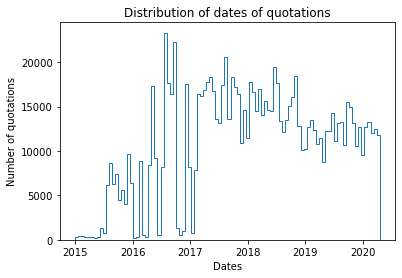

In [139]:
# Plotting the distribution of the dates of quotations
plt.hist(df_select.date, bins=100, histtype='step')
plt.title('Distribution of dates of quotations')
plt.xlabel('Dates')
plt.ylabel('Number of quotations')

In [143]:
# total number of quotations in df_select
print("There is still " + str(df_select.shape[0]) + " quotations in the dataframe.")

There is still 1083091 quotations in the dataframe.


In [140]:
# To convert the pandas DataFrame into pickle
df_select.to_pickle("data/PreProcessData.pkl")

In [141]:
# To load the pickle file into pandas DataFrame
# PreProcess_df = pd.read_pickle("data/PreProcessData.pkl")

In [142]:
# Useless but juste au cas ou
# PreProcessData = df_select.to_csv("data/PreProcessData.csv")

df_select is the final dataframe that we will use to answers our questions. It contains two types of information: the quotations made by D. Trump during its campaign and its term, and the quotations made by other people about D. Trump.

# Part II. Tools for our project about Trump  <a class="anchor" id="PartII"></a>

**_=> QUESTIONS:_**
- 1: What topics did Donald Trump most talk about during his campaign (starting in 2015)? and during his time in office (20/01/2017 - 20/01/2021)? Is there a change in Trump’s speech/topics between before and after he was elected? Can we note different periods? Can we correlate changes in the ideas expressed by Trump with external events? 
- 2: Can we quantify Trump's popularity over time and correlate it with external events? Can we see the impact of his speech on the population (different groups?)?
- 3: In which newspapers are Trump's quotations published? Is there a link between the newspapers that published the most quotations of Trump and the political affiliation of these newspapers?

## 1) Data  <a class="anchor" id="II.1"></a>

In [3]:
# To load the pickle file into pandas DataFrame
PreProcess_df = pd.read_pickle("data/PreProcessData.pkl")

In [4]:
# Construction of a dataframe with Trump's quotations
Trump_from = PreProcess_df[PreProcess_df.speaker.str.lower().str.contains("trump")].copy(deep=True)
Trump_from.reset_index(drop=True, inplace=True)
display(Trump_from.shape)
display(Trump_from.head())

(607094, 12)

,level_0,index,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,final_quote
0,919325,0,2015-07-17-029255,I am incredibly pleased that my message is res...,Donald Trump,"[Q22686, Q27947481]",2015-07-17 10:28:58,2,"[[Donald Trump, 0.8415], [None, 0.1356], [Rand...",[http://washingtontimes.com/news/2015/jul/17/d...,E,"[I, incredibly, pleased, message, resonating, ..."
1,919326,1,2015-12-10-038891,I don't want this person representing either t...,Donald Trump,"[Q22686, Q27947481]",2015-12-10 16:20:00,1,"[[Donald Trump, 0.509], [None, 0.491]]",[http://www.westernmorningnews.co.uk/Petition-...,E,"[I, want, person, representing, either, UK, US..."
2,919327,2,2015-11-14-003251,And I will tell you what -- you can say what y...,Donald Trump,"[Q22686, Q27947481]",2015-11-14 22:45:14,6,"[[Donald Trump, 0.798], [None, 0.202]]",[http://news.yahoo.com/paris-wouldve-different...,E,"[And, I, tell, say, want, gun, people, gun, al..."
3,919328,3,2015-10-07-007656,angry at our leaders for not knowing what's ha...,Donald Trump,"[Q22686, Q27947481]",2015-10-07 19:18:48,1,"[[Donald Trump, 0.9064], [None, 0.0936]]",[http://www.radioiowa.com/2015/10/07/trump-rap...,E,"[angry, leader, knowing, whats, happening]"
4,919329,4,2015-09-20-019882,I never called Jeb Bush and I never asked him ...,Donald Trump,"[Q22686, Q27947481]",2015-09-20 14:01:28,2,"[[Donald Trump, 0.5131], [None, 0.459], [Jeb B...",[http://tpmdc.talkingpointsmemo.com/livewire/d...,E,"[I, never, called, Jeb, Bush, I, never, asked,..."


In [4]:
# Construction of a daraframe with quotations about Trump
# (and speaker is not Trump or someone with Trump in his/her name)
Trump_about= PreProcess_df[PreProcess_df.final_quote.apply(lambda x : ' '.join(x)).str.contains("trump")].copy(deep=True)
Trump_about.drop(Trump_about[Trump_about.speaker.str.lower().str.contains("trump")].index, inplace=True)
Trump_about.reset_index(drop=True, inplace=True)
display(Trump_about.shape)
display(Trump_about.head())

(10994, 12)

,level_0,index,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,final_quote
0,20,20,2015-10-31-049808,"really was sort of a trump card for us, for th...",Frances Nunziata,[Q5478874],2015-10-31 00:00:00,1,"[[Frances Nunziata, 0.5726], [None, 0.4274]]",[http://www.thestar.com/news/city_hall/2015/10...,E,"[really, sort, trump, card, u, city, community..."
1,44,44,2015-01-10-028803,No-one's religious convictions can be thought ...,Ronald Dworkin,[Q319803],2015-01-10 11:22:43,1,"[[Ronald Dworkin, 0.8526], [None, 0.1474]]",[http://www.politicsweb.co.za/politicsweb/view...,E,"[Noones, religious, conviction, thought, trump..."
2,50,50,2015-10-02-101163,This experience trumps any kind of internship ...,Don Robinson,"[Q5293421, Q5293423, Q5293424, Q5293425]",2015-10-02 15:05:51,2,"[[Don Robinson, 0.8731], [None, 0.1269]]",[http://web.tampabay.com/news/publicsafety/cle...,E,"[This, experience, trump, kind, internship, an..."
3,76,76,2015-05-21-037157,It's clear the governor is weighing the pros a...,"Steve Morse ,",[Q213952],2015-05-21 19:41:17,1,"[[Steve Morse ,, 0.9493], [None, 0.0394], [Mar...",[http://blogs.mprnews.org/capitol-view/2015/05...,E,"[Its, clear, governor, weighing, pro, con, ris..."
4,79,79,2015-09-19-021975,"I think we have all, all of us recognize that ...",Francis Fonseca,[Q5480967],2015-09-19 04:29:17,1,"[[Francis Fonseca, 0.7981], [None, 0.2019]]",[http://edition.channel5belize.com/archives/11...,E,"[I, think, u, recognize, party, u, come, toget..."


## 2) Topic analysis  <a class="anchor" id="II.2"></a>

In [1]:
def make_timechunks(chunksize, min_dt, max_dt):
    '''make timechunks of size chunksize starting at min_dt and ending at max_dt'''
    delta = pd.Timedelta(chunksize)
    num_iters = math.ceil((max_dt-min_dt)/delta)
    a = min_dt
    b = min_dt
    timechunks = []
    for _ in range(num_iters):
        b = a+delta
        timechunks.append([a, b])
        a = b 
    return timechunks

## 3) Sentiment analysis  <a class="anchor" id="II.3"></a>

To analyze quotations about Trump, we will use a pre-trained sentiment analysis model, such as [Flair](https://github.com/flairNLP/flair). Such a model would allow us to classify quotations between positive and negative. We chose to start with Flair because it is pre-trained so we believe it will be easier to get started with. It can also take negations and intensifiers into account, and can work for never seen before and misspelt words. When doing sentiment analysis, we will use the original quotations because word order and stopwords can be important here.

### 3.1) Flair  <a class="anchor" id="II.3.1"></a>

In [15]:
# Flair function for sentiment analysis
def flair_analysis(quotation):
    classifier = flair.models.TextClassifier.load('en-sentiment')
    sentence = flair.data.Sentence(quotation)
    classifier.predict(sentence)
    value = sentence.labels[0].to_dict()['value']
    confidence = sentence.labels[0].to_dict()['confidence']
    return [value, confidence]

In [ ]:
# Sections of dataframe to run progressively in case of error after a while
size = 1000
df_list = [Trump_about[pos:pos+size] for pos in range(0, len(Trump_about), size)]

# Flair sentiment analysis
for n, df_seq in enumerate(df_list):
    df_out = df_seq.copy()
    df_out.loc[:,"Flair"] = df_out.quotation.apply(flair_analysis)
    df_list[n] = df_out
    print("df_list: {} / index_Trump_about: {}". format(n, df_out.index))

In [17]:
# Constructing the new dataframe with Flair sentiment analysis
Trump_about_flair = pd.concat(df_list, ignore_index=True)
Trump_about_flair = pd.concat([Trump_about_flair,pd.DataFrame(Trump_about_flair['Flair'].tolist(), columns=['FlairSentiment', 'FlairConfidence'])], axis=1)

Trump_about_flair

,level_0,index,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,final_quote,Flair,FlairSentiment,FlairConfidence
0,20,20,2015-10-31-049808,"really was sort of a trump card for us, for th...",Frances Nunziata,[Q5478874],2015-10-31 00:00:00,1,"[[Frances Nunziata, 0.5726], [None, 0.4274]]",[http://www.thestar.com/news/city_hall/2015/10...,E,"[really, sort, trump, card, u, city, community...","[NEGATIVE, 0.809940755367279]",NEGATIVE,0.809941
1,44,44,2015-01-10-028803,No-one's religious convictions can be thought ...,Ronald Dworkin,[Q319803],2015-01-10 11:22:43,1,"[[Ronald Dworkin, 0.8526], [None, 0.1474]]",[http://www.politicsweb.co.za/politicsweb/view...,E,"[Noones, religious, conviction, thought, trump...","[POSITIVE, 0.9058087468147278]",POSITIVE,0.905809
2,50,50,2015-10-02-101163,This experience trumps any kind of internship ...,Don Robinson,"[Q5293421, Q5293423, Q5293424, Q5293425]",2015-10-02 15:05:51,2,"[[Don Robinson, 0.8731], [None, 0.1269]]",[http://web.tampabay.com/news/publicsafety/cle...,E,"[This, experience, trump, kind, internship, an...","[POSITIVE, 0.8494822382926941]",POSITIVE,0.849482
3,76,76,2015-05-21-037157,It's clear the governor is weighing the pros a...,"Steve Morse ,",[Q213952],2015-05-21 19:41:17,1,"[[Steve Morse ,, 0.9493], [None, 0.0394], [Mar...",[http://blogs.mprnews.org/capitol-view/2015/05...,E,"[Its, clear, governor, weighing, pro, con, ris...","[POSITIVE, 0.9475823044776917]",POSITIVE,0.947582
4,79,79,2015-09-19-021975,"I think we have all, all of us recognize that ...",Francis Fonseca,[Q5480967],2015-09-19 04:29:17,1,"[[Francis Fonseca, 0.7981], [None, 0.2019]]",[http://edition.channel5belize.com/archives/11...,E,"[I, think, u, recognize, party, u, come, toget...","[POSITIVE, 0.9893627762794495]",POSITIVE,0.989363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10989,918842,918842,2020-02-10-060896,`Parasite' has dealt a much-needed slap to the...,Justin Chang,[Q30687995],2020-02-10 00:00:00,2,"[[Justin Chang, 0.9267], [None, 0.0684], [Bong...",[https://www.forbes.com/sites/isabeltogoh/2020...,E,"[Parasite, dealt, muchneeded, slap, American, ...","[POSITIVE, 0.9994520545005798]",POSITIVE,0.999452
10990,918886,918886,2020-01-29-128159,You'd do something crazy! I feel like Calum wo...,Michael Clifford,"[Q21282968, Q57890779]",2020-01-29 02:14:27,1,"[[Michael Clifford, 0.7178], [Calum Hood, 0.16...",[https://www.j-14.com/posts/5-seconds-of-summe...,E,"[Youd, something, crazy, I, feel, like, Calum,...","[NEGATIVE, 0.9040436148643494]",NEGATIVE,0.904044
10991,918902,918902,2020-01-24-066679,public safety should be the priority; it shoul...,Enrique Fernandez,"[Q1343998, Q52017342]",2020-01-24 22:57:49,1,"[[Enrique Fernandez, 0.9237], [None, 0.0763]]",[https://www.dailydemocrat.com/2020/01/24/wood...,E,"[public, safety, priority, trump, pool]","[NEGATIVE, 0.9134876132011414]",NEGATIVE,0.913488
10992,918916,918916,2020-01-07-004548,And Mr Stoller has come up trumps again so tha...,Peter Davis,"[Q21463617, Q3376528, Q7173569, Q7173570, Q717...",2020-01-07 15:44:38,2,"[[Peter Davis, 0.8406], [Matthew Taylor, 0.096...",[http://www.oldham-chronicle.co.uk/news-featur...,E,"[And, Mr, Stoller, come, trump, thank, much]","[POSITIVE, 0.9717126488685608]",POSITIVE,0.971713


In [18]:
Trump_about_flair.reset_index(drop=True, inplace=True)

# Saving dataframe
Trump_about_flair.to_pickle("data/Trump_about_flair.pkl")

In [2]:
# Loading the pickle file into pandas DataFrame
Trump_about_flair = pd.read_pickle("data/Trump_about_flair.pkl")

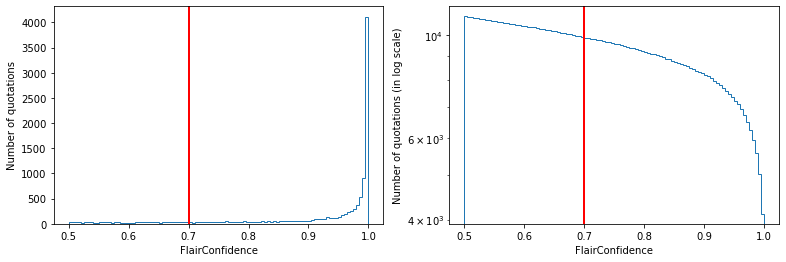

In [8]:
fig, ax = plt.subplots(1,2,figsize=(13,4))

# Visualizing FlairConfidence
ax[0].hist(Trump_about_flair.FlairConfidence, bins=100, histtype='step')
ax[0].axvline(x=0.7, linewidth=2, color='r')
ax[0].set_xlabel('FlairConfidence')
ax[0].set_ylabel('Number of quotations')

# Same but with log scale for the y-axis and cumulative
array_cumulative = ax[1].hist(Trump_about_flair.FlairConfidence, bins=100, log=True, histtype='step', cumulative=-1)
ax[1].axvline(x=0.7, linewidth=2, color='r')
ax[1].set_xlabel('FlairConfidence')
ax[1].set_ylabel('Number of quotations (in log scale)')

plt.show()

In [9]:
# Removing row with FlairConfidence < 0.7
NbIni_quotes = len(Trump_about_flair)
indexNames = Trump_about_flair[Trump_about_flair.FlairConfidence.apply(lambda x: x<0.7)].index
Trump_about_flair.drop(indexNames, inplace=True)
Trump_about_flair.reset_index(drop=True, inplace=True)

print(f"{NbIni_quotes - len(Trump_about_flair)} quotations has been removed.")
print(f"{(NbIni_quotes - len(Trump_about_flair))*100/NbIni_quotes:.0f}% of quotations has been removed.")

1110 quotations has been removed.
10% of quotations has been removed.


Text(0, 0.5, 'Number of quotations')

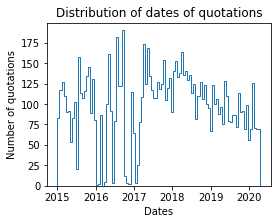

In [10]:
# Plotting the distribution of the dates of quotations
figure = plt.figure(figsize=(4,3))
plt.hist(Trump_about_flair.date, bins=100, histtype='step')
plt.title('Distribution of dates of quotations')
plt.xlabel('Dates')
plt.ylabel('Number of quotations')

### 3.2) VaderSentiment  <a class="anchor" id="II.3.2"></a>

We will use a second pre-trained sentiment analysis model as "verification". For this, we will use VADER ( Valence Aware Dictionary for Sentiment Reasoning) which is a model used for text sentiment analysis that is sensitive to both polarity (positive/negative) and intensity (strength) of emotion.

In [11]:
# Sections of dataframe to run progressively in case of error after a while
size = 1000
df_list = [Trump_about_flair[pos:pos+size] for pos in range(0, len(Trump_about_flair), size)]

# Analyser
analyzer = SentimentIntensityAnalyzer()

# Vader sentiment analysis
for n, df_seq in enumerate(df_list):
    df_out = df_seq.copy()
    df_out.loc[:,"Vader"] = df_out.quotation.apply(lambda x: analyzer.polarity_scores(x))
    df_list[n] = df_out
    print("df_list: {} / index_Trump_about_flair: {}". format(n, df_out.index))

df_list: 0 / index_Trump_about_flair: RangeIndex(start=0, stop=1000, step=1)
df_list: 1 / index_Trump_about_flair: RangeIndex(start=1000, stop=2000, step=1)
df_list: 2 / index_Trump_about_flair: RangeIndex(start=2000, stop=3000, step=1)
df_list: 3 / index_Trump_about_flair: RangeIndex(start=3000, stop=4000, step=1)
df_list: 4 / index_Trump_about_flair: RangeIndex(start=4000, stop=5000, step=1)
df_list: 5 / index_Trump_about_flair: RangeIndex(start=5000, stop=6000, step=1)
df_list: 6 / index_Trump_about_flair: RangeIndex(start=6000, stop=7000, step=1)
df_list: 7 / index_Trump_about_flair: RangeIndex(start=7000, stop=8000, step=1)
df_list: 8 / index_Trump_about_flair: RangeIndex(start=8000, stop=9000, step=1)
df_list: 9 / index_Trump_about_flair: RangeIndex(start=9000, stop=9884, step=1)


In [12]:
# Adding Vader sentiment analysis in a new dataframe
Trump_about_sentiment = pd.concat(df_list, ignore_index=True)

# Column with Vader compound
Trump_about_sentiment['VaderCompound']  = Trump_about_sentiment.Vader.apply(lambda x: x['compound'])

# Column with final Vader sentiment
Trump_about_sentiment['VaderSentiment'] = Trump_about_sentiment.VaderCompound.apply(lambda x: 'POSITIVE' if x >=0 else 'NEGATIVE')

Trump_about_sentiment

,level_0,index,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,final_quote,Flair,FlairSentiment,FlairConfidence,Vader,VaderCompound,VaderSentiment
0,20,20,2015-10-31-049808,"really was sort of a trump card for us, for th...",Frances Nunziata,[Q5478874],2015-10-31 00:00:00,1,"[[Frances Nunziata, 0.5726], [None, 0.4274]]",[http://www.thestar.com/news/city_hall/2015/10...,E,"[really, sort, trump, card, u, city, community...","[NEGATIVE, 0.809940755367279]",NEGATIVE,0.809941,"{'neg': 0.0, 'neu': 0.963, 'pos': 0.037, 'comp...",0.0772,POSITIVE
1,44,44,2015-01-10-028803,No-one's religious convictions can be thought ...,Ronald Dworkin,[Q319803],2015-01-10 11:22:43,1,"[[Ronald Dworkin, 0.8526], [None, 0.1474]]",[http://www.politicsweb.co.za/politicsweb/view...,E,"[Noones, religious, conviction, thought, trump...","[POSITIVE, 0.9058087468147278]",POSITIVE,0.905809,"{'neg': 0.0, 'neu': 0.756, 'pos': 0.244, 'comp...",0.6369,POSITIVE
2,50,50,2015-10-02-101163,This experience trumps any kind of internship ...,Don Robinson,"[Q5293421, Q5293423, Q5293424, Q5293425]",2015-10-02 15:05:51,2,"[[Don Robinson, 0.8731], [None, 0.1269]]",[http://web.tampabay.com/news/publicsafety/cle...,E,"[This, experience, trump, kind, internship, an...","[POSITIVE, 0.8494822382926941]",POSITIVE,0.849482,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,POSITIVE
3,76,76,2015-05-21-037157,It's clear the governor is weighing the pros a...,"Steve Morse ,",[Q213952],2015-05-21 19:41:17,1,"[[Steve Morse ,, 0.9493], [None, 0.0394], [Mar...",[http://blogs.mprnews.org/capitol-view/2015/05...,E,"[Its, clear, governor, weighing, pro, con, ris...","[POSITIVE, 0.9475823044776917]",POSITIVE,0.947582,"{'neg': 0.059, 'neu': 0.803, 'pos': 0.138, 'co...",0.2617,POSITIVE
4,79,79,2015-09-19-021975,"I think we have all, all of us recognize that ...",Francis Fonseca,[Q5480967],2015-09-19 04:29:17,1,"[[Francis Fonseca, 0.7981], [None, 0.2019]]",[http://edition.channel5belize.com/archives/11...,E,"[I, think, u, recognize, party, u, come, toget...","[POSITIVE, 0.9893627762794495]",POSITIVE,0.989363,"{'neg': 0.0, 'neu': 0.765, 'pos': 0.235, 'comp...",0.9724,POSITIVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9879,918842,918842,2020-02-10-060896,`Parasite' has dealt a much-needed slap to the...,Justin Chang,[Q30687995],2020-02-10 00:00:00,2,"[[Justin Chang, 0.9267], [None, 0.0684], [Bong...",[https://www.forbes.com/sites/isabeltogoh/2020...,E,"[Parasite, dealt, muchneeded, slap, American, ...","[POSITIVE, 0.9994520545005798]",POSITIVE,0.999452,"{'neg': 0.112, 'neu': 0.81, 'pos': 0.078, 'com...",-0.1280,NEGATIVE
9880,918886,918886,2020-01-29-128159,You'd do something crazy! I feel like Calum wo...,Michael Clifford,"[Q21282968, Q57890779]",2020-01-29 02:14:27,1,"[[Michael Clifford, 0.7178], [Calum Hood, 0.16...",[https://www.j-14.com/posts/5-seconds-of-summe...,E,"[Youd, something, crazy, I, feel, like, Calum,...","[NEGATIVE, 0.9040436148643494]",NEGATIVE,0.904044,"{'neg': 0.114, 'neu': 0.667, 'pos': 0.219, 'co...",0.2942,POSITIVE
9881,918902,918902,2020-01-24-066679,public safety should be the priority; it shoul...,Enrique Fernandez,"[Q1343998, Q52017342]",2020-01-24 22:57:49,1,"[[Enrique Fernandez, 0.9237], [None, 0.0763]]",[https://www.dailydemocrat.com/2020/01/24/wood...,E,"[public, safety, priority, trump, pool]","[NEGATIVE, 0.9134876132011414]",NEGATIVE,0.913488,"{'neg': 0.0, 'neu': 0.781, 'pos': 0.219, 'comp...",0.4215,POSITIVE
9882,918916,918916,2020-01-07-004548,And Mr Stoller has come up trumps again so tha...,Peter Davis,"[Q21463617, Q3376528, Q7173569, Q7173570, Q717...",2020-01-07 15:44:38,2,"[[Peter Davis, 0.8406], [Matthew Taylor, 0.096...",[http://www.oldham-chronicle.co.uk/news-featur...,E,"[And, Mr, Stoller, come, trump, thank, much]","[POSITIVE, 0.9717126488685608]",POSITIVE,0.971713,"{'neg': 0.0, 'neu': 0.787, 'pos': 0.213, 'comp...",0.5009,POSITIVE


In [13]:
# Saving dataframe
Trump_about_sentiment.to_pickle("data/Trump_about_sentiment.pkl")

In [2]:
# Loading the pickle file into pandas DataFrame
Trump_about_sentiment = pd.read_pickle("data/Trump_about_sentiment.pkl")

In [3]:
# Comparaison between Flair and Vader
Trump_about_sentiment['SentimentIsEqual'] = (Trump_about_sentiment.FlairSentiment==Trump_about_sentiment.VaderSentiment)

print("SentimentIsEqual:\n{}".format(Trump_about_sentiment.SentimentIsEqual.value_counts()))
print("........")
print("FlairSentiment: \n{}".format(Trump_about_sentiment.FlairSentiment.value_counts()))
print("........")
print("VaderSentiment: \n{}".format(Trump_about_sentiment.VaderSentiment.value_counts()))
print("........")

SentimentIsEqual:
True     6260
False    3624
Name: SentimentIsEqual, dtype: int64
........
FlairSentiment: 
NEGATIVE    5346
POSITIVE    4538
Name: FlairSentiment, dtype: int64
........
VaderSentiment: 
POSITIVE    7156
NEGATIVE    2728
Name: VaderSentiment, dtype: int64
........


## 4) Additional data  <a class="anchor" id="II.4"></a>

### Approval ratings

To be able to better interpret the fluctuations of the sentiments in the quotes about Trump, we chose to use some additional approval rating data. The data comes from https://projects.fivethirtyeight.com/trump-approval-ratings/. We chose this data source for the following reasons: 
- it aggregates the results of several polls, so it should be more representative
- it includes error bars, so we will be able to see if our interpretations are statistically significant

Below we load the data into a dataframe and plot it as a line.

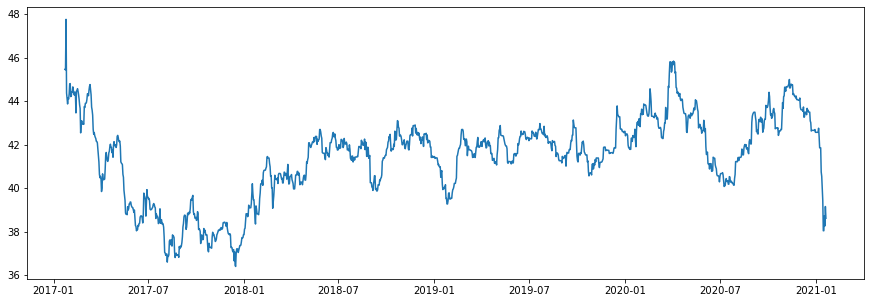

In [ ]:
df_approval = pd.read_csv("data/approval_topline.csv")
df_approval = df_approval[df_approval.subgroup == "All polls"][["modeldate", "approve_estimate"]].iloc[::-1].reset_index(drop=True)
df_approval["modeldate"] = pd.to_datetime(df_approval["modeldate"])
from matplotlib.pyplot import figure
figure(figsize=(15, 5))
plt.plot(df_approval["modeldate"], df_approval["approve_estimate"])

### Speakers metadata

In [ ]:
# Get metadata of speaker that appear in our final selection
unique_qids = list(np.unique(
    np.array(df_select.qids.apply(lambda x: x[0] if len(x) > 0 else None))
))
print(f'Number of unique QIDs in our filtered dataset: {len(unique_qids)}')
metadata_df = pd.read_parquet('data/speaker_attributes.parquet')
print(f'Initial number of speakers in metadata: {metadata_df.shape[0]}')
metadata_df = metadata_df.loc[metadata_df.id.isin(unique_qids)]
print(f'Number of speakers in our dataset and in the metadata: {metadata_df.shape[0]}')

Number of unique QIDs in our filtered dataset: 5268
Initial number of speakers in metadata: 9055981
Number of speakers in our dataset and in the metadata: 5221


# Part III. Our project about Trump  <a class="anchor" id="PartIII"></a>

## Question 1: What were Donald Trump’s favorite topics to talk about during the campaign (starting in 2015)? and his time in office (20/01/2017 - 20/01/2021)? 
## Is there a change in Trump’s speech/favorite topics between before and after he was elected? Can we note different periods? Can we correlate changes in the ideas expressed by Trump with external events? 
<a class="anchor" id="III.1"></a>

#### A bit of extra pre-processing for the topic extraction

In [5]:
nltk.download('stopwords')
stopwords = [s.replace("'", "") for s in nltk.corpus.stopwords.words('english')]

def remove_stopwords_capital_and_numbers(text):
    # removes capitalized stopwords and numbers from the text
    output = [i for i in text if i.lower() not in stopwords and not i.isnumeric()]
    return output

[nltk_data] Downloading package stopwords to /home/thomas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
Trump_from['final_quote'] = Trump_from['final_quote'].apply(lambda x: remove_stopwords_capital_and_numbers(x))

For finding out the topics about which Trump speaks and how these evolve over time, we aggregate quotes into chunks of 100 days. So we consider the text formed by concatenating the pre-processed quotes over 100 days as a single document. We tried different values for the number of days in a chunk, and 100 days allowed us to best visualize the variations in Trump's speech and in the topics he talks about.

In [8]:
documents = []
documents_lengths = []

# timechunks of 100 days
timechunks = make_timechunks('100D', Trump_from['date'].min(), Trump_from['date'].max())

for chunk in timechunks:
    document_list = Trump_from[
        Trump_from['date'].between(chunk[0], chunk[1], inclusive='left')
    ]['final_quote'].to_list()
    documents.append(' '.join([' '.join(d) for d in document_list]))
    documents_lengths.append(len(document_list))

In [11]:
freq = get_doc_frequency(documents)

We remove words which occur in more than 90% of the documents

In [12]:
stopwords_threshold = 0.9
stopwords = [w[0] for w in freq if w[1]>stopwords_threshold]
len(stopwords)

2532

In [13]:
documents = [' '.join([w for w in l.split() if w not in stopwords]) for l in documents]

Here we add bigrams which occur quite frequently

In [14]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_documents([d.split() for d in documents])
finder.apply_freq_filter(150) # only add frequent bigrams, this hyperparameter was tuned by hand to only keep relevant bigrams
bigram_scores = finder.score_ngrams(bigram_measures.pmi)

In [15]:
bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [16]:
bigrams = [' '.join(x) for x in bigram_pmi.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]

In [17]:
# function to replace pairs of words considered as bigrams by the bigram itself (with an _)
def replace_ngram(x):
    for gram in bigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    return x
documents = [replace_ngram(t).split() for t in documents]

In [18]:
documents = [' '.join(d) for d in documents]

To extract topics, we decided to use the Empath module which was introduced in the tutorial. Prior to this, we tried using LDA, but the topics obtained were not interpretable enough and tuning the hyperparameters took too much time. The code for LDA can be found in the Appendix at the bottom of this notebook.

In [26]:
lexicon = Empath()

We create 5 categories which correspond to topics that we want to extract: foreign policy, pandemic, racism, environment and economy. We tried other topics, but the results they gave were not satisfactory for our analysis.

In [45]:
lexicon.create_category("foreign_policy", ["terrorism", "war", "Iraq", "North_Korea", "China", "Europe", "Brazil", "Israel", "NAFTA", "Mexico"], model="nytimes")

["Terrorism", "Iran", "Iraq", "NATO", "Haiti", "Islamic_Republic", "United_States", "American_campaign", "Bosnia", "Ukraine", "Pakistan", "Middle_East", "Europe", "Baltics", "Mideast", "Afghanistan", "American_war", "Afghan_resistance", "Al_Qaeda", "Forces", "Bombing", "Liberation", "military_effort", "neighboring_Afghanistan", "regional_security", "Taliban_regime", "Pact", "Sovereignty", "Allies", "Attacks", "A6", "A8", "Soviet", "Colombia", "led_campaign", "Muslim_fundamentalists", "A5", "Islamic_extremism", "anti-Iraq_coalition", "Persian_Gulf", "big_powers", "led_alliance", "Taliban_government", "state_terrorism", "Arabs", "American_intervention", "Nationalism", "Korea", "Islamic_militancy", "Palestine", "American_military_action", "American_military_power", "Islamic", "Jihad", "Vietnam", "A9", "Serbia", "Yugoslav_crisis", "occupying_forces", "Teheran", "A3", "Hostages", "Western_interests", "Muslim_nations", "United_States_interests", "American_role", "Terror", "open_borders", "NA

In [46]:
lexicon.create_category("pandemic", ["pandemic", "virus", "health", "mask", "epidemic", "death", "flu", "hospital"], model="nytimes")

["disease", "infection", "infections", "brain_damage", "tuberculosis", "illness", "ailment", "viral_infection", "meningitis", "fatal_disease", "malaria", "polio", "heart_problems", "dementia", "ulcers", "syphilis", "chronic_pain", "virus", "fevers", "influenza", "other_diseases", "multiple_sclerosis", "lung", "anesthesia", "diarrhea", "asthma", "blood_transfusion", "hypothermia", "epilepsy", "sickness", "infectious_disease", "hepatitis_C", "illnesses", "measles", "human_immunodeficiency_virus", "cancer", "anemia", "leprosy", "other_ailments", "AIDS_virus", "chest_pain", "chemotherapy", "melanoma", "symptoms", "H.I.V._infection", "dehydration", "H.I.V.", "cholera", "Lyme_disease", "epidemic", "arthritis", "transfusion", "brain_injury", "TB", "colon_cancer", "blood_supply", "rabies", "antibiotics", "memory_loss", "migraines", "lymph_nodes", "chronic_fatigue_syndrome", "disorder", "bacterial_infection", "chicken_pox", "transfusions", "diagnosis", "tumor", "immune_systems", "kidney_failure

In [47]:
lexicon.create_category("racism", ["Georges_Floyd", "Black Lives Matter", "BLM", "immigration", "black_people", "black", "KKK", "white_supremacy", "borders"], model="nytimes")

["blacks", "immigration", "black_people", "poor_blacks", "American_blacks", "Latinos", "African-Americans", "black_Americans", "immigrants", "other_ethnic_groups", "segregation", "ethnic_group", "Puerto_Ricans", "many_blacks", "racism", "nonwhites", "racial", "bigotry", "underclass", "American_society", "ghettos", "gay_people", "Afrikaners", "white_society", "whites", "Africans", "black_community", "minorities", "new_immigrants", "working_class", "ethnic_groups", "ethnic_minorities", "Native_Americans", "black_communities", "Asians", "many_whites", "oppression", "assimilation", "Mexican-Americans", "ethnic_identity", "slavery", "other_minorities", "Hispanics", "young_blacks", "intolerance", "skin_color", "American_mainstream", "intermarriage", "civil_rights", "illegal_immigration", "white_people", "caste", "apartheid", "American_life", "prejudice", "racists", "homelands", "black_citizens", "religion", "immigrant_groups", "extremism", "ethnic", "Italian-Americans", "black_South_Africans

In [48]:
lexicon.create_category("environment", ["environment", "pollution"], model="nytimes")

["pollution", "environment", "air_pollution", "water_quality", "water_pollution", "environmental_problems", "acid_rain", "environmental_concerns", "environmental_damage", "smog", "human_health", "pollutants", "clean_air", "water_supplies", "ecosystems", "air_quality", "natural_resources", "overdevelopment", "oil_spills", "fossil_fuels", "ecosystem", "pollute", "water_resources", "water_supply", "public_health", "groundwater", "greenhouse_effect", "biodiversity", "marine_environment", "ozone", "global_warming", "pollution_problems", "urban_sprawl", "environmental_degradation", "biological_diversity", "incineration", "public_lands", "polluting", "climate_change", "depletion", "deforestation", "wetlands", "food_supply", "soil_erosion", "logging", "forests", "pesticides", "ground_water", "natural_environment", "toxic_wastes", "ozone_layer", "marine_life", "watersheds", "energy_conservation", "toxic_chemicals", "emissions", "fishing_industry", "wildlife", "overfishing", "environmental_prote

In [31]:
lexicon.create_category("economy", ["money", "stock_exchange", "market", "Wall_Street", "trade", "trade_deal", "business", "inflation", "dollar", "bank", "finance"], model="nytimes")

["American_investors", "Japanese_banks", "foreign_investors", "Japanese_investors", "capital_markets", "lending", "commercial_banks", "high_interest_rates", "lower_interest_rates", "investors", "currency", "stock_market", "speculators", "markets", "dollar", "banking_industry", "interest_rates", "individual_investors", "hedge_funds", "peso", "bank_loans", "equities", "higher_interest_rates", "banking_system", "financial_markets", "low_interest_rates", "foreign_exchange", "foreign_investment", "share_prices", "liquidity", "many_banks", "investments", "emerging_markets", "ruble", "Japanese_economy", "American_banks", "exchange_rates", "foreign_markets", "equity_markets", "central_banks", "international_markets", "foreign_capital", "market", "big_banks", "more_investors", "equity_market", "world_markets", "foreign_banks", "small_investors", "new_money", "Mexican_economy", "central_bank", "bank", "currencies", "stock_prices", "bank_deposits", "money_market_funds", "American_currency", "borr

For each of our topics, we will generate a wordcloud representing the most frequent words belonging to this topic which Trump uses. This serves to illustrate how Trump speaks about the topics and what vocabulary he uses.

In [32]:
all_words = ' '.join(documents).split()
topic_words = {'pandemic': [],
               'racism': [],
               'foreign_policy': [],
               'economy': [],
               'environment': []
              }

# here we see if each word fits into one of the 5 topics we are interested in
for a in all_words:
    res = lexicon.analyze(a, categories = ["pandemic", "racism", "economy", "environment", "foreign_policy"], normalize = True)
    for k in res:
        if res[k] > 0:
            topic_words[k].append(a)

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000


In [35]:
def generate_wordcloud(data, title, plot_title=True):
    wc = WordCloud(width=400, height=330, 
                   max_words=10, background_color='white', collocation_threshold=30000).generate(data)
    plt.figure(figsize=(6,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    if plot_title:
        plt.title(title, fontsize=13)
        
    plt.savefig(f'plots/wc_{title.lower().replace(" ", "_")}.png', dpi=300)
    plt.show()

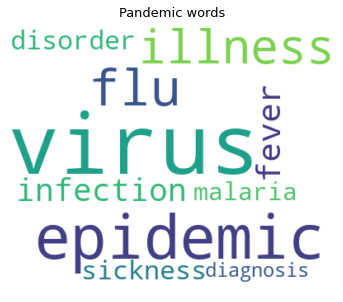

In [36]:
generate_wordcloud(" ".join(topic_words["pandemic"]), "Pandemic words")

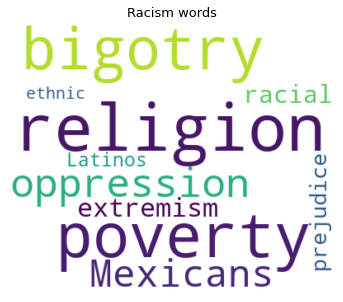

In [37]:
generate_wordcloud(" ".join(topic_words["racism"]), "Racism words")

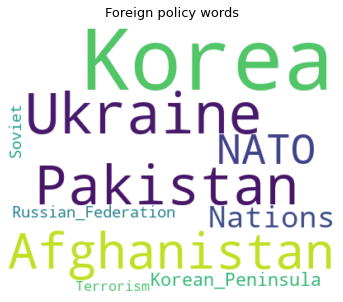

In [38]:
generate_wordcloud(" ".join(topic_words["foreign_policy"]), "Foreign policy words")

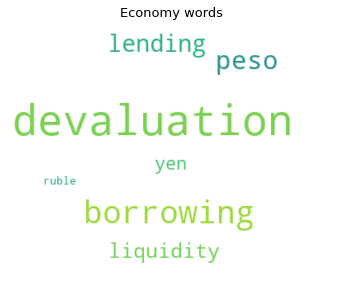

In [39]:
generate_wordcloud(" ".join(topic_words["economy"]), "Economy words")

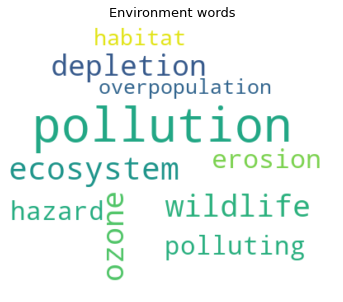

In [40]:
generate_wordcloud(" ".join(topic_words["environment"]), "Environment words")

In [41]:
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser'])

In [42]:
pandemic = []
racism = []
foreign_policy = []
economy = []
environment = []

for docu in documents:
    doc = nlp(docu)
    empath_features = lexicon.analyze(doc.text,
                                      categories = ["pandemic", "racism", "economy", "environment", "foreign_policy"], normalize = True)
    pandemic.append(empath_features["pandemic"])
    racism.append(empath_features["racism"])
    economy.append(empath_features["economy"])
    environment.append(empath_features["environment"])
    foreign_policy.append(empath_features["foreign_policy"])

0
10


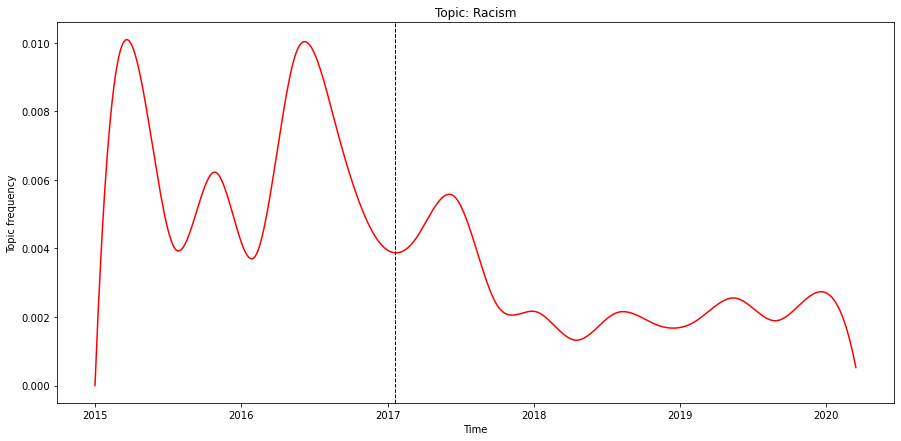

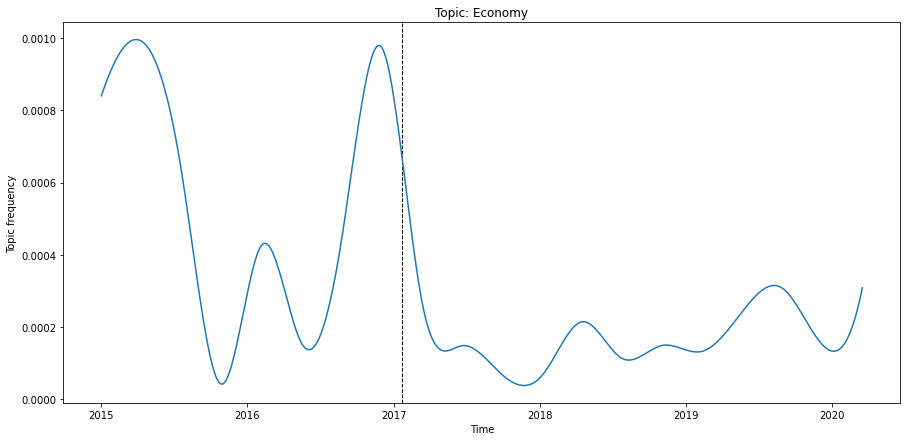

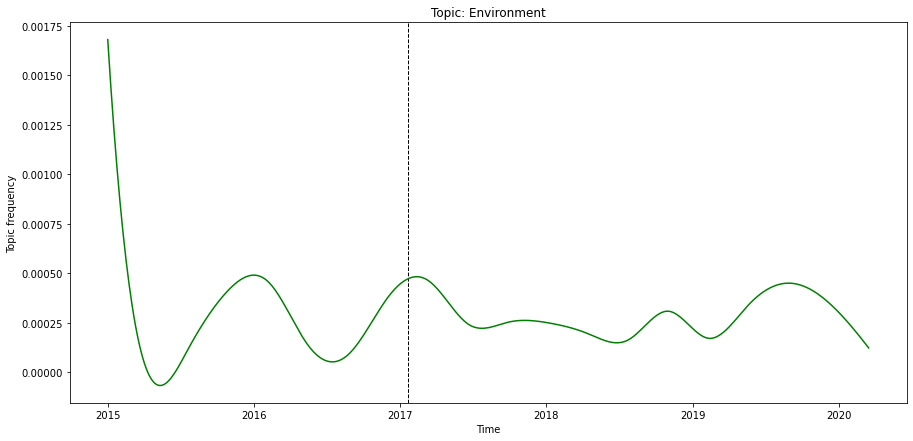

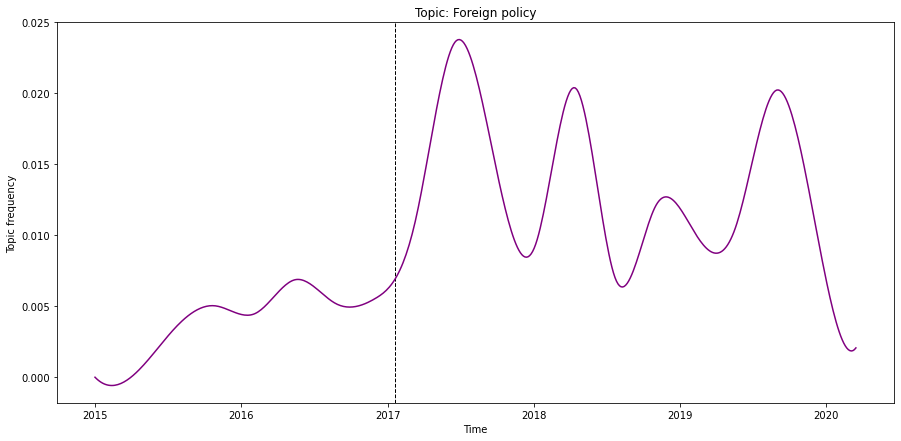

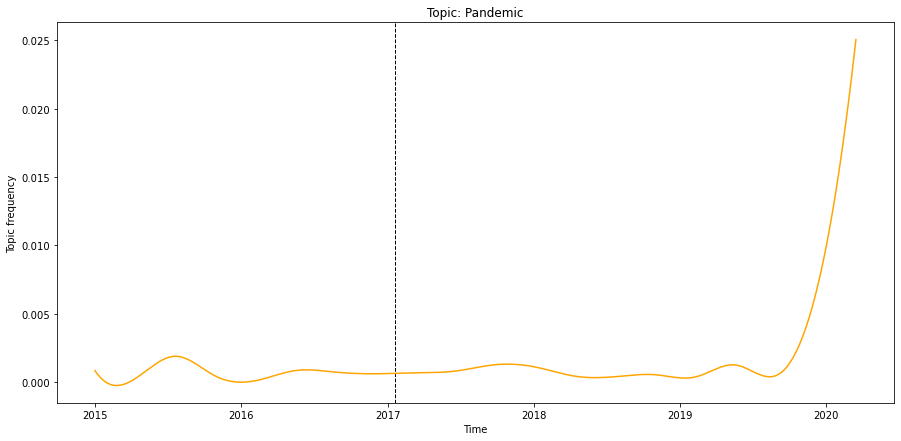

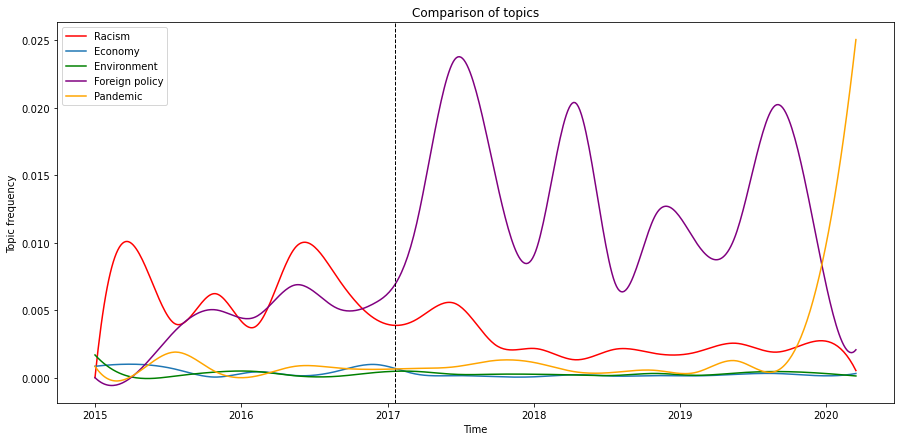

In [44]:
trump_timestamp = pd.Timestamp('2017-01-20 00:00:00')
start = timechunks[0][0]
end = timechunks[-1][0]
t = np.linspace(start.value, end.value, 500)
t = pd.to_datetime(t)
xs = np.array([i for i in range(len(timechunks))])

# Function to generate a plot for a single topic
def plot_topic(topic, title, color):
    figure = plt.figure(figsize=(15,7))
    X_Y_Spline = make_interp_spline(xs, topic) # we use a spline to get a smooth curve on our plot
    X_ = np.linspace(xs.min(), xs.max(), 500)
    Y_ = X_Y_Spline(X_)
    plt.axvline(x=trump_timestamp, linewidth=1, color='black', linestyle="--") # line representing date when Trump entered office
    plt.plot(t, Y_, color=color)
    plt.title(f"Topic: {title}")
    plt.xlabel("Time")
    plt.ylabel("Topic frequency")
    plt.savefig(f'plots/topic_{title.lower().replace(" ", "_")}.png', dpi=300)

plot_topic(racism, "Racism", "red")
plot_topic(economy, "Economy", "blue")
plot_topic(environment, "Environment", "green")
plot_topic(foreign_policy, "Foreign policy", "purple")
plot_topic(pandemic, "Pandemic", "orange")



# Function to add the curve for a topic to the figure
def plot_topic_multi(topic, label, color):
    X_Y_Spline = make_interp_spline(xs, topic)
    X_ = np.linspace(xs.min(), xs.max(), 500)
    Y_ = X_Y_Spline(X_)
    plt.plot(t, Y_, label=label, color=color)

figure = plt.figure(figsize=(15,7))
plot_topic_multi(racism, "Racism", "red")
plot_topic_multi(economy, "Economy", "blue")
plot_topic_multi(environment, "Environment", "green")
plot_topic_multi(foreign_policy, "Foreign policy", "purple")
plot_topic_multi(pandemic, "Pandemic", "orange")
plt.axvline(x=trump_timestamp, linewidth=1, color='black', linestyle="--")
plt.title("Comparison of topics")
plt.xlabel("Time")
plt.ylabel("Topic frequency")
plt.legend(loc="upper left")
plt.savefig(f'plots/topic_all.png', dpi=300)

## Question 2: Can we quantify Trump popularity over time and correlate it with external events? Can we see the impact of his speech on the population (different groups of population?)?   <a class="anchor" id="III.2"></a>

### 2.1) Trump popularity over time   <a class="anchor" id="III.2.1"></a>

#### 2.1.1) With Flair   <a class="anchor" id="III.2.1.1"></a>

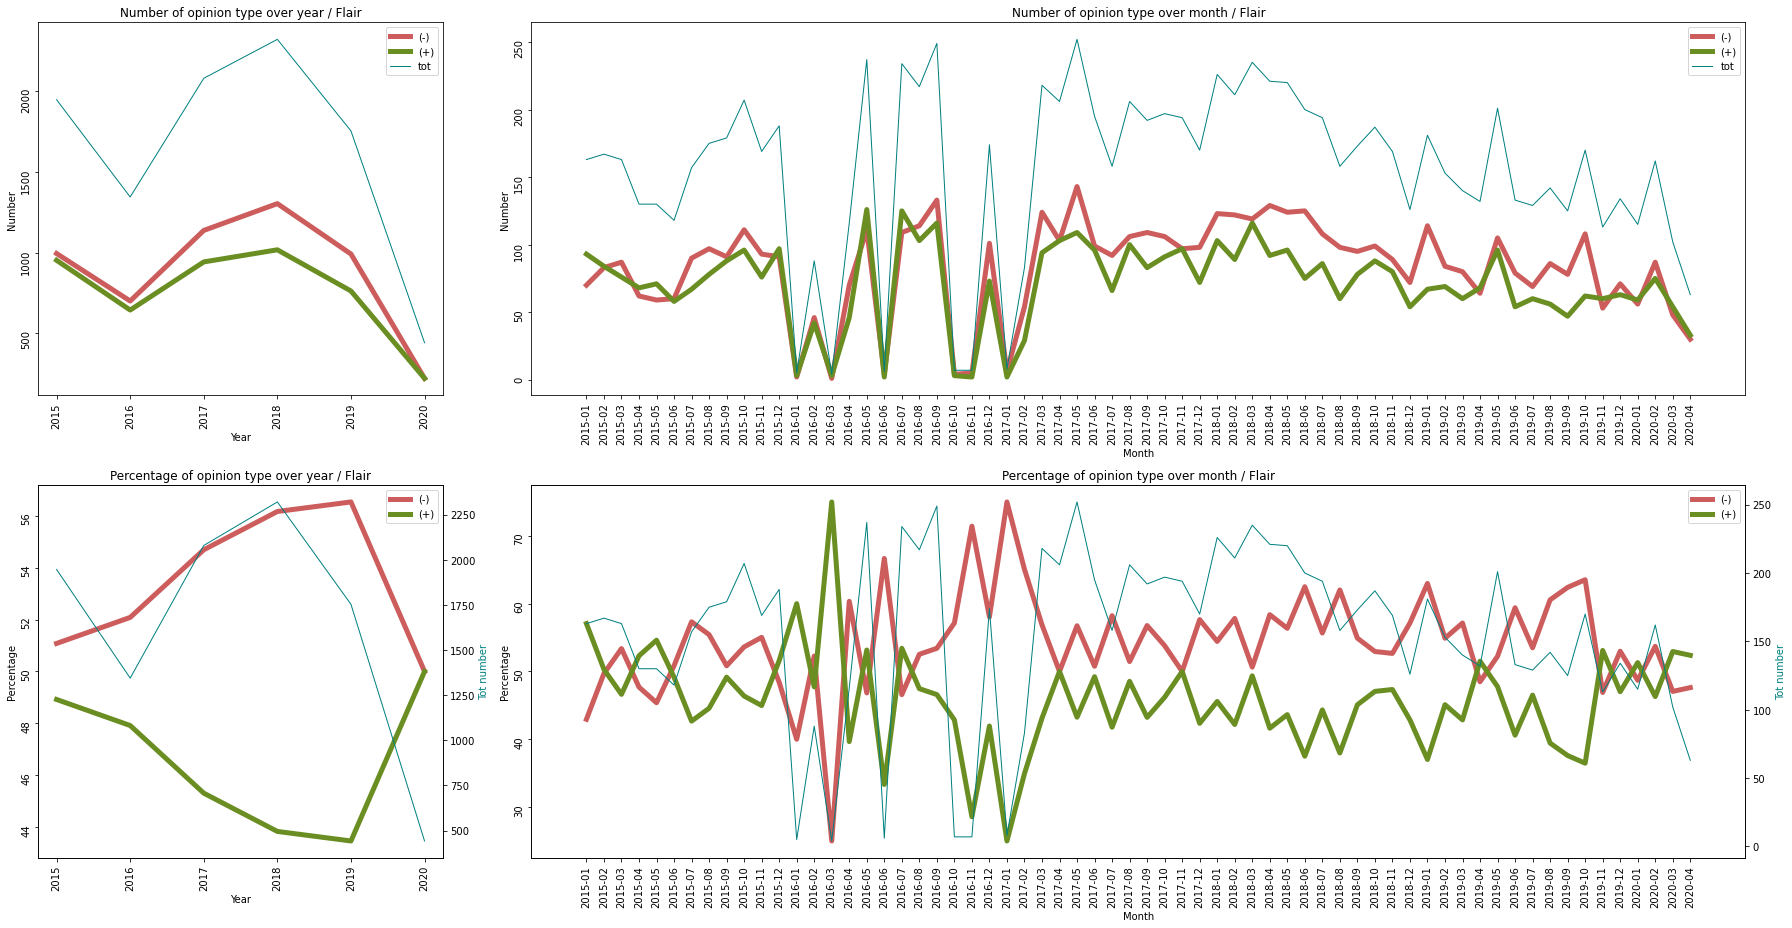

In [3]:
# Stats:

## Calculate yearly stats about sentiments
stats_year_Flair = Trump_about_sentiment.groupby(Trump_about_sentiment['date'].map(lambda x: x.year)) \
                .apply(lambda x: pd.Series({
                     'number_negative': x['FlairSentiment'].value_counts()['NEGATIVE'],
                     'number_positive': x['FlairSentiment'].value_counts()['POSITIVE'],
                     'number_tot': len(x['FlairSentiment']),
                     'percent_negative': x['FlairSentiment'].value_counts()['NEGATIVE']*100/len(x['FlairSentiment']),
                     'percent_positive': x['FlairSentiment'].value_counts()['POSITIVE']*100/len(x['FlairSentiment'])
    }))

## Calculate monthly stats about sentiments
stats_month_Flair = Trump_about_sentiment.groupby([Trump_about_sentiment.date.dt.year, Trump_about_sentiment.date.dt.month]) \
                .apply(lambda x: pd.Series({
                     'number_negative': x['FlairSentiment'].value_counts()['NEGATIVE'],
                     'number_positive': x['FlairSentiment'].value_counts()['POSITIVE'],
                     'number_tot': len(x['FlairSentiment']),
                     'percent_negative': x['FlairSentiment'].value_counts()['NEGATIVE']*100/len(x['FlairSentiment']),
                     'percent_positive': x['FlairSentiment'].value_counts()['POSITIVE']*100/len(x['FlairSentiment'])
    }))


# Graphs:

fig, ax = plt.subplots(2,2,figsize=(25,13), gridspec_kw={'width_ratios': [1, 3]})

## Graphs by year
ax[0,0].plot(stats_year_Flair.index, stats_year_Flair.number_negative, label='(-)', color='indianred', linewidth=5.0)
ax[0,0].plot(stats_year_Flair.index, stats_year_Flair.number_positive, label='(+)', color='olivedrab', linewidth=5.0)
ax[0,0].plot(stats_year_Flair.index, stats_year_Flair.number_tot, label='tot', color='teal', linewidth=1.0)
ax[0,0].set_title('Number of opinion type over year / Flair')
ax[0,0].set_xlabel('Year')
ax[0,0].set_ylabel('Number')
ax[0,0].tick_params(labelrotation=90)
ax[0,0].legend()

ax[1,0].plot(stats_year_Flair.index, stats_year_Flair.percent_negative, label='(-)', color='indianred', linewidth=5.0)
ax[1,0].plot(stats_year_Flair.index, stats_year_Flair.percent_positive, label='(+)', color='olivedrab', linewidth=5.0)
ax101 = ax[1,0].twinx()
ax101.plot(stats_year_Flair.index, stats_year_Flair.number_tot, color='teal', linewidth=1.0)
ax[1,0].set_title('Percentage of opinion type over year / Flair')
ax[1,0].set_xlabel('Year')
ax[1,0].set_ylabel('Percentage')
ax101.set_ylabel('Tot number', color='teal')
ax[1,0].tick_params(labelrotation=90)
ax[1,0].legend()

## Graphs by month
x_month_Flair = pd.to_datetime(stats_month_Flair.index.to_series().apply(lambda x: str(x[0])+"-"+str(x[1]))) \
.dt.date.apply(lambda x: x.strftime('%Y-%m'))

ax[0,1].plot(x_month_Flair, stats_month_Flair.number_negative, label='(-)', color='indianred', linewidth=5.0)
ax[0,1].plot(x_month_Flair, stats_month_Flair.number_positive, label='(+)', color='olivedrab', linewidth=5.0)
ax[0,1].plot(x_month_Flair, stats_month_Flair.number_tot, label='tot', color='teal', linewidth=1.0)
ax[0,1].set_title('Number of opinion type over month / Flair')
ax[0,1].set_xlabel('Month')
ax[0,1].set_ylabel('Number')
ax[0,1].tick_params(labelrotation=90)
ax[0,1].legend()

ax[1,1].plot(x_month_Flair, stats_month_Flair.percent_negative, label='(-)', color='indianred', linewidth=5.0)
ax[1,1].plot(x_month_Flair, stats_month_Flair.percent_positive, label='(+)', color='olivedrab', linewidth=5.0)
ax111 = ax[1,1].twinx()
ax111.plot(x_month_Flair, stats_month_Flair.number_tot, color='teal', linewidth=1.0)
ax[1,1].set_title('Percentage of opinion type over month / Flair')
ax[1,1].set_xlabel('Month')
ax[1,1].set_ylabel('Percentage')
ax111.set_ylabel('Tot number', color='teal')
ax[1,1].tick_params(labelrotation=90)
ax[1,1].legend()

plt.tight_layout()
plt.show()

When we look by year, we see that overall the opinions about Trump are more negative than positive. There is a sharp increase in negative opinions from 2015 to 2019. In 2020, we fall back to 50/50, but this must be nuanced in view of the very strong decrease in the number of citations.

When we look by month, we note the presence of many peaks. It can be interesting to link these peaks to current events even if it remains totally suppositions. For example, if we look in terms of number of negative quotes, we see a peak in January 2019 which could be explained by the longest shutdown in the history of the United States about the wall at the Mexican border.

According to these results, it would be interesting to look with intermediate intervals to those of the year or the month by grouping a certain number of months.

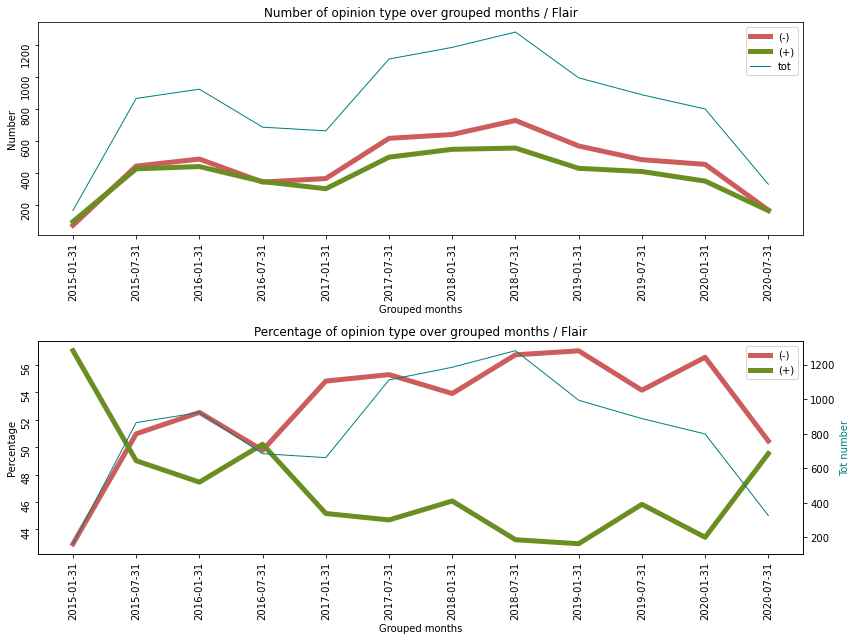

In [8]:
N = 6 # number of months we want to regroup

# Calculate adapted time stats about sentiments
stats_GroupMonth_Flair = Trump_about_sentiment.groupby(pd.Grouper(freq='{}M'.format(N), key='date')) \
                .apply(lambda x: pd.Series({
                     'number_negative': x['FlairSentiment'].value_counts()['NEGATIVE'],
                     'number_positive': x['FlairSentiment'].value_counts()['POSITIVE'],
                     'number_tot': len(x['FlairSentiment']),
                     'percent_negative': x['FlairSentiment'].value_counts()['NEGATIVE']*100/len(x['FlairSentiment']),
                     'percent_positive': x['FlairSentiment'].value_counts()['POSITIVE']*100/len(x['FlairSentiment'])
    }))

# Graphs by adapted time
fig, ax = plt.subplots(2,1,figsize=(12,9))

ax[0].plot(stats_GroupMonth_Flair.index.astype(str), stats_GroupMonth_Flair.number_negative, label='(-)', color='indianred', linewidth=5.0)
ax[0].plot(stats_GroupMonth_Flair.index.astype(str), stats_GroupMonth_Flair.number_positive, label='(+)', color='olivedrab', linewidth=5.0)
ax[0].plot(stats_GroupMonth_Flair.index.astype(str), stats_GroupMonth_Flair.number_tot, label='tot', color='teal', linewidth=1.0)
ax[0].set_title('Number of opinion type over grouped months / Flair')
ax[0].set_xlabel('Grouped months')
ax[0].set_ylabel('Number')
ax[0].tick_params(labelrotation=90)
ax[0].legend()

ax[1].plot(stats_GroupMonth_Flair.index.astype(str), stats_GroupMonth_Flair.percent_negative, label='(-)', color='indianred', linewidth=5.0)
ax[1].plot(stats_GroupMonth_Flair.index.astype(str), stats_GroupMonth_Flair.percent_positive, label='(+)', color='olivedrab', linewidth=5.0)
ax11 = ax[1].twinx()
ax11.plot(stats_GroupMonth_Flair.index.astype(str), stats_GroupMonth_Flair.number_tot, color='teal', linewidth=1.0)
ax[1].set_title('Percentage of opinion type over grouped months / Flair')
ax[1].set_xlabel('Grouped months')
ax[1].set_ylabel('Percentage')
ax11.set_ylabel('Tot number', color='teal')
ax[1].tick_params(labelrotation=90)
ax[1].legend()

plt.tight_layout()
plt.show()

#### 2.1.2) With Vader   <a class="anchor" id="III.2.1.2"></a>

In [5]:
# Bootstrapping function to obtain 95% confidence intervals around the estimated average. 
    # Input: your array and the number of random samples (e.g., 1000 is a good number)
    # Output: [lower error, upper error]
def bootstrap_CI(data, nbr_draws):
    means = np.zeros(nbr_draws)
    data = np.array(data)
    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        means[n] = np.nanmean(data_tmp)
    return [np.nanpercentile(means, 2.5),np.nanpercentile(means, 97.5)]

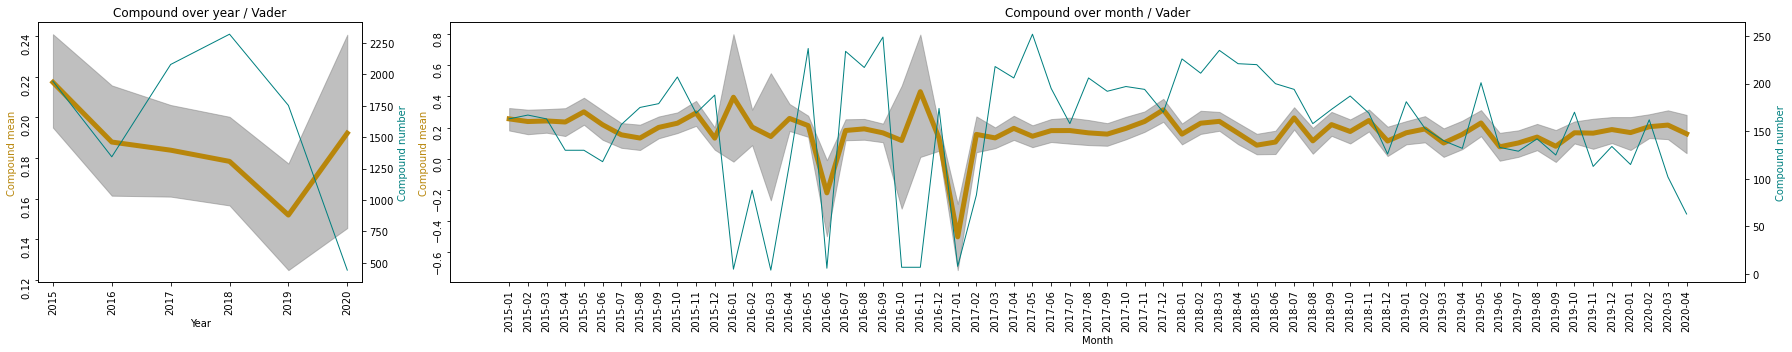

In [6]:
# Stats:

## Calculate yearly stats about sentiments
stats_year_Vader = Trump_about_sentiment.groupby(Trump_about_sentiment['date'].map(lambda x: x.year)) \
                    .apply(lambda x: pd.Series({
                            'average_VaderCompound': x['VaderCompound'].mean(),
                            'lower_err_VaderCompound': bootstrap_CI(x['VaderCompound'], 1000)[0],
                            'upper_err_VaderCompound': bootstrap_CI(x['VaderCompound'], 1000)[1],
                            'number_VaderCompound': len(x['VaderCompound']),
    }))

## Calculate monthly stats about sentiments
stats_month_Vader = Trump_about_sentiment.groupby([Trump_about_sentiment.date.dt.year, Trump_about_sentiment.date.dt.month]) \
                    .apply(lambda x: pd.Series({
                            'average_VaderCompound': x['VaderCompound'].mean(),
                            'lower_err_VaderCompound': bootstrap_CI(x['VaderCompound'], 1000)[0],
                            'upper_err_VaderCompound': bootstrap_CI(x['VaderCompound'], 1000)[1],
                            'number_VaderCompound': len(x['VaderCompound']),
    }))


# Graphs:

fig, ax = plt.subplots(1,2,figsize=(25,5), gridspec_kw={'width_ratios': [1, 4]})

## Graphs by year
ax[0].fill_between(stats_year_Vader.index, 
                    stats_year_Vader.lower_err_VaderCompound,
                    stats_year_Vader.upper_err_VaderCompound, alpha=0.5, color='gray')
ax[0].plot(stats_year_Vader.index, stats_year_Vader.average_VaderCompound, color='darkgoldenrod', label='mean', linewidth=5.0)
ax01 = ax[0].twinx()
ax01.plot(stats_year_Vader.index, stats_year_Vader.number_VaderCompound, color="teal", label='number', linewidth=1.0)
ax[0].set_title('Compound over year / Vader')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Compound mean', color="darkgoldenrod")
ax01.set_ylabel('Compound number', color="teal")
ax[0].tick_params(labelrotation=90)

## Graphs by month
x_month_Vader = pd.to_datetime(stats_month_Flair.index.to_series().apply(lambda x: str(x[0])+"-"+str(x[1]))) \
.dt.date.apply(lambda x: x.strftime('%Y-%m'))

ax[1].fill_between(x_month_Vader, 
                    stats_month_Vader.lower_err_VaderCompound,
                    stats_month_Vader.upper_err_VaderCompound, alpha=0.5, color='gray')
ax[1].plot(x_month_Vader, stats_month_Vader.average_VaderCompound, color='darkgoldenrod', label='mean', linewidth=5.0)
ax11 = ax[1].twinx()
ax11.plot(x_month_Vader, stats_month_Vader.number_VaderCompound, color="teal", label='number', linewidth=1.0)
ax[1].set_title('Compound over month / Vader')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Compound mean', color="darkgoldenrod")
ax11.set_ylabel('Compound number', color="teal")
ax[1].tick_params(labelrotation=90)

plt.tight_layout()
plt.show()

We find the same trend for the year as with Flair but less for the months. In addition, we can note that Vader tends to provide more positive opinions on Trump than Flair (see following notebook).

Again it is interesting to be able to choose intermediate intervals, especially for comparison with Flair since the results are close for the year but rather different for the months.

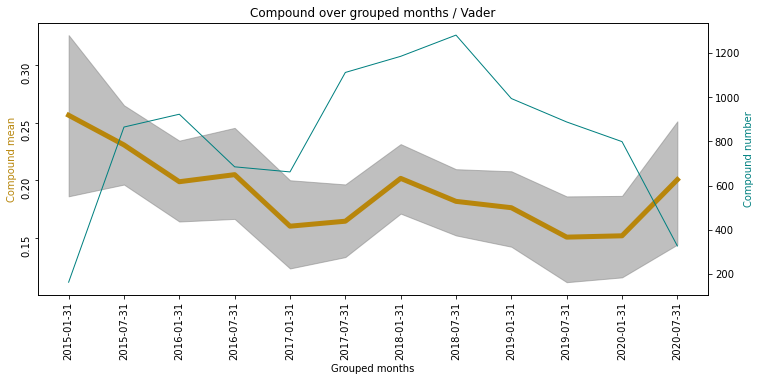

In [7]:
N = 6 # number of months we want to regroup

# Calculate adapted time stats about sentiments
stats_GroupMonth_Vader = Trump_about_sentiment.groupby(pd.Grouper(freq='{}M'.format(N), key='date')) \
                           .apply(lambda x: pd.Series({
                                'average_VaderCompound': x['VaderCompound'].mean(),
                                'lower_err_VaderCompound': bootstrap_CI(x['VaderCompound'], 1000)[0],
                                'upper_err_VaderCompound': bootstrap_CI(x['VaderCompound'], 1000)[1],
                                'number_VaderCompound': len(x['VaderCompound']),
    }))


# Graphs by adapted time
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)

ax.fill_between(stats_GroupMonth_Vader.index.astype(str), 
                    stats_GroupMonth_Vader.lower_err_VaderCompound,
                    stats_GroupMonth_Vader.upper_err_VaderCompound, alpha=0.5, color='gray')
ax.plot(stats_GroupMonth_Vader.index.astype(str), stats_GroupMonth_Vader.average_VaderCompound, color='darkgoldenrod', label='mean', linewidth=5.0)
ax1 = ax.twinx()
ax1.plot(stats_GroupMonth_Vader.index.astype(str), stats_GroupMonth_Vader.number_VaderCompound, color="teal", label='number', linewidth=1.0)
ax.set_title('Compound over grouped months / Vader')
ax.set_xlabel('Grouped months')
ax.set_ylabel('Compound mean', color="darkgoldenrod")
ax1.set_ylabel('Compound number', color="teal")
ax.tick_params(labelrotation=90)

plt.show()

We find the same trend as for Flair, which seems to demonstrate a certain robustness of the results.

#### 2.1.3) Comparison with approval ratings   <a class="anchor" id="III.2.1.3"></a>

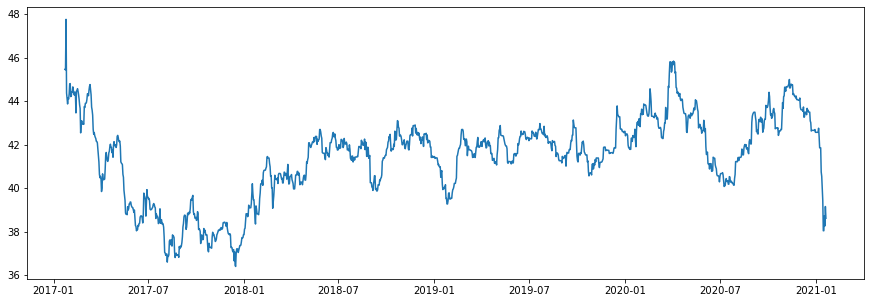

In [9]:
# (cf. PartII.4)
df_approval = pd.read_csv("data/approval_topline.csv")
df_approval = df_approval[df_approval.subgroup == "All polls"][["modeldate", "approve_estimate"]].iloc[::-1].reset_index(drop=True)
df_approval["modeldate"] = pd.to_datetime(df_approval["modeldate"])
from matplotlib.pyplot import figure
figure(figsize=(15, 5))
plt.plot(df_approval["modeldate"], df_approval["approve_estimate"])

The very general shape of the curve can be seen when you look at the polls on Trump.

### 2.2) Trump popularity and population groups   <a class="anchor" id="III.2.2"></a>

#### 2.2.1) Processing of the speakers data    <a class="anchor" id="III.2.2.1"></a>

We will use the additional metadata about the speakers (identified with their QIDs) in the Quotebank dataset:

In [3]:
# Get metadata of speaker that appear in our sentiment table

unique_qids = list(np.unique(np.array(Trump_about_sentiment.qids.apply(lambda x: x[0] if len(x) > 0 else None))))

metadata_about_sentiment = pd.read_parquet('data/speaker_attributes.parquet')
metadata_about_sentiment = metadata_about_sentiment.loc[metadata_about_sentiment.id.isin(unique_qids)]
metadata_about_sentiment.reset_index(drop=True, inplace=True)

metadata_about_sentiment

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
1,"[Namo, Modi, Narendra Bhai, Narendra Damodarda...",[+1950-09-17T00:00:00Z],[Q668],[Q6581097],1395415052,"[Q1282294, Q6889284]",None,"[Q82955, Q36180, Q7019111, Q10429346]",[Q10230],None,Q1058,Narendra Modi,"[Q63988227, Q63988919, Q16841231, Q16251961, Q...",item,[Q9089]
2,"[Ban Kimoon, Ban Ki Moon]",[+1944-06-13T00:00:00Z],[Q884],[Q6581097],1384825460,[Q484464],None,"[Q82955, Q193391]",[Q327591],None,Q1253,Ban Ki-moon,None,item,"[Q9581, Q748]"
3,[Ashton James Eaton],[+1988-01-21T00:00:00Z],[Q30],[Q6581097],1395347414,[Q49085],None,[Q14605941],None,None,Q1789,Ashton Eaton,None,item,None
4,[Michel François Platini],[+1955-06-21T00:00:00Z],"[Q142, Q38]",[Q6581097],1389743756,None,None,"[Q937857, Q15986539, Q628099]",None,None,Q4261,Michel Platini,None,item,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6471,None,None,None,[Q6581072],1217288455,None,None,[Q1650915],None,None,Q58488444,Rachel Goodwin,None,item,None
6472,None,None,[Q145],[Q6581072],1341469398,None,None,[Q18545066],None,None,Q59143032,Beth Jones,None,item,None
6473,None,None,None,[Q6581097],1382791097,None,None,[Q28389],None,None,Q59178218,Bryan Wynbrandt,None,item,None
6474,None,[+1949-06-04T00:00:00Z],None,[Q6581097],1324830701,None,None,None,None,None,Q59610397,Richard Cavell,None,item,None


We will be interested in: nationality, gender, ethnic_group, occupation, party, academic_degree and religion.

In [4]:
# Get description of the labels
labels_descript_quotebank = pd.read_csv("data/wikidata_labels_descriptions_quotebank.csv.bz2", compression="bz2")
labels_descript_quotebank

,QID,Label,Description
0,Q31,Belgium,country in western Europe
1,Q45,Portugal,country in southwestern Europe
2,Q75,Internet,global system of connected computer networks
3,Q148,People's Republic of China,sovereign state in East Asia
4,Q155,Brazil,country in South America
...,...,...,...
36964,Q106302506,didgeridooist,musician who plays the didgeridoo
36965,Q106341153,biochemistry teacher,teacher of biochemistry at any level
36966,Q106368830,2018 Wigan Metropolitan Borough Council electi...,NaN
36967,Q106369692,2018 Wigan Metropolitan Borough Council electi...,NaN


In [5]:
# Replace QID by Label
# !! As a first approximation, we will consider that there is only one result for each speaker for a given category, and we will take the first result !!
# We will do it for nationality, gender, ethnic_group, occupation, party, academic_degree and religion

dic_QID = labels_descript_quotebank.set_index('QID')['Label'].to_dict()

list_categories = ['nationality', 'gender', 'ethnic_group', 'occupation', 'party', 'academic_degree', 'religion']

for column in list_categories:
    metadata_about_sentiment[column] = metadata_about_sentiment[column].apply(lambda x: dic_QID[x.tolist()[0]] if x is not None else None)

As there is a very important diversity of labels in each category, we will first see how to order and sort each category to make the analysis more relevant.

In [6]:
# Getting the frequencies and histogram of the labels for a given category 
def analyze_label(column, n):
    print("Total number of rows of the dataframe: " + str(len(metadata_about_sentiment[column])))
    print("Total number of rows with label: " + str(len(metadata_about_sentiment[column])-len(metadata_about_sentiment[metadata_about_sentiment[column].isna()])))
    display(metadata_about_sentiment[column].value_counts()[0:n])
    figure = plt.figure(figsize = (5,3))
    array_cumulative = plt.hist(metadata_about_sentiment[column].value_counts(), bins=200, log=True, histtype='step', cumulative=-1)
    plt.xlabel(column + " labels")
    plt.ylabel('Number of quotations (log + cumulative)')
    plt.show

Total number of rows of the dataframe: 6476
Total number of rows with label: 5440


United States of America      2820
United Kingdom                 829
Canada                         303
Australia                      295
India                          198
New Zealand                     81
Ireland                         77
South Africa                    63
Germany                         62
Nigeria                         53
France                          47
Philippines                     40
Pakistan                        32
Italy                           26
Israel                          25
Soviet Union                    25
Malaysia                        21
People's Republic of China      20
Mexico                          19
Jamaica                         17
Name: nationality, dtype: int64

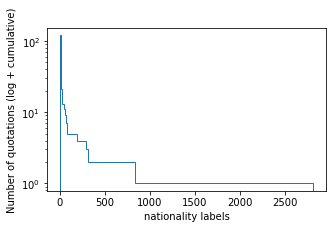

In [7]:
analyze_label('nationality', 20)

It seems that a grouping by continent might be the most relevant.

In [8]:
# Correcting errors in nationality

def replace_all(text, dic):
    for i, j in dic.items():
        text = text.replace(i, j)
    return text

dic_replace = {'The Bahamas': 'Bahamas','urkey': 'Turkey', 'TTTurkey': 'Turkey', 'TTurkey': 'Turkey', 'British India':'India', 'Imperial State of Iran':'Iran', 
               'Colony and Protectorate of Nigeria':'Nigeria', 'Scotland':'France', 'Northern Ireland':'Ireland', 'Soviet Union':'Russia', 'England':'France', 
               'Wales':'France', 'United Kingdom of Great Britain and Ireland':'Ireland', 'English':'France', 'Holland':'Netherlands', 'Republic of China (1912–1949)':'China',
              'Song dynasty':'China', 'Kingdom of France':'France', 'British Hong Kong':'Hong Kong', "People's Republic of Bulgaria":'Bulgaria', 'Vatican City':'Italy',
              'West Germany':'Germany', 'Qing dynasty':'China', 'Ming dynasty':'China', 'Siria':'Egypt', 'State of Palestine':'Egypt', 'Czechoslovakia':'France',
              'North America':'United States'}
metadata_about_sentiment['nationality'] = metadata_about_sentiment['nationality'].apply(lambda x: replace_all(x, dic_replace) if x is not None else None)


# Replace country nationality by continent nationality

continents = {
    'NA': 'NorthAmerica',
    'SA': 'SouthAmerica', 
    'AS': 'Asia',
    'OC': 'Australia',
    'AF': 'Africa',
    'EU': 'Europe'
}
metadata_about_sentiment['nationality'] = metadata_about_sentiment['nationality'].apply(lambda x: continents[country_alpha2_to_continent_code(country_name_to_country_alpha2(x))] if x is not None else None)

Total number of rows of the dataframe: 6476
Total number of rows with label: 5440


NorthAmerica    3191
Europe          1228
Asia             440
Australia        380
Africa           163
SouthAmerica      38
Name: nationality, dtype: int64

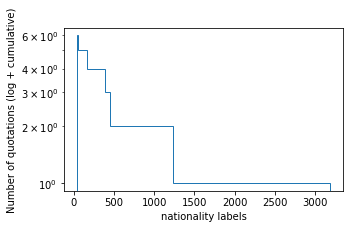

In [9]:
analyze_label('nationality', 10)

Total number of rows of the dataframe: 6476
Total number of rows with label: 6418


male                  5292
female                1110
transgender female       7
non-binary               6
cisgender female         1
genderfluid              1
transgender male         1
Name: gender, dtype: int64

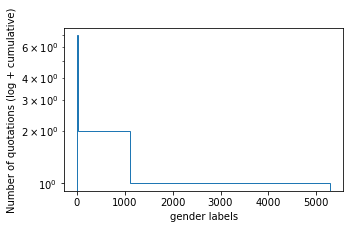

In [10]:
analyze_label('gender', 10)

We will make the choice to consider only the "male" and "female" gender for the following. The other genders, which are in the minority, will be considered as None.  
By the way, it is interesting to note the important difference in the number of citations between men and women.

In [11]:
# Keeping only male and female for the gender category

def rename_gender(gender):
    if gender in ['intersex', 'genderfluid', 'transgender male', 'non-binary', 'transgender person', 'transgender female', 'cisgender female']:
        return None
    else:
        return gender

metadata_about_sentiment['gender'] = metadata_about_sentiment['gender'].apply(lambda x: rename_gender(x) if x is not None else None)

Total number of rows of the dataframe: 6476
Total number of rows with label: 510


African Americans    288
Jewish people         32
Yoruba people         15
American Jews         14
Armenian American      9
Italian American       7
English people         7
Chibuze Family         6
Irish people           6
Britons                5
Name: ethnic_group, dtype: int64

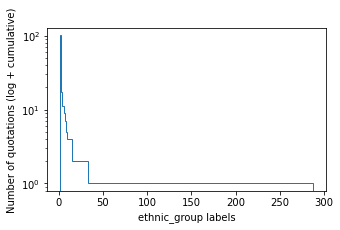

In [12]:
analyze_label('ethnic_group', 10)

There is a great diversity of labels and it seems that about forty labels are quite important. We will therefore group labels into sub-categories. We will do this only for labels with "Americans", the other labels will be renamed as None.

In [13]:
# Groupping labels of the ethnic_group category

def rename_ethnic(ethnic):
    if ethnic in ['Jamaican American',  'Kenyan Americans', 'African Americans', 'Somali American', 'Samoan American']:
        return 'AfricanAmerican'
    elif ethnic in ['Dutch American', 'Italian American', 'Ukrainian American', 'Caucasian', 'White Africans of European ancestry', 'Scottish American', 'Armenian American', 
                    'Hungarian American', 'Swedish American', 'White Americans', 'Danish Americans', 'Welsh American', 'Polish American', 'Czech American', 'Maltese American',
                    'Scotch-Irish Americans', 'Romanian Americans', 'Croatian American','Irish Americans', 'American Jews', 'English American']:
        return 'Caucasian'
    elif ethnic in ['Chinese American', 'Tamil American', 'Japanese American', 'Indian American', 'Lebanese American', 'South Asian American', 'Korean American', 'Pakistani American', 
                    'Vietnamese American', 'Turkish American']:
        return 'Asian'
    elif ethnic in ['Hispanic and Latino Americans','Mexican Americans', 'Cuban American', 'Venezuelan American']:
        return 'LatinoAmerican'
    else:
        return None

metadata_about_sentiment['ethnic_group'] = metadata_about_sentiment['ethnic_group'].apply(lambda x: rename_ethnic(x) if x is not None else None)

Total number of rows of the dataframe: 6476
Total number of rows with label: 351


AfricanAmerican    289
Caucasian           47
Asian               12
LatinoAmerican       3
Name: ethnic_group, dtype: int64

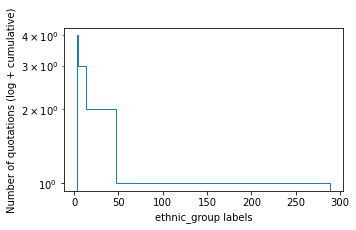

In [14]:
analyze_label('ethnic_group', 10)

It should be kept in mind for the rest of the analysis that the labelled population is relatively small for this category.

Total number of rows of the dataframe: 6476
Total number of rows with label: 6246


politician                          1061
actor                                308
journalist                           297
association football player          263
American football player             186
writer                               179
lawyer                               176
singer                               152
researcher                           119
cricketer                            115
musician                             112
composer                             110
basketball player                     99
baseball player                       99
ice hockey player                     88
film director                         75
economist                             66
jazz musician                         61
singer-songwriter                     58
businessperson                        58
diplomat                              57
historian                             54
Australian rules football player      53
painter                               53
rugby union play

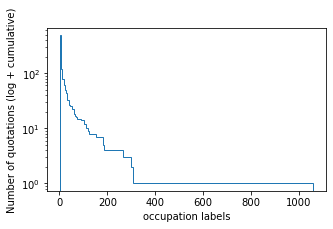

In [15]:
analyze_label('occupation', 30)

For the "occupation" category, out of 6246 labeled speakers, there are already 3 364 speakers represented by the 15 most present labels. So we choose to group in subcategories only the first labels in order to analyze this category. This seems to be a good compromise between time and accuracy of the analysis. The remaining labels will be replaced by None.

In [16]:
# Groupping labels of the occupation category

def rename_occupation(occupation):
    if occupation in ['journalist']:
        return 'Journalist'
    if occupation in ['association football player', 'American football player','cricketer', 'basketball player','baseball player', 'ice hockey player',
                      'Australian rules football player','rugby union player','rugby league player']:
        return 'Sport'
    if occupation in ['film director','actor','screenwriter']:
        return 'Cinema'
    if occupation in ['musician', 'composer', 'jazz musician', 'singer-songwriter','singer','painter','radio personality',' writer','author']:
        return 'OtherArts'
    if occupation in ['businessperson']:
        return 'Economics'
    if occupation in ['lawyer']:
        return 'Law'
    if occupation in ['researcher','historian','economist']:
        return 'Science'
    if occupation in ['politician','diplomat']:
        return 'Politics'
    if occupation in ['conductor']:
        return 'Conductor'
    else:
        return None

metadata_about_sentiment['occupation'] = metadata_about_sentiment['occupation'].apply(lambda x: rename_occupation(x) if x is not None else None)

Total number of rows of the dataframe: 6476
Total number of rows with label: 3963


Politics      1118
Sport          991
OtherArts      625
Cinema         421
Journalist     297
Science        239
Law            176
Economics       58
Conductor       38
Name: occupation, dtype: int64

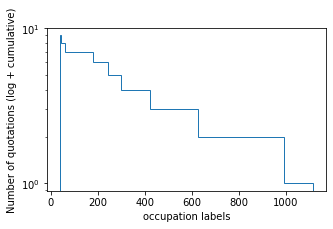

In [17]:
analyze_label('occupation', 30)

Total number of rows of the dataframe: 6476
Total number of rows with label: 1464


Republican Party                           399
Democratic Party                           386
Conservative Party                          46
Labour Party                                40
Indian National Congress                    33
Bharatiya Janata Party                      23
Australian Labor Party                      22
Peoples Democratic Party                    17
Conservative Party of Canada                12
Minnesota Democratic–Farmer–Labor Party     12
Name: party, dtype: int64

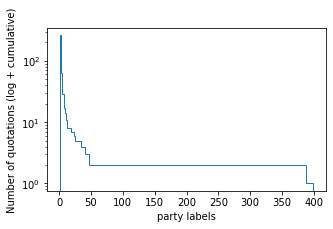

In [18]:
analyze_label('party', 10)

We will analyze only the Republican Party and the Democratic Party. The other labels will be replaced by None.

In [19]:
# Keeping only the Republican Party and the Democratic Party

def rename_party(party):
    if party in ['Republican Party', 'Democratic Party']:
        return party.replace(" ", "")
    else:
        return None

metadata_about_sentiment['party'] = metadata_about_sentiment['party'].apply(lambda x: rename_party(x) if x is not None else None)

Total number of rows of the dataframe: 6476
Total number of rows with label: 136


Bachelor of Arts                    26
Doctor of Philosophy                23
doctorate                           19
Juris Doctor                         8
bachelor's degree                    8
Doctor of Medicine                   6
Bachelor of Science                  5
PhD in Law                           4
Doktor Nauk in Political Science     3
Candidate of Economic Sciences       3
Name: academic_degree, dtype: int64

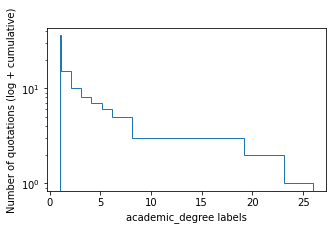

In [20]:
analyze_label('academic_degree', 10)

We will group according to degree level. However, given the small number of labels, it is possible that the analysis will be neither conclusive nor relevant...

In [21]:
# Groupping the labels of academic_degree in sub-categories

def rename_degree(degree):
    if degree in ['Bachelor of Arts', 'Bachelor of Science', 'Bachelor of Laws', "bachelor's degree"]:
        return 'Bachelor'
    if degree in ['Master of International Affairs', 'Master of Business Administration', 'Master of Fine Arts', 'Master of Arts', 'Master of Letters', 
                  'Master of Science', 'Master of Public Health', "master's degree"]:
        return 'Master'
    if degree in ['Doktor Nauk in Psychology', 'Juris Doctor', 'Doctor of Medicine', 'Doctor of Political Science', 'Doktor Nauk in Philosophy', 
                  'Doktor Nauk in Political Science', 'Doctor of Sciences', 'Doctor of Juridical Science', 'Doctor of Historical Sciences', 
                  'Doctor of Laws', 'Doctor of Humane Letters', 'Doctor of Philosophy', 'Doctor of Economics, doctorate', 'Doctor of Theology', 
                  'Doctor of both laws', 'doctor honoris causa', 'Doktor Nauk in Juridical Science']:
        return 'Doctor'
    if degree in ['PhD in economics', 'PhD in Law', 'PhD in Psychology']:
        return 'PhD'
    if degree in ['candidate of Sciences in Physics and Mathematics', 'Cand.polit.', 'Candidate of Historical Sciences', 'Candidate of Economic Sciences']:
        return 'Candidate'
    else:
        return None

metadata_about_sentiment['academic_degree'] = metadata_about_sentiment['academic_degree'].apply(lambda x: rename_degree(x) if x is not None else None)

Total number of rows of the dataframe: 6476
Total number of rows with label: 110


Doctor       52
Bachelor     40
Candidate     7
PhD           6
Master        5
Name: academic_degree, dtype: int64

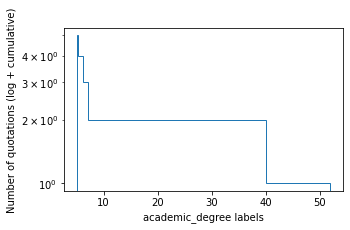

In [22]:
analyze_label('academic_degree', 10)

Total number of rows of the dataframe: 6476
Total number of rows with label: 701


Islam              80
Catholic Church    79
Catholicism        71
Judaism            60
atheism            54
Hinduism           45
Baptists           34
Christianity       28
Anglicanism        27
Presbyterianism    23
Name: religion, dtype: int64

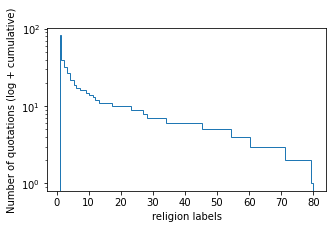

In [23]:
analyze_label('religion', 10)

We will group according to the religion. 

In [24]:
# Groupping the labels of academic_degree in sub-categories

def rename_religion(religion):
    if religion in ['Methodism', ' Church of England', 'Evangelical Church in Germany', 'evangelical church', 'Church of the Nazarene', 'Baptists', 
                  'Seventh-day Adventist Church', 'Unification Church', 'United Methodist Church', 'Church of God', 'Episcopal Church', 
                  'Antiochian Orthodox Christian Archdiocese of N...', 'Church of Christ', 'Roman Catholic', 'Orthodox Church of Ukraine', 'Christianity',
                  'Chaldean Catholic Church', 'Lutheranism', 'United Church of Christ', 'Southern Baptist Convention', 'Presbyterian Church in America', 
                  'Catholicism', 'Eastern Orthodox Church', 'African Methodist Episcopal Church', 'Assemblies of God', 'Latin Church', 'Lutheran Church-Missouri Synod',
                  'Mormon theology', 'Congregationalist polity', 'Evangelical', 'Church of Sleep', 'Russian Orthodox Church', 'Christian', 'United Church of Canada',
                  'Russian Orthodox Church in Ukraine', 'Church of Scotland', 'Catholic Church', 'Christian Science', 'Churches of Christ', 'Evangelical Lutheran Church',
                  'Nondenominational Christianity', 'apostasy in Catholicism', 'Evangelicalism', 'Pentecostalism', 'Eastern Orthodoxy', 'Evangelical Presbyterian Church',
                  'Greek Orthodox Church', 'Christian', 'Protestantism', 'The Church of Jesus Christ of Latter-day Saints', 'Presbyterianism', 'Georgian Orthodox Church',
                  'Greek Orthodox Church of Antioch', 'Free Presbyterian Church of Ulster', 'congregational church', 'Lapsed Catholic', 'Anglican Church in North America',
                  'Anglicanism']:
        return 'Chretien'
    if religion in ['Sunni Islam', 'Druze']:
        return 'Muslim'
    if religion in ['Judaism', 'Modern Orthodox Judaism', 'Jewish secularism', 'Islam', 'Reform Judaism']:
        return 'Jewish'
    if religion in ['Hindu', 'Hinduism']:
        return 'Indou'
    if religion in ['Buddhism', 'Nichiren Buddhism']:
        return 'Buddhist'
    if religion in ['humanism', 'irreligion', 'nontheism', 'agnostic theism', 'unbelief', 'agnosticism', 'agnostic atheism', 'atheist', 'atheism']:
        return 'AtheistAgnostic'
    else:
        return None

metadata_about_sentiment['religion'] = metadata_about_sentiment['religion'].apply(lambda x: rename_religion(x) if x is not None else None)

Total number of rows of the dataframe: 6476
Total number of rows with label: 673


Chretien           384
Jewish             143
AtheistAgnostic     68
Indou               47
Muslim              17
Buddhist            14
Name: religion, dtype: int64

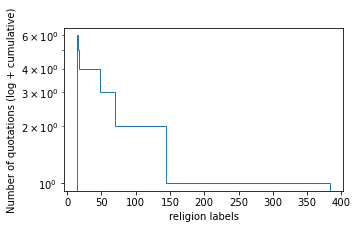

In [25]:
analyze_label('religion', 10)

The table about the speakers being fixed, we will add the feeling of the quotes of each speaker:

In [26]:
# Adding sentiments to metadata_about_sentiment_regression
Trump_about_sentiment['MainQids'] = Trump_about_sentiment.qids.apply(lambda x: x[0] if len(x) > 0 else None) # taking the Qids of the main speaker only
metadata_about_sentiment = pd.merge(metadata_about_sentiment,  Trump_about_sentiment[['FlairSentiment', 'FlairConfidence', 'Vader', 'VaderCompound', 'VaderSentiment', 'MainQids', 'date']], left_on = 'id', right_on='MainQids')  
metadata_about_sentiment

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,...,candidacy,type,religion,FlairSentiment,FlairConfidence,Vader,VaderCompound,VaderSentiment,MainQids,date
0,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],NorthAmerica,male,1395142029,None,None,Politics,RepublicanParty,None,...,"[Q327959, Q464075, Q3586276, Q4450587]",item,Chretien,NEGATIVE,0.708862,"{'neg': 0.091, 'neu': 0.842, 'pos': 0.067, 'co...",-0.1779,NEGATIVE,Q207,2015-06-09 19:57:02
1,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],NorthAmerica,male,1395142029,None,None,Politics,RepublicanParty,None,...,"[Q327959, Q464075, Q3586276, Q4450587]",item,Chretien,NEGATIVE,0.996700,"{'neg': 0.115, 'neu': 0.885, 'pos': 0.0, 'comp...",-0.4588,NEGATIVE,Q207,2016-07-20 02:14:14
2,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],NorthAmerica,male,1395142029,None,None,Politics,RepublicanParty,None,...,"[Q327959, Q464075, Q3586276, Q4450587]",item,Chretien,NEGATIVE,0.993322,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,POSITIVE,Q207,2017-11-16 00:00:00
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],NorthAmerica,male,1395142029,None,None,Politics,RepublicanParty,None,...,"[Q327959, Q464075, Q3586276, Q4450587]",item,Chretien,POSITIVE,0.999025,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,POSITIVE,Q207,2018-03-31 20:28:57
4,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],NorthAmerica,male,1395142029,None,None,Politics,RepublicanParty,None,...,"[Q327959, Q464075, Q3586276, Q4450587]",item,Chretien,NEGATIVE,0.999512,"{'neg': 0.034, 'neu': 0.891, 'pos': 0.075, 'co...",0.9518,POSITIVE,Q207,2018-10-23 17:00:41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9805,None,None,None,female,1217288455,None,None,Science,None,None,...,None,item,None,NEGATIVE,0.957788,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,POSITIVE,Q58488444,2018-02-03 07:00:57
9806,None,None,Europe,female,1341469398,None,None,None,None,None,...,None,item,None,NEGATIVE,0.999430,"{'neg': 0.119, 'neu': 0.853, 'pos': 0.028, 'co...",-0.5432,NEGATIVE,Q59143032,2019-09-24 23:03:00
9807,None,None,None,male,1382791097,None,None,Cinema,None,None,...,None,item,None,POSITIVE,0.974271,"{'neg': 0.0, 'neu': 0.763, 'pos': 0.237, 'comp...",0.8555,POSITIVE,Q59178218,2018-11-09 18:43:29
9808,None,[+1949-06-04T00:00:00Z],None,male,1324830701,None,None,None,None,None,...,None,item,None,POSITIVE,0.993633,"{'neg': 0.0, 'neu': 0.854, 'pos': 0.146, 'comp...",0.3400,POSITIVE,Q59610397,2018-04-27 21:07:31


#### 2.2.2) Analyzing sentiment according population    <a class="anchor" id="III.2.2.2"></a>

In [27]:
# Summary of categories and labels for analysis
for column in list_categories:
    print("{}: \n {}".format(column, metadata_about_sentiment[column].unique()))
    print("..............")

nationality: 
 ['NorthAmerica' 'Asia' 'Europe' 'Australia' 'Africa' None 'SouthAmerica']
..............
gender: 
 ['male' 'female' None]
..............
ethnic_group: 
 [None 'AfricanAmerican' 'Caucasian' 'Asian' 'LatinoAmerican']
..............
occupation: 
 ['Politics' None 'Sport' 'OtherArts' 'Cinema' 'Law' 'Science' 'Journalist'
 'Conductor' 'Economics']
..............
party: 
 ['RepublicanParty' None 'DemocraticParty']
..............
academic_degree: 
 [None 'Bachelor' 'Doctor' 'Master' 'PhD' 'Candidate']
..............
religion: 
 ['Chretien' 'Indou' None 'Buddhist' 'Muslim' 'Jewish' 'AtheistAgnostic']
..............


- **First, we will visualize the data graphically:**  

We will start by looking quantitatively with the Vader Compounds:

In [28]:
# Function for making Barplot of each category

def trace_barplots(Nx, Ny, Sx, Sy, Xaxis, Yaxis, df, title):
    '''Plotting figures with barplot
    Nx and Ny = number of plots
    Sx and Sy = figsize
    Xaxis = list of column names of df we want to plot
    Yaxis = column name for the Yaxis
    df = datagrame
    title = title of the figure'''

    fig, axs = plt.subplots(Nx,Ny, sharey=True, figsize=(Sx,Sy))
    axs = axs.flatten()

    for ax, col in zip(axs, Xaxis):

        # Calculate number of obs per group 
        nobs = df[col].value_counts().values
        nobs = [str(x) for x in nobs.tolist()]
        nobs = [i for i in nobs]

        # Plot    
        sns.barplot(x=col, y=Yaxis, data=df, ax=ax)

        # Add number of obs per group to the plot
        for i in range(len(nobs)):
            ax.annotate(nobs[i], xy = (i, -0.2), horizontalalignment='center')

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

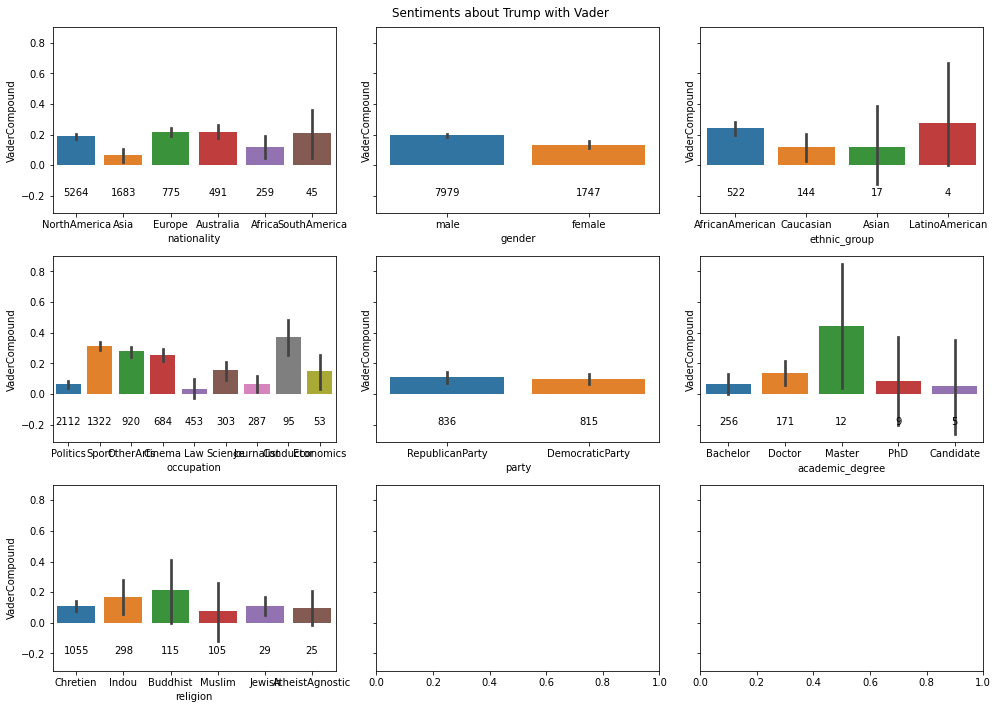

In [29]:
# Barplots with Vader
trace_barplots(3, 3, 14, 10, list_categories, 'VaderCompound', 
        metadata_about_sentiment, 
        "Sentiments about Trump with Vader")

Firstly, we can note that on average the feelings are all slightly towards the positive rather than the negative, and that there are no extremes. Two hypotheses can be put forward: either the feelings are extreme in the given category and thus the positive and negative compensate each other to give a more nuanced set, or the feelings are nuanced from the start.  
Nationality, gender and occupation seem to present differences in opinion about Trump. For nationality, countries in Europe, Australia, and North America are more supportive of Trump than those in Africa and Asia. For gender, it is males who are more supportive of Trump than females. For occupations, drivers, sports, and art are more favorable to Trump than politics, law, journalists, and science.   
For the party, there are no differences between Republicans and Democrats.  
For ethnic_group, academic_degree, and religion, there are no notable differences either, but this analysis is highly nuanced because the samples are not very large. However, we can note that the AfroAmericans have a more positive score than we could have expected. One hypothesis, however, could be that the people selected to speak in the newspapers are selected and therefore there is a bias in the starting bank. More generally, we expected negative results on Trump, which is not really the case here. This may be due to a bias in the algorithm chosen to analyze and we will therefore also look at Flair in the following. This may also be due to the source quotation and it would have been interesting to look more deeply into the type of quotations present in the database.

It is interesting to note also the differences in the number of citations between the labels. We can see in particular that the South America continent is largely under-represented compared to the others. Africa is also under-represented but in a less marked way. We can also see that there are clearly more quotes from men than from women, this is likely to be a bias in the starting citation bank.. On the other hand, in the case of parties, it is very well balanced. For the other categories, the numbers themselves are probably less interesting to compare because they are less "classical" data to obtain such as religion, and therefore the bias could be important from the start.

We will now see if their are some differences between "before" and "after" campaign :

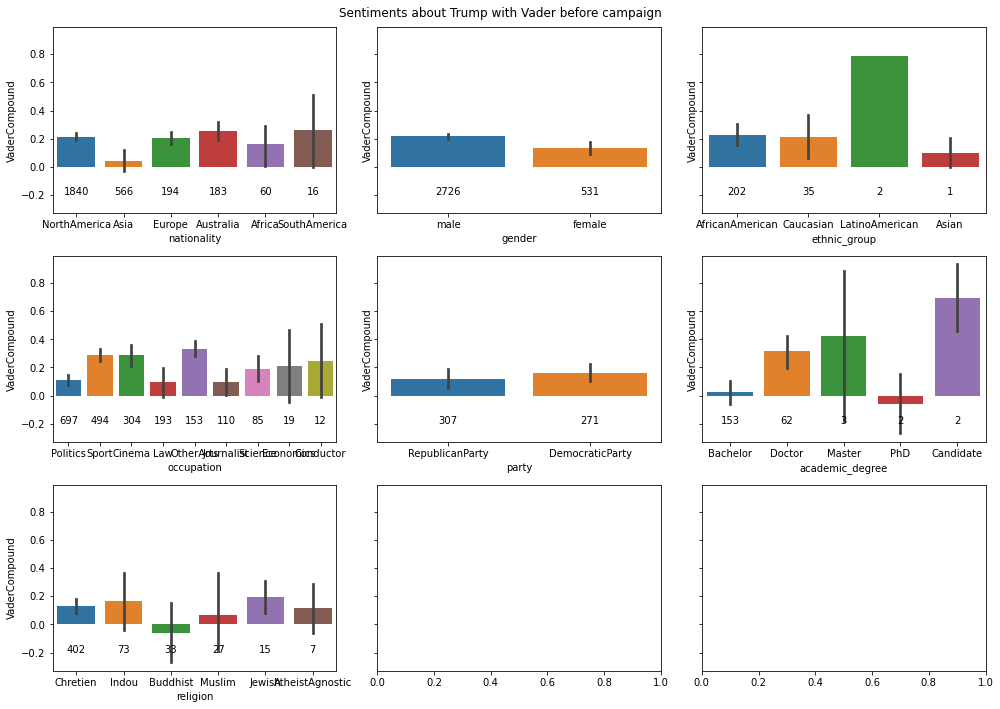

In [30]:
# Barplot with Vader before campaign
trace_barplots(3, 3, 14, 10, list_categories, 'VaderCompound', 
        metadata_about_sentiment[metadata_about_sentiment['date']<='2017-01-20'], 
        "Sentiments about Trump with Vader before campaign")

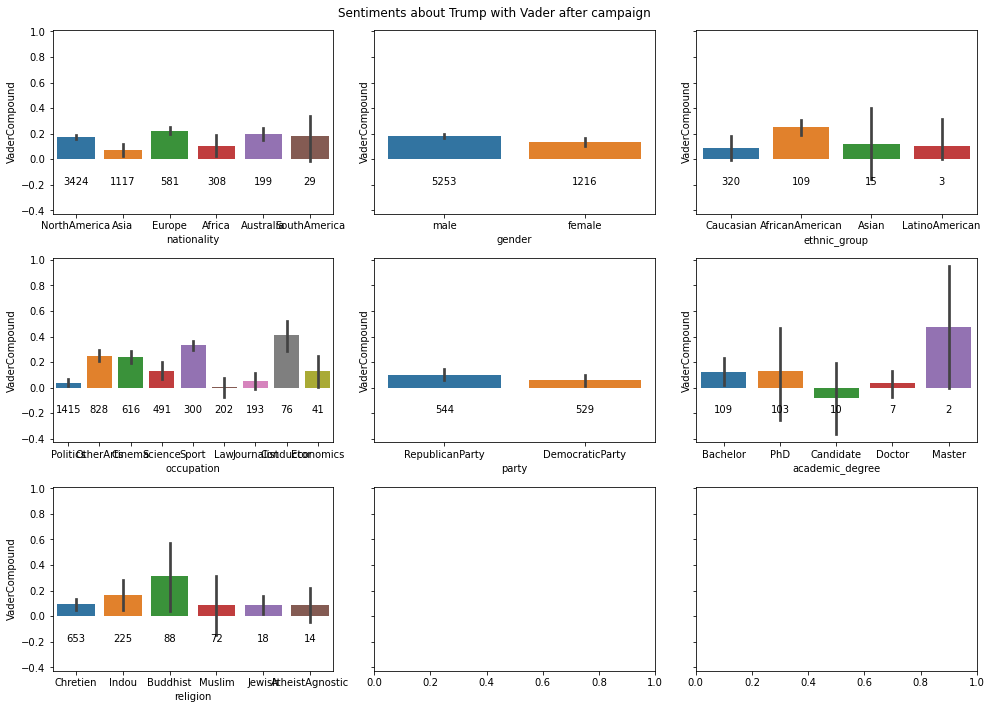

In [31]:
# Boxplots with Vader after campaign
trace_barplots(3, 3, 14, 10, list_categories, 'VaderCompound', 
        metadata_about_sentiment[metadata_about_sentiment['date']>'2017-01-20'], 
        "Sentiments about Trump with Vader after campaign")

Overall, we find the same conclusions as in the previous analysis, whether "before" or "after" the campaign, when comparing labels in each category.  
However, even if the differences between labels of a given category do not change between "before" and "after" the campaign, it is interesting to see if a given label varies over time:

<Figure size 1440x144 with 0 Axes>

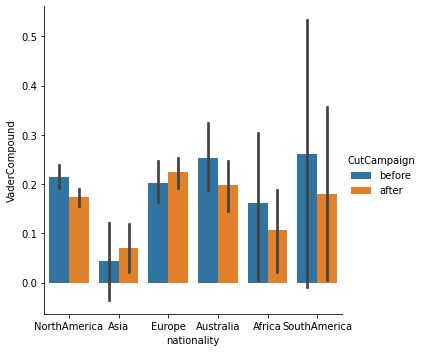

Number per category:


VaderCompound
nationality  CutCampaign               
Africa       after                  199
             before                  60
Asia         after                  581
             before                 194
Australia    after                  308
             before                 183
Europe       after                 1117
             before                 566
NorthAmerica after                 3424
             before                1840
SouthAmerica after                   29
             before                  16

.................... 
 



<Figure size 1440x144 with 0 Axes>

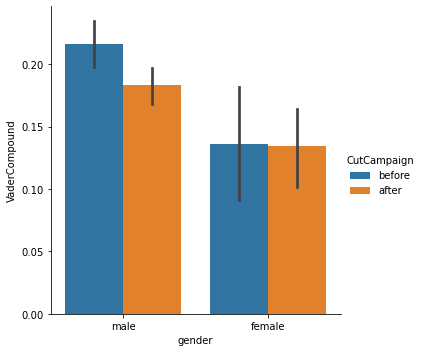

Number per category:


VaderCompound
gender CutCampaign               
female after                 1216
       before                 531
male   after                 5253
       before                2726

.................... 
 



<Figure size 1440x144 with 0 Axes>

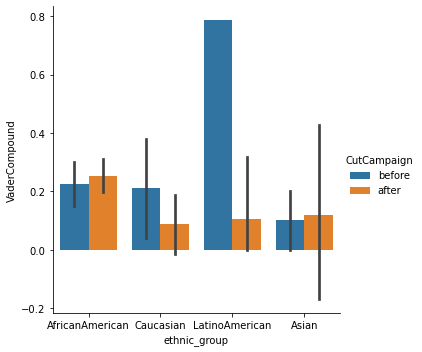

Number per category:


VaderCompound
ethnic_group    CutCampaign               
AfricanAmerican after                  320
                before                 202
Asian           after                   15
                before                   2
Caucasian       after                  109
                before                  35
LatinoAmerican  after                    3
                before                   1

.................... 
 



<Figure size 1440x144 with 0 Axes>

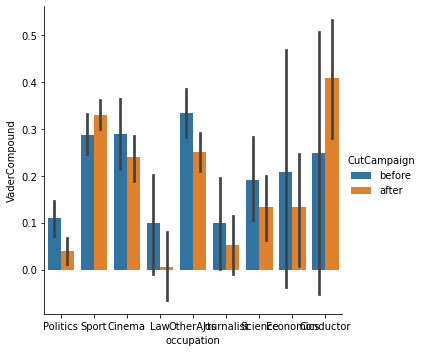

Number per category:


VaderCompound
occupation CutCampaign               
Cinema     after                  491
           before                 193
Conductor  after                   41
           before                  12
Economics  after                   76
           before                  19
Journalist after                  300
           before                 153
Law        after                  202
           before                  85
OtherArts  after                  616
           before                 304
Politics   after                 1415
           before                 697
Science    after                  193
           before                 110
Sport      after                  828
           before                 494

.................... 
 



<Figure size 1440x144 with 0 Axes>

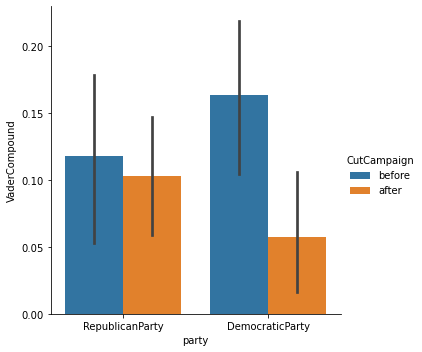

Number per category:


VaderCompound
party           CutCampaign               
DemocraticParty after                  529
                before                 307
RepublicanParty after                  544
                before                 271

.................... 
 



<Figure size 1440x144 with 0 Axes>

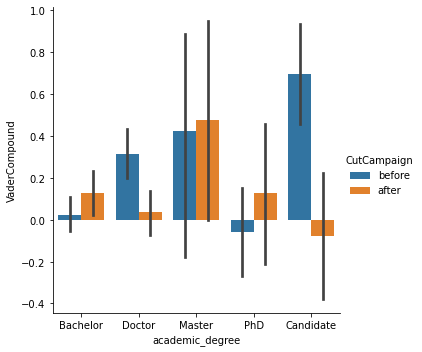

Number per category:


VaderCompound
academic_degree CutCampaign               
Bachelor        after                  103
                before                 153
Candidate       after                   10
                before                   2
Doctor          after                  109
                before                  62
Master          after                    2
                before                   3
PhD             after                    7
                before                   2

.................... 
 



<Figure size 1440x144 with 0 Axes>

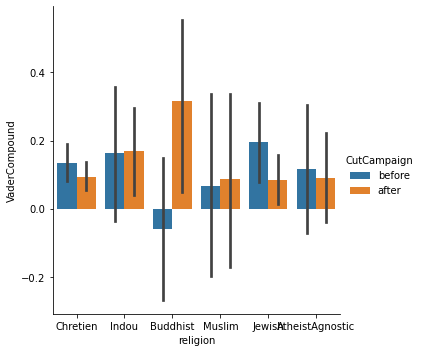

Number per category:


VaderCompound
religion        CutCampaign               
AtheistAgnostic after                   72
                before                  33
Buddhist        after                   18
                before                   7
Chretien        after                  653
                before                 402
Indou           after                   88
                before                  27
Jewish          after                  225
                before                  73
Muslim          after                   14
                before                  15

.................... 
 



In [32]:
# Function for making Catplot of each category with comparison before and after campaign

# Add column to separate before and after campaign
df_tmp1 = metadata_about_sentiment[metadata_about_sentiment['date']<='2017-01-20'].copy()
df_tmp1['CutCampaign'] = 'before'
df_tmp2 = metadata_about_sentiment[metadata_about_sentiment['date']>'2017-01-20'].copy()
df_tmp2['CutCampaign'] = 'after'
metadata_about_sentiment = pd.concat([df_tmp1, df_tmp2])

for category in list_categories:
    figure = plt.figure(figsize=(20,2))
    sns.catplot(x=category, y='VaderCompound', hue='CutCampaign', data=metadata_about_sentiment, kind="bar")
    plt.show()
    plt.close()
    print('Number per category:')
    display(pd.DataFrame(metadata_about_sentiment.groupby([category, 'CutCampaign'])['VaderCompound'].count()))
    print('.................... \n \n')

For nationality: we don't really see any difference between the two periods except maybe a slight decrease for North America.  
For gender: we don't really see differences for women, but men's opinions seem to be less positive.  
For ethnic_group, academic_degree and religion: no significant differences but again analysis limited by the number.  
For occupations: it is interesting to note a less positive opinion over time in politics.  
For parties: Republicans have a fairly consistent opinion while Republicans have a less positive opinion.  
=> In conclusion, either no change or less positive opinion toward Trump over time.  

If we also look at the numbers, we can notice that there are a lot more quotes about Trump after his campaign which seems pretty logical.  

We saw that opinion was still relatively nuanced. It is therefore interesting to see whether this is due to a very broad distribution of opinions that offset each other or to a nuanced opinion from the beginning:

In [33]:
# Function for making violinplot of each category

def trace_violinplots(Nx, Ny, Sx, Sy, Xaxis, Yaxis, df, title):
    '''Plotting figures with violinplots
    Nx and Ny = number of plots
    Sx and Sy = figsize
    Xaxis = list of column names of df we want to plot
    Yaxis = column name for the Yaxis
    df = datagrame
    title = title of the figure'''

    fig, axs = plt.subplots(Nx,Ny, sharey=True, figsize=(Sx,Sy))
    axs = axs.flatten()

    for ax, col in zip(axs, Xaxis):

        # Calculate number of obs per group & median to position labels
        medians = df.groupby([col])[Yaxis].median().values
        nobs = df[col].value_counts().values
        nobs = [str(x) for x in nobs.tolist()]
        nobs = [i for i in nobs]

        # Plot    
        sns.violinplot(x=col, y=Yaxis, data=df, ax=ax)

        # Add number of obs per group to the plot
        pos = range(len(nobs))
        for tick,label in zip(pos,ax.get_xticklabels()):
            ax.text(pos[tick],
                    medians[tick] + 0.03,
                    nobs[tick],
                    horizontalalignment='center',
                    size='small',
                    color='w',
                    weight='bold')

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

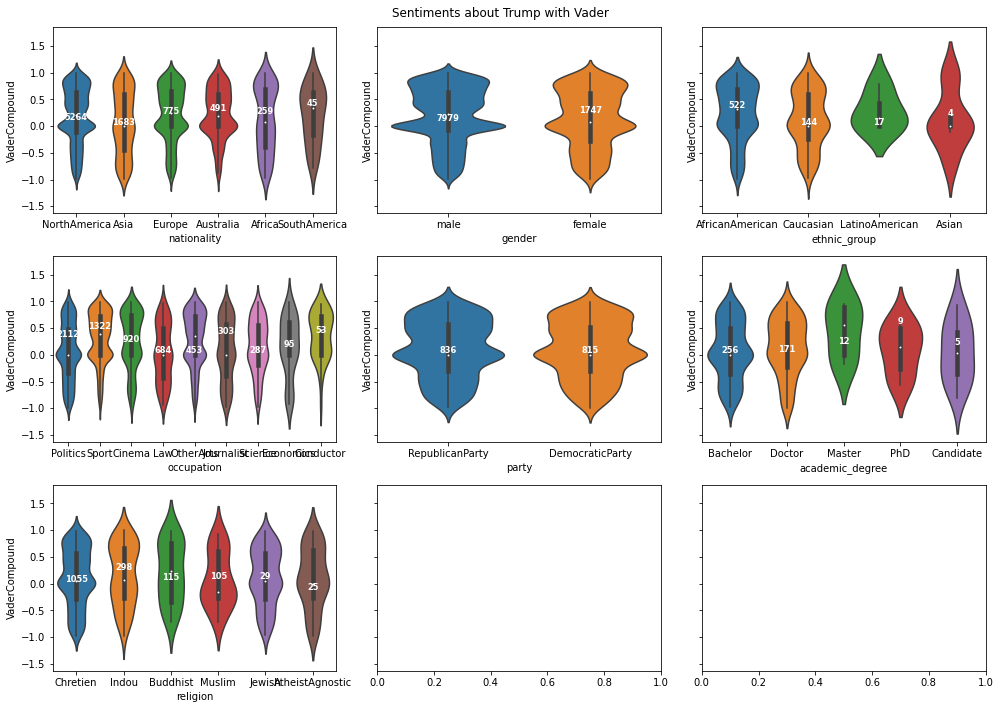

In [34]:
# Violinplots with Vader
trace_violinplots(3, 3, 14, 10, list_categories, 'VaderCompound', 
        metadata_about_sentiment, 
        "Sentiments about Trump with Vader")

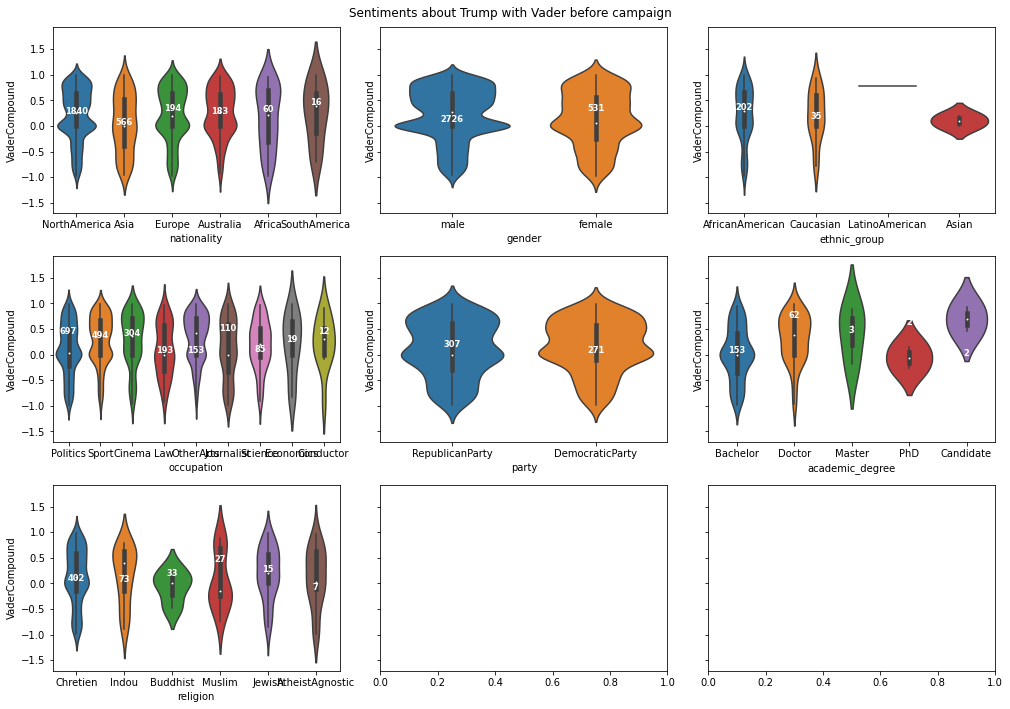

In [35]:
# Violinplots with Vader before campaign
trace_violinplots(3, 3, 14, 10, list_categories, 'VaderCompound', 
        metadata_about_sentiment[metadata_about_sentiment['date']<='2017-01-20'], 
        "Sentiments about Trump with Vader before campaign")

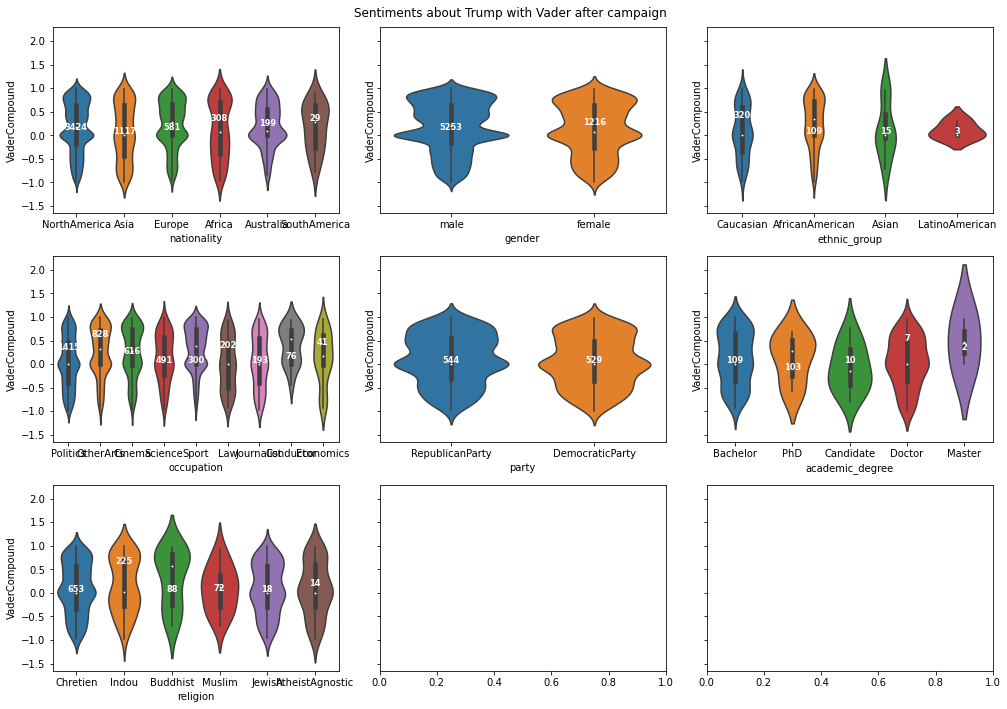

In [36]:
# Violinplots with Vader after campaign
trace_violinplots(3, 3, 14, 10, list_categories, 'VaderCompound', 
        metadata_about_sentiment[metadata_about_sentiment['date']>'2017-01-20'], 
        "Sentiments about Trump with Vader after campaign")

In general, we notice that feelings about Trump are widely dispersed between -1 and 1, showing great diversity. This is also the case when we distinguish between before and after the campaign.

Next, we'll look in a more binary way by just looking at the positive/negative results of Vader and Flair:  
In particular, we use Flair to compare with Vader to see if our results are robust.

In [37]:
# Function for making Barplot of each category with % of sentiment for Flair or Vader (binary outcome: positive or negative)

def trace_barplots_binary(Nx, Ny, Sx, Sy, Xaxis, AlgoSentiment, df):
    '''Plotting figures with barplot
    Nx and Ny = number of plots
    Sx and Sy = figsize
    Xaxis = list of column names of df we want to plot
    AlgoSentiment = 'FlairSentiment' or 'VaderSentiment'
    df = datagrame'''

    fig, axs = plt.subplots(Nx,Ny, sharey=True, figsize=(Sx,Sy))
    axs = axs.flatten()

    for ax, col in zip(axs, Xaxis):

        # Calculate % of obs per group 
        tmp1 = df.groupby([col, AlgoSentiment])['id'].count()
        df_tmp2 = pd.DataFrame(tmp1.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))).reset_index()

        # Plot    
        sns.barplot(x=col, y='id', data=df_tmp2[df_tmp2[AlgoSentiment]=='NEGATIVE'], ax=ax)
        ax.set_ylabel("% negative quotations")
        
        # Calculate number of obs per group 
        nobs = df[col].value_counts().values
        nobs = [str(x) for x in nobs.tolist()]
        nobs = [i for i in nobs]
        # Add number of obs per group to the plot
        for i in range(len(nobs)):
            text = "nTot= \n"+str(nobs[i])
            ax.annotate(text, xy = (i, 10), horizontalalignment='center')
 
    fig.suptitle('% of negative sentiments with '+ AlgoSentiment)
    plt.tight_layout()
    plt.show()

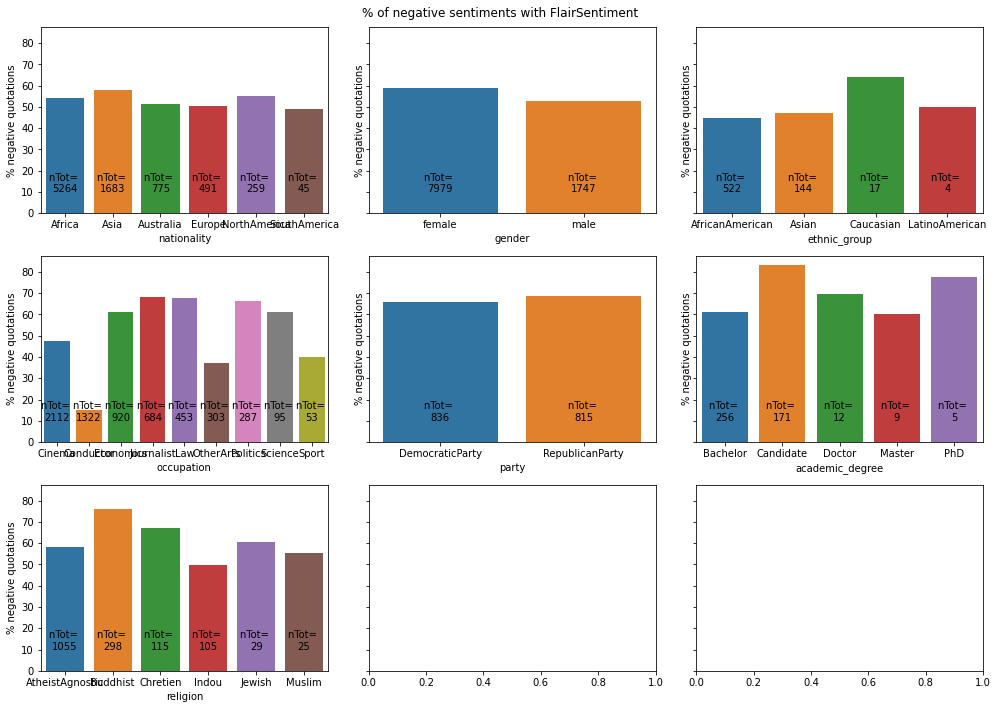

In [38]:
# Barplots with Flair
trace_barplots_binary(3, 3, 14, 10, list_categories, 'FlairSentiment', metadata_about_sentiment)

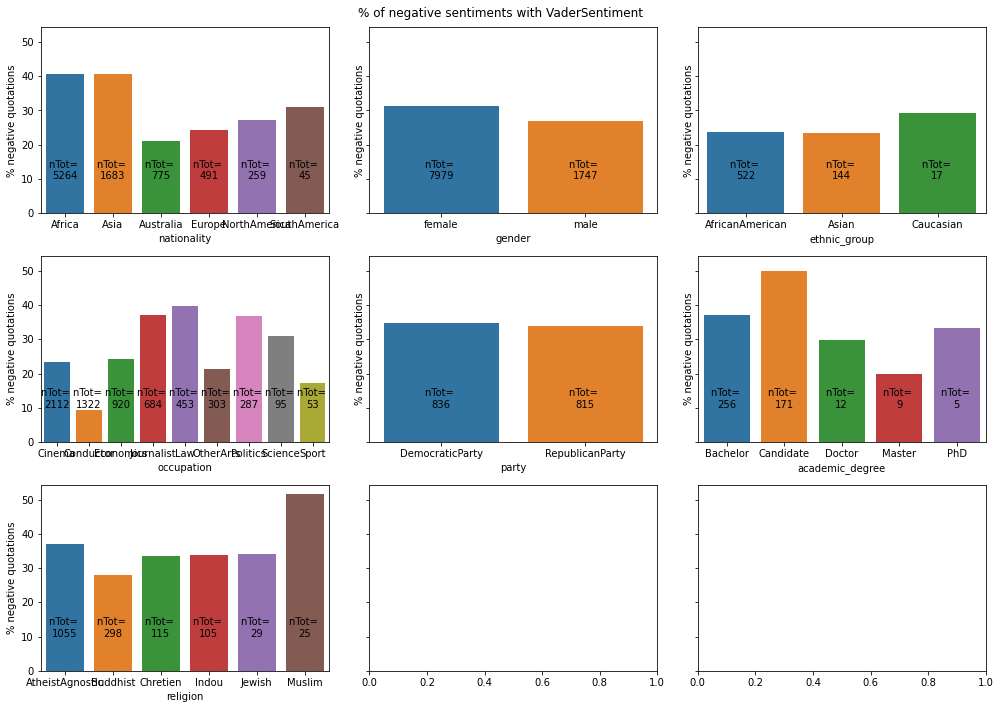

In [39]:
# Barplots with Vader
trace_barplots_binary(3, 3, 14, 10, list_categories, 'VaderSentiment', metadata_about_sentiment)

We see that globally we find the same results as before when we compare the labels for a given category, whether for Flair or for Vader. It is rather "reassuring" concerning the results.  
However, what is particularly interesting to note is that the results with Flair are much more negative than the results with Vader. This nuances our analysis with Vader where we said that overall the sentiment towards Trump was slightly positive. Vader is an algorithm that is rather optimized for social media data, whereas Flair is an algorithm trained on a dataset with larger topics (more specifically on IMDB dataset which is an online database of information related to films, television series, home videos, video games, and streaming content online - including cast, production crew and personal biographies, plot summaries, trivia, ratings, and fan and critical reviews). Moreover, Vader is a method that only cares about individual words and completely ignores the context in which it is used, whereas Flair has learned to take negations into account as well as intensifiers and OOV words, which is extremely interesting considering the type of data we deal with. One could therefore think that here the results obtained with Flair are more correct, and this is also more in line with what we expect to get about Trump.

On the same principle, we will look again at what we get by comparing before and after campaign:

In [94]:
# Function for making catplots of each category with % of sentiment for Flair or Vader (binary outcome: positive or negative) for before and after campaign

def trace_catplots_binary(Sx, Sy, Xaxis, AlgoSentiment, df):
    '''Plotting figure with catplot
    Sx and Sy = figsize
    Xaxis = column name of df we want to plot
    AlgoSentiment = 'FlairSentiment' or 'VaderSentiment'
    df = dataframe
    '''

    figure = plt.figure(figsize=(Sx,Sy))

    # Calculate number of obs per group 
    tmp1_before = df[df['CutCampaign']=='before'].groupby([Xaxis, AlgoSentiment])['id'].count()
    df_tmp2_before = pd.DataFrame(tmp1_before.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))).reset_index()
    df_tmp2_before['CutCampaign'] = 'before'
    tmp1_after = df[df['CutCampaign']=='after'].groupby([Xaxis, AlgoSentiment])['id'].count()
    df_tmp2_after = pd.DataFrame(tmp1_after.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))).reset_index()
    df_tmp2_after['CutCampaign'] = 'after'
    df_tmp2_tot = pd.concat([df_tmp2_before, df_tmp2_after]).reset_index(drop=True)

    # Plot    
    sns.catplot(x=Xaxis, y='id', hue='CutCampaign', data=df_tmp2_tot[df_tmp2_tot[AlgoSentiment]=='NEGATIVE'], kind="bar", hue_order=['before','after'])
    plt.ylabel("% of negative quotations")

    plt.show()

<Figure size 504x360 with 0 Axes>

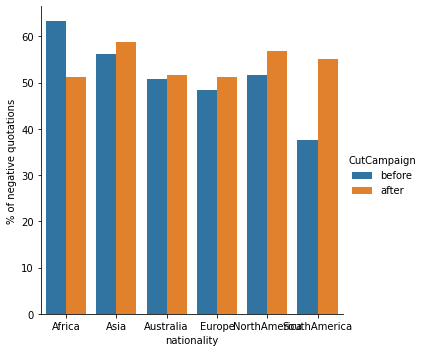

<Figure size 504x360 with 0 Axes>

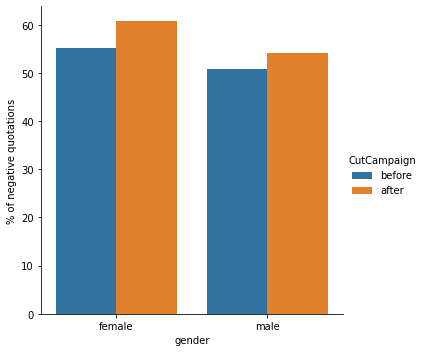

<Figure size 504x360 with 0 Axes>

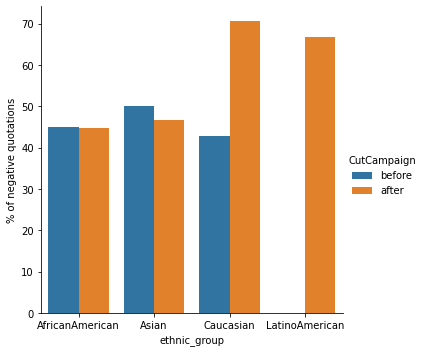

<Figure size 504x360 with 0 Axes>

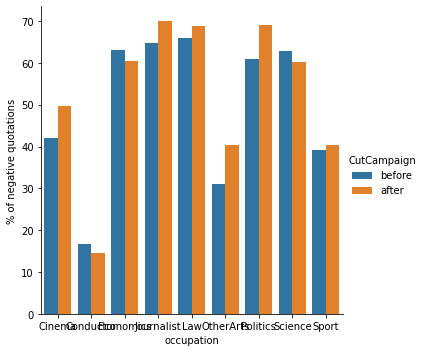

<Figure size 504x360 with 0 Axes>

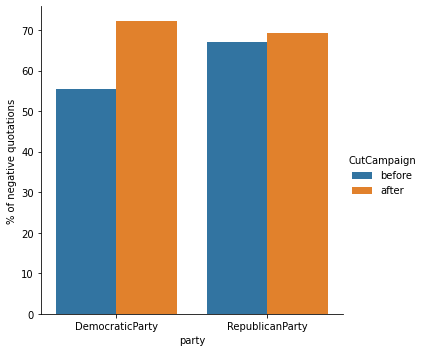

<Figure size 504x360 with 0 Axes>

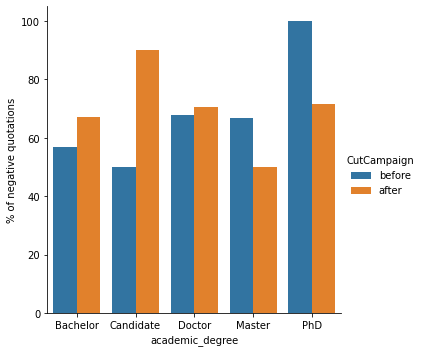

<Figure size 504x360 with 0 Axes>

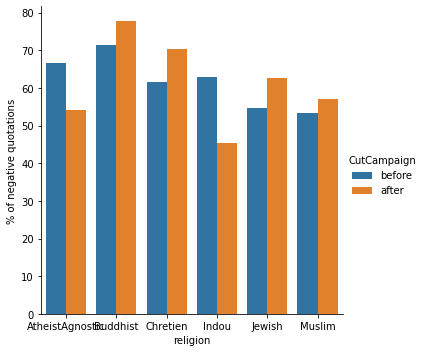

In [95]:
# Catplots for Flair
for category in list_categories:
    trace_catplots_binary(7, 5, category, 'FlairSentiment', metadata_about_sentiment)    

<Figure size 504x360 with 0 Axes>

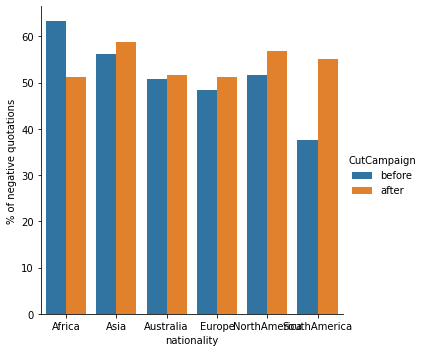

<Figure size 504x360 with 0 Axes>

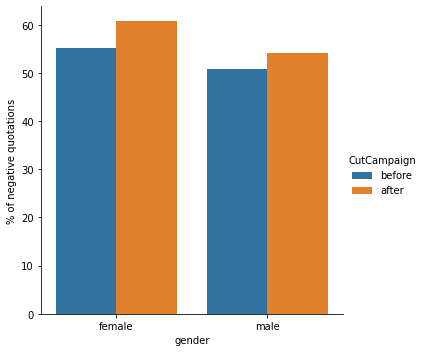

<Figure size 504x360 with 0 Axes>

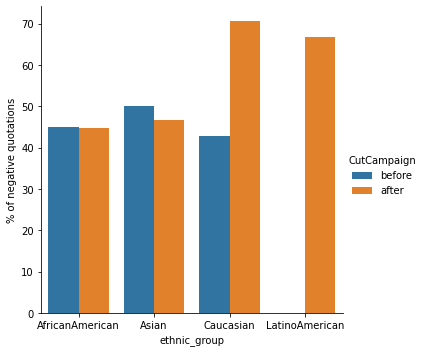

<Figure size 504x360 with 0 Axes>

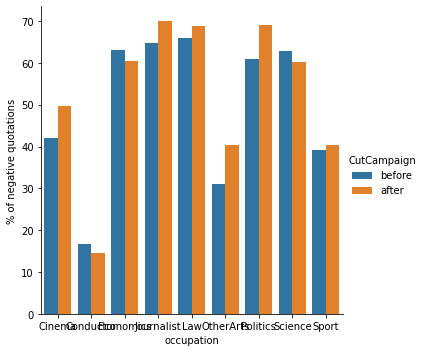

<Figure size 504x360 with 0 Axes>

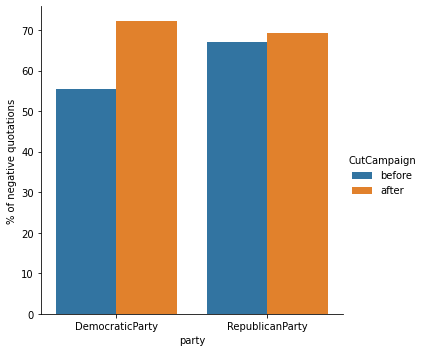

<Figure size 504x360 with 0 Axes>

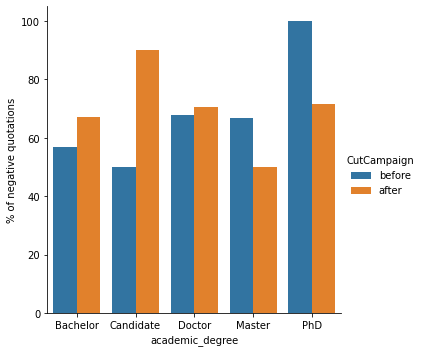

<Figure size 504x360 with 0 Axes>

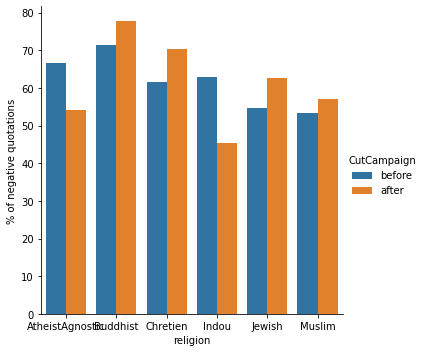

In [96]:
# Catplots for Vader
for category in list_categories:
    trace_catplots_binary(7, 5, category, 'FlairSentiment', metadata_about_sentiment)    

The results are about the same as before and there is a good consistency between the results of Flair and Vader when comparing the labels. However, it should be kept in mind that here there is no error bars, which complicates the analysis.

- **Secondly, we will study the influence of the categories using a regression:**

In this section, we will not look at the ethnic_group, religion, and academic_degree categories because the graphs showed that their analysis was not particularly relevant.

We will start by looking quantitatively with the Vader Compounds:

In [97]:
# Format the dataframe to do a regression with nationality, gender, ethnic_group, occupation, party, academic_degree and religion
metadata_about_sentiment_regression = metadata_about_sentiment.copy()
metadata_about_sentiment_regression = pd.get_dummies(metadata_about_sentiment_regression, columns= ['nationality', 'ethnic_group', 'occupation', 'academic_degree', 'religion'])
metadata_about_sentiment_regression['gender'] = metadata_about_sentiment_regression.gender.map({'female':1, 'male':0})
metadata_about_sentiment_regression['party'] = metadata_about_sentiment_regression.party.map({'RepublicanParty':1, 'DemocraticParty':0})
metadata_about_sentiment_regression

,aliases,date_of_birth,gender,lastrevid,US_congress_bio_ID,party,id,label,candidacy,type,...,academic_degree_Candidate,academic_degree_Doctor,academic_degree_Master,academic_degree_PhD,religion_AtheistAgnostic,religion_Buddhist,religion_Chretien,religion_Indou,religion_Jewish,religion_Muslim
0,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],0.0,1395142029,None,1.0,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,...,0,0,0,0,0,0,1,0,0,0
1,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],0.0,1395142029,None,1.0,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,...,0,0,0,0,0,0,1,0,0,0
5,"[Namo, Modi, Narendra Bhai, Narendra Damodarda...",[+1950-09-17T00:00:00Z],0.0,1395415052,None,NaN,Q1058,Narendra Modi,"[Q63988227, Q63988919, Q16841231, Q16251961, Q...",item,...,0,0,0,0,0,0,0,1,0,0
15,[Ashton James Eaton],[+1988-01-21T00:00:00Z],0.0,1395347414,None,NaN,Q1789,Ashton Eaton,None,item,...,0,0,0,0,0,0,0,0,0,0
16,[Michel François Platini],[+1955-06-21T00:00:00Z],0.0,1389743756,None,NaN,Q4261,Michel Platini,None,item,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9803,None,None,NaN,1266795252,None,NaN,Q57987917,Jo Barnes,None,item,...,0,0,0,0,0,0,0,0,0,0
9805,None,None,1.0,1217288455,None,NaN,Q58488444,Rachel Goodwin,None,item,...,0,0,0,0,0,0,0,0,0,0
9806,None,None,1.0,1341469398,None,NaN,Q59143032,Beth Jones,None,item,...,0,0,0,0,0,0,0,0,0,0
9807,None,None,0.0,1382791097,None,NaN,Q59178218,Bryan Wynbrandt,None,item,...,0,0,0,0,0,0,0,0,0,0


In [98]:
# Function for logistic regression

def regression(sentiment, categorie):
    '''Doing linear regression and getting the plot for coefficients
    sentiment = column name for the sentiment (string)
    categorie = name of the categorie (string) and the regression will be done with its labels'''
    
    # Formula
    if categorie in ['nationality', 'ethnic_group', 'occupation', 'academic_degree', 'religion']:
        formula = sentiment + " ~ " + ' + '.join(["C("+categorie+"_"+x+")" for x in metadata_about_sentiment[categorie].unique() if x is not None])
    else:
        formula = sentiment + " ~ " + "C(" + categorie + ")"
    
    # Linear regression
    print("\n Linear regression:" + formula + "\n")
    mod = smf.ols(formula=formula, data=metadata_about_sentiment_regression)
    res = mod.fit()
    print(res.summary())
    
    # getting results
    variables = res.params.index # feature names
    coefficients = res.params.values # coefficients
    p_values = res.pvalues # p-values
    standard_errors = res.bse.values # standard errors
    print("\n \n Confidence intervals:")
    display(res.conf_int()) #confidence intervals
    
    #sort them all by coefficients
    l1, l2, l3, l4 = zip(*sorted(zip(coefficients[1:], variables[1:], standard_errors[1:], p_values[1:])))
    
    # plotting them
    print("\n Coefficients:")
    plt.errorbar(l1, np.array(range(len(l1))), xerr= 2*np.array(l3), linewidth = 1,
                 linestyle = 'none',marker = 'o',markersize= 3,
                 markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)
    plt.vlines(0,0, len(l1), linestyle = '--')
    plt.yticks(range(len(l2)),l2);


 Linear regression:VaderCompound ~ C(nationality_NorthAmerica) + C(nationality_Asia) + C(nationality_Europe) + C(nationality_Australia) + C(nationality_Africa) + C(nationality_SouthAmerica)

                            OLS Regression Results                            
Dep. Variable:          VaderCompound   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     9.301
Date:                Thu, 16 Dec 2021   Prob (F-statistic):           3.41e-10
Time:                        20:42:25   Log-Likelihood:                -7577.5
No. Observations:                9810   AIC:                         1.517e+04
Df Residuals:                    9803   BIC:                         1.522e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  

,0,1
Intercept,0.175935,0.233072
C(nationality_NorthAmerica)[T.1],-0.048499,0.015270
C(nationality_Asia)[T.1],-0.187211,-0.093878
C(nationality_Europe)[T.1],-0.025286,0.050692
C(nationality_Australia)[T.1],-0.040076,0.068834
C(nationality_Africa)[T.1],-0.154620,-0.014755
C(nationality_SouthAmerica)[T.1],-0.151185,0.160370



 Coefficients:


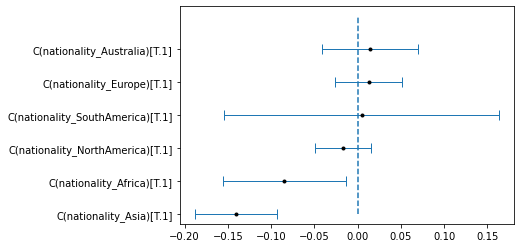

In [45]:
regression('VaderCompound', 'nationality')


 Linear regression:VaderCompound ~ C(gender)

                            OLS Regression Results                            
Dep. Variable:          VaderCompound   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     18.46
Date:                Thu, 16 Dec 2021   Prob (F-statistic):           1.75e-05
Time:                        20:42:26   Log-Likelihood:                -7534.1
No. Observations:                9726   AIC:                         1.507e+04
Df Residuals:                    9724   BIC:                         1.509e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

,0,1
Intercept,0.183215,0.206260
C(gender)[T.1.0],-0.086776,-0.032401



 Coefficients:


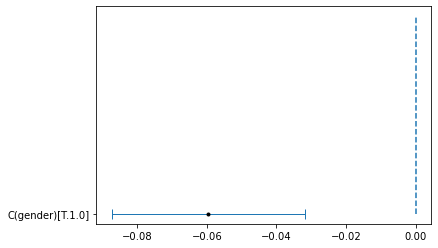

In [46]:
regression('VaderCompound', 'gender')


 Linear regression:VaderCompound ~ C(occupation_Politics) + C(occupation_Sport) + C(occupation_Cinema) + C(occupation_Law) + C(occupation_OtherArts) + C(occupation_Journalist) + C(occupation_Science) + C(occupation_Economics) + C(occupation_Conductor)

                            OLS Regression Results                            
Dep. Variable:          VaderCompound   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     33.65
Date:                Thu, 16 Dec 2021   Prob (F-statistic):           5.72e-59
Time:                        20:42:26   Log-Likelihood:                -7456.1
No. Observations:                9810   AIC:                         1.493e+04
Df Residuals:                    9800   BIC:                         1.500e+04
Df Model:                           9                                         
Covariance Type:            nonrobu

,0,1
Intercept,0.183647,0.217562
C(occupation_Politics)[T.1],-0.165959,-0.110275
C(occupation_Sport)[T.1],0.081071,0.146386
C(occupation_Cinema)[T.1],0.011510,0.096200
C(occupation_Law)[T.1],-0.229752,-0.105242
C(occupation_OtherArts)[T.1],0.040221,0.115238
C(occupation_Journalist)[T.1],-0.183924,-0.082715
C(occupation_Science)[T.1],-0.107123,0.014304
C(occupation_Economics)[T.1],-0.157915,0.053057
C(occupation_Conductor)[T.1],0.031160,0.311997



 Coefficients:


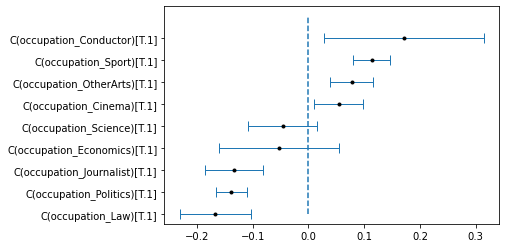

In [47]:
regression('VaderCompound', 'occupation')


 Linear regression:VaderCompound ~ C(party)

                            OLS Regression Results                            
Dep. Variable:          VaderCompound   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1890
Date:                Thu, 16 Dec 2021   Prob (F-statistic):              0.664
Time:                        20:42:26   Log-Likelihood:                -1293.0
No. Observations:                1651   AIC:                             2590.
Df Residuals:                    1649   BIC:                             2601.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

,0,1
Intercept,0.060724,0.132608
C(party)[T.1.0],-0.039818,0.062494



 Coefficients:


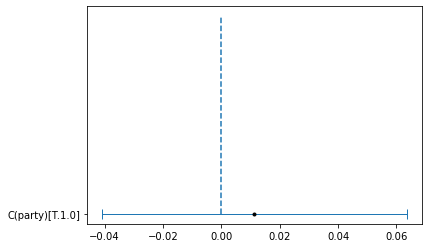

In [48]:
regression('VaderCompound', 'party')

We can see that the results concerning the coefficients are well in line with what we observed with the graphs. However, the regression shows that our conclusions must be greatly nuanced because the R squares are very low (which means that the labels explain only a small part of the variability) and that the p-values are relatively high, which suggests that the differences between the labels are not really significants.

Next, we'll look in a more binary way by just looking at the positive/negative results of Vader and Flair (We'll continue to look with both types of sentiment analysis to see if the results are fairly robust or not.):

In [49]:
# Format DataFrame to do regression
metadata_about_sentiment_regression['FlairSentiment'] = metadata_about_sentiment_regression.FlairSentiment.map({'POSITIVE':1, 'NEGATIVE':0})
metadata_about_sentiment_regression['VaderSentiment'] = metadata_about_sentiment_regression.VaderSentiment.map({'POSITIVE':1, 'NEGATIVE':0})

In [50]:
# Function for logistic regression with binary outcome

def regression_binary(sentiment, categorie):
    '''Doing linear regression and getting the plot for coefficients
    sentiment = column name for the sentiment (string) : 'FlairSentiment' or 'VaderSentiment'
    categorie = name of the categorie (string) and the regression will be done with its labels'''
    
    # Formula
    if categorie in ['nationality', 'ethnic_group', 'occupation', 'academic_degree', 'religion']:
        formula = sentiment + " ~ " + ' + '.join(["C("+categorie+"_"+x+")" for x in metadata_about_sentiment[categorie].unique() if x is not None])
    else:
        formula = sentiment + " ~ " + "C(" + categorie + ")"
    
    # Linear regression
    print("\n Linear regression:" + formula + "\n")
    mod = smf.logit(formula=formula, data=metadata_about_sentiment_regression)
    res = mod.fit()
    print(res.summary())
    
    # getting results
    variables = res.params.index # feature names
    coefficients = res.params.values # coefficients
    p_values = res.pvalues # p-values
    standard_errors = res.bse.values # standard errors
    print("\n \n Confidence intervals:")
    display(res.conf_int()) #confidence intervals
    
    #sort them all by coefficients
    l1, l2, l3, l4 = zip(*sorted(zip(coefficients[1:], variables[1:], standard_errors[1:], p_values[1:])))
    
    # plotting them
    print("\n Coefficients:")
    plt.errorbar(l1, np.array(range(len(l1))), xerr= 2*np.array(l3), linewidth = 1,
                 linestyle = 'none',marker = 'o',markersize= 3,
                 markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)
    plt.vlines(0,0, len(l1), linestyle = '--')
    plt.yticks(range(len(l2)),l2);


 Linear regression:FlairSentiment ~ C(nationality_NorthAmerica) + C(nationality_Asia) + C(nationality_Europe) + C(nationality_Australia) + C(nationality_Africa) + C(nationality_SouthAmerica)

Optimization terminated successfully.
         Current function value: 0.688976
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:         FlairSentiment   No. Observations:                 9810
Model:                          Logit   Df Residuals:                     9803
Method:                           MLE   Df Model:                            6
Date:                Thu, 16 Dec 2021   Pseudo R-squ.:                0.001412
Time:                        20:42:26   Log-Likelihood:                -6758.9
converged:                       True   LL-Null:                       -6768.4
Covariance Type:            nonrobust   LLR p-value:                  0.003981
                                       coef    std err          z      P>

,0,1
Intercept,-0.237799,-0.019322
C(nationality_NorthAmerica)[T.1],-0.195484,0.048500
C(nationality_Asia)[T.1],-0.381905,-0.022422
C(nationality_Europe)[T.1],-0.029644,0.260621
C(nationality_Australia)[T.1],-0.132371,0.283561
C(nationality_Africa)[T.1],-0.301640,0.233723
C(nationality_SouthAmerica)[T.1],-0.421601,0.767625



 Coefficients:


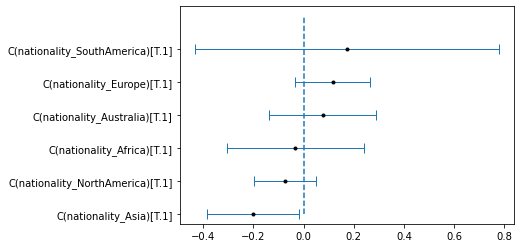

In [51]:
# With Flair
regression_binary('FlairSentiment', 'nationality')


 Linear regression:VaderSentiment ~ C(nationality_NorthAmerica) + C(nationality_Asia) + C(nationality_Europe) + C(nationality_Australia) + C(nationality_Africa) + C(nationality_SouthAmerica)

Optimization terminated successfully.
         Current function value: 0.583434
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:         VaderSentiment   No. Observations:                 9810
Model:                          Logit   Df Residuals:                     9803
Method:                           MLE   Df Model:                            6
Date:                Thu, 16 Dec 2021   Pseudo R-squ.:                0.009254
Time:                        20:42:27   Log-Likelihood:                -5723.5
converged:                       True   LL-Null:                       -5777.0
Covariance Type:            nonrobust   LLR p-value:                 8.990e-21
                                       coef    std err          z      P>

,0,1
Intercept,0.977735,1.229815
C(nationality_NorthAmerica)[T.1],-0.264120,0.015617
C(nationality_Asia)[T.1],-0.915994,-0.534249
C(nationality_Europe)[T.1],-0.132610,0.203928
C(nationality_Australia)[T.1],-0.040240,0.460757
C(nationality_Africa)[T.1],-0.999020,-0.442545
C(nationality_SouthAmerica)[T.1],-0.952424,0.334734



 Coefficients:


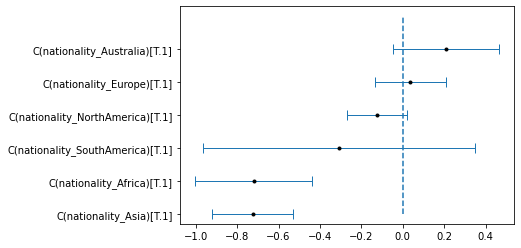

In [52]:
# With Vader
regression_binary('VaderSentiment', 'nationality')


 Linear regression:FlairSentiment ~ C(gender)

Optimization terminated successfully.
         Current function value: 0.688719
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:         FlairSentiment   No. Observations:                 9726
Model:                          Logit   Df Residuals:                     9724
Method:                           MLE   Df Model:                            1
Date:                Thu, 16 Dec 2021   Pseudo R-squ.:                0.001607
Time:                        20:42:27   Log-Likelihood:                -6698.5
converged:                       True   LL-Null:                       -6709.3
Covariance Type:            nonrobust   LLR p-value:                 3.412e-06
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.1192      0.022     -5.31

,0,1
Intercept,-0.163165,-0.075242
C(gender)[T.1.0],-0.352781,-0.142755



 Coefficients:


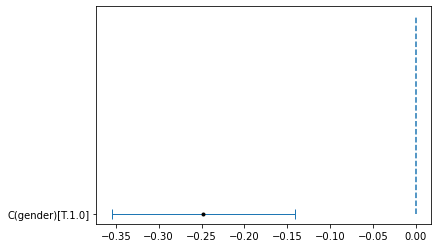

In [53]:
# With Flair
regression_binary('FlairSentiment', 'gender')


 Linear regression:VaderSentiment ~ C(gender)

Optimization terminated successfully.
         Current function value: 0.588711
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:         VaderSentiment   No. Observations:                 9726
Model:                          Logit   Df Residuals:                     9724
Method:                           MLE   Df Model:                            1
Date:                Thu, 16 Dec 2021   Pseudo R-squ.:                0.001161
Time:                        20:42:27   Log-Likelihood:                -5725.8
converged:                       True   LL-Null:                       -5732.5
Covariance Type:            nonrobust   LLR p-value:                 0.0002641
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.0025      0.025     39.68

,0,1
Intercept,0.952964,1.051990
C(gender)[T.1.0],-0.324197,-0.098844



 Coefficients:


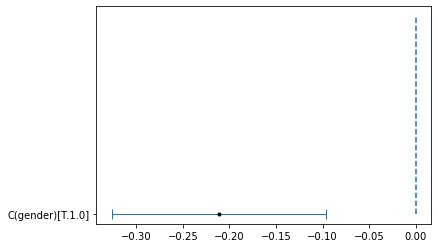

In [54]:
# With Vader
regression_binary('VaderSentiment', 'gender')


 Linear regression:FlairSentiment ~ C(occupation_Politics) + C(occupation_Sport) + C(occupation_Cinema) + C(occupation_Law) + C(occupation_OtherArts) + C(occupation_Journalist) + C(occupation_Science) + C(occupation_Economics) + C(occupation_Conductor)

Optimization terminated successfully.
         Current function value: 0.666658
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:         FlairSentiment   No. Observations:                 9810
Model:                          Logit   Df Residuals:                     9800
Method:                           MLE   Df Model:                            9
Date:                Thu, 16 Dec 2021   Pseudo R-squ.:                 0.03376
Time:                        20:42:40   Log-Likelihood:                -6539.9
converged:                       True   LL-Null:                       -6768.4
Covariance Type:            nonrobust   LLR p-value:                 9.143e-93
           

,0,1
Intercept,-0.238758,-0.107257
C(occupation_Politics)[T.1],-0.616921,-0.393601
C(occupation_Sport)[T.1],0.449667,0.706018
C(occupation_Cinema)[T.1],0.108665,0.436345
C(occupation_Law)[T.1],-0.834675,-0.321731
C(occupation_OtherArts)[T.1],0.548769,0.846773
C(occupation_Journalist)[T.1],-0.798923,-0.382117
C(occupation_Science)[T.1],-0.516752,-0.036575
C(occupation_Economics)[T.1],-0.694104,0.141069
C(occupation_Conductor)[T.1],1.145331,2.655127



 Coefficients:


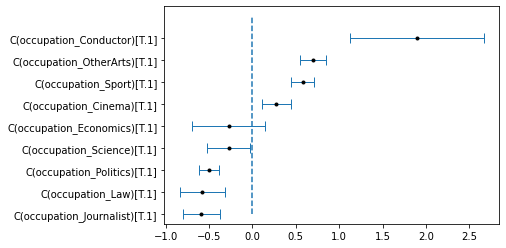

In [57]:
# With Flair
regression_binary('FlairSentiment', 'occupation')


 Linear regression:VaderSentiment ~ C(occupation_Politics) + C(occupation_Sport) + C(occupation_Cinema) + C(occupation_Law) + C(occupation_OtherArts) + C(occupation_Journalist) + C(occupation_Science) + C(occupation_Economics) + C(occupation_Conductor)

Optimization terminated successfully.
         Current function value: 0.576376
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:         VaderSentiment   No. Observations:                 9810
Model:                          Logit   Df Residuals:                     9800
Method:                           MLE   Df Model:                            9
Date:                Thu, 16 Dec 2021   Pseudo R-squ.:                 0.02124
Time:                        20:42:41   Log-Likelihood:                -5654.3
converged:                       True   LL-Null:                       -5777.0
Covariance Type:            nonrobust   LLR p-value:                 9.339e-48
           

,0,1
Intercept,0.962849,1.111881
C(occupation_Politics)[T.1],-0.617814,-0.386630
C(occupation_Sport)[T.1],0.364840,0.686350
C(occupation_Cinema)[T.1],-0.043122,0.341028
C(occupation_Law)[T.1],-0.868172,-0.372371
C(occupation_OtherArts)[T.1],0.101019,0.450596
C(occupation_Journalist)[T.1],-0.713528,-0.304151
C(occupation_Science)[T.1],-0.492883,0.016232
C(occupation_Economics)[T.1],-0.371510,0.579124
C(occupation_Conductor)[T.1],0.300345,2.148452



 Coefficients:


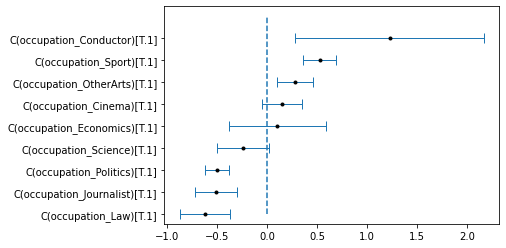

In [58]:
# With Vader
regression_binary('VaderSentiment', 'occupation')


 Linear regression:FlairSentiment ~ C(party)

Optimization terminated successfully.
         Current function value: 0.631715
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:         FlairSentiment   No. Observations:                 1651
Model:                          Logit   Df Residuals:                     1649
Method:                           MLE   Df Model:                            1
Date:                Thu, 16 Dec 2021   Pseudo R-squ.:               0.0005891
Time:                        20:42:41   Log-Likelihood:                -1043.0
converged:                       True   LL-Null:                       -1043.6
Covariance Type:            nonrobust   LLR p-value:                    0.2675
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.6646      0.073     -9.101   

,0,1
Intercept,-0.807701,-0.521446
C(party)[T.1.0],-0.322221,0.089425



 Coefficients:


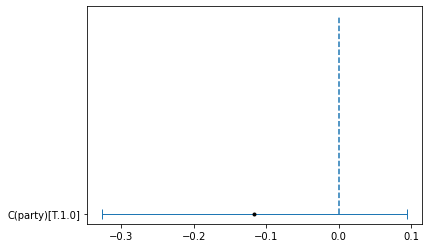

In [59]:
# With Flair
regression_binary('FlairSentiment', 'party')


 Linear regression:VaderSentiment ~ C(party)

Optimization terminated successfully.
         Current function value: 0.643256
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:         VaderSentiment   No. Observations:                 1651
Model:                          Logit   Df Residuals:                     1649
Method:                           MLE   Df Model:                            1
Date:                Thu, 16 Dec 2021   Pseudo R-squ.:               4.237e-05
Time:                        20:42:41   Log-Likelihood:                -1062.0
converged:                       True   LL-Null:                       -1062.1
Covariance Type:            nonrobust   LLR p-value:                    0.7642
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.6327      0.073      8.708   

,0,1
Intercept,0.490323,0.775153
C(party)[T.1.0],-0.172097,0.234303



 Coefficients:


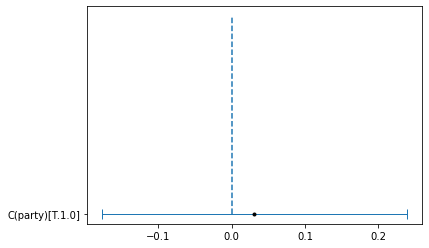

In [60]:
# With Vader
regression_binary('VaderSentiment', 'party')

The values of the coefficients vary with respect to the previous logistic regression but the conclusions are approximately the same. We also note the low R squares and the relatively large p-values.  
The comparison between Flair and Vader shows that the conclusions are the same when comparing the labels. Furthermore, the values of the coefficients are close (except for nationality).

### Question 3: In which newspapers are Trump's quotations published? Is there a link between the newspapers that published the most quotations of Trump and the political affiliation of these newspapers?    <a class="anchor" id="III.3"></a>

First, we compute the `VaderCompound` for quotations from Trump. Then, we compute the set of all publishers by extracting the domain name from the `urls` field of the quotations about and from Trump. We then construct new dataframe, `publisher_from_df` and `publisher_about_df` which contain the number of quotations for each publisher, the `VaderCompound` scores and the associated means and confidence intervals.

In [4]:
# load preprocessed data
preprocessed_df = pd.read_pickle('data/PreProcessData.pkl')
preprocessed_df.drop(['level_0', 'index'], axis=1, inplace=True)

In [5]:
# select quotes from trump
Trump_from = preprocessed_df[preprocessed_df.speaker.str.lower().str.contains("trump")]
Trump_from.reset_index(drop=True, inplace=True)

In [6]:
# Analyser
analyzer = SentimentIntensityAnalyzer()
# Vader sentiment analysis
Trump_from.loc[:, 'Vader'] = Trump_from.quotation.apply(lambda x: analyzer.polarity_scores(x)

In [7]:
# Adding Vader sentiment analysis in a new dataframe
Trump_from_sentiment = Trump_from
# Column with Vader compound
Trump_from_sentiment.loc[:,'VaderCompound']  = Trump_from_sentiment.Vader.apply(lambda x: x['compound'])
# Column with final Vader sentiment
Trump_from_sentiment.loc[:,'VaderSentiment'] = Trump_from_sentiment.VaderCompound.apply(lambda x: 'POSITIVE' if x >=0 else 'NEGATIVE')

In [8]:
# write to disk
Trump_from_sentiment.to_pickle("data/Trump_from_sentiment.pkl")

In [9]:
# To load the pickle file into pandas DataFrame
Trump_about_sentiment = pd.read_pickle("data/Trump_about_sentiment.pkl")
Trump_from_sentiment = pd.read_pickle("data/Trump_from_sentiment.pkl")

In [11]:
# bootstrap function
def bootstrap_CI(data, nbr_draws):
    means = np.zeros(nbr_draws)
    data = np.array(data)
    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        means[n] = np.nanmean(data_tmp)
    return [np.nanpercentile(means, 2.5),np.nanpercentile(means, 97.5)]
# function to extract domains
def get_domains(urls):
    domains = []
    for url in urls:
        domain = urlparse(url).hostname.replace('www.', '')
        domains.append(domain)
    return domains

In [12]:
# Get set of (unique) publishers for both dataframes
Trump_about_sentiment['domains'] = Trump_about_sentiment['urls'].apply(get_domains)
Trump_from_sentiment['domains'] = Trump_from_sentiment['urls'].apply(get_domains)
publishers_about = []
publishers_from = []
for pubs in Trump_about_sentiment['domains'].tolist():
    publishers_about.extend(pubs)
publishers_about = list(set(publishers_about))
for pubs in Trump_from_sentiment['domains'].tolist():
    publishers_from.extend(pubs)
publishers_from = list(set(publishers_from))
publisher_about_sets = [set([p]) for p in publishers_about]
publisher_from_sets = [set([p]) for p in publishers_from]

In [13]:
print(f'{len(publishers_about)} distinct publishers about Trump found.')
print(f'{len(publishers_from)} distinct publishers from Trump found.')

4813 distinct publishers about Trump found.
10573 distinct publishers from Trump found.


In [14]:
# Find indices of quotations matching a publisher
publisher_about_idx = [
    Trump_about_sentiment.domains.apply(pubset.issubset) for pubset in publisher_about_sets]
publisher_from_idx = [
    Trump_from_sentiment.domains.apply(pubset.issubset) for pubset in publisher_from_sets]

In [15]:
# Build publisher dataframes
publisher_about_df = pd.DataFrame({
    'publisher': publishers_about,
    'num_quotations': [pubidx.sum() for pubidx in publisher_about_idx],
    'VaderCompound': [
        Trump_about_sentiment[pubidx].VaderCompound.values for pubidx in publisher_about_idx],
}).sort_values(by=['num_quotations'], ascending=False)
publisher_from_df = pd.DataFrame({
    'publisher': publishers_from,
    'num_quotations': [pubidx.sum() for pubidx in publisher_from_idx],
    'VaderCompound': [
        Trump_from_sentiment[pubidx].VaderCompound.values for pubidx in publisher_from_idx],
}).sort_values(by=['num_quotations'], ascending=False)

In [16]:
# Compute average and confidence intervals
# about
publisher_about_df['average_VaderCompound'] = publisher_about_df.VaderCompound.apply(lambda x: x.mean())
CI_about = publisher_about_df.VaderCompound.apply(lambda x: bootstrap_CI(x, 1000))
upper_CI_about = CI_about.apply(lambda x: x[1])
lower_CI_about = CI_about.apply(lambda x: x[0])
publisher_about_df['lower_err_VaderCompound'] = upper_CI_about
publisher_about_df['upper_err_VaderCompound'] = lower_CI_about
# from
publisher_from_df['average_VaderCompound'] = publisher_from_df.VaderCompound.apply(lambda x: x.mean())
CI_from = publisher_from_df.VaderCompound.apply(lambda x: bootstrap_CI(x, 1000))
upper_CI_from = CI_from.apply(lambda x: x[1])
lower_CI_from = CI_from.apply(lambda x: x[0])
publisher_from_df['lower_err_VaderCompound'] = upper_CI_from
publisher_from_df['upper_err_VaderCompound'] = lower_CI_from

In [17]:
# write to disk
publisher_about_df.to_pickle("data/publisher_about_df.pkl")
publisher_from_df.to_pickle("data/publisher_from_df.pkl")

In [18]:
# read from disk
publisher_about_df = pd.read_pickle("data/publisher_about_df.pkl")
publisher_from_df = pd.read_pickle("data/publisher_from_df.pkl")

In [19]:
publisher_about_df.head(3)

,publisher,num_quotations,VaderCompound,average_VaderCompound,lower_err_VaderCompound,upper_err_VaderCompound
1085,breitbart.com,201,"[-0.4588, 0.34, -0.9818, -0.9788, 0.4939, -0.9...",0.020253,0.097387,-0.064663
3427,msn.com,185,"[0.6124, 0.7184, 0.9538, -0.7178, -0.8402, 0.1...",0.148655,0.220558,0.069749
2673,washingtontimes.com,99,"[0.1531, 0.7902, -0.8402, 0.4588, 0.9136, 0.41...",0.085853,0.182011,-0.016822


In [20]:
publisher_from_df.head(3)

,publisher,num_quotations,VaderCompound,average_VaderCompound,lower_err_VaderCompound,upper_err_VaderCompound
3290,breitbart.com,43693,"[-0.6486, -0.1761, -0.0772, 0.1901, 0.4404, 0....",0.075750,0.080262,0.070962
9824,msn.com,41029,"[0.8752, -0.1761, -0.0772, -0.4939, 0.0, 0.493...",0.058239,0.063193,0.053643
6166,thehill.com,23069,"[0.0, 0.1901, 0.6249, -0.4019, 0.0, 0.0772, 0....",0.068189,0.074390,0.061839


### 3.1) In which newspaper are Trump's quotations published ? <a class="anchor" id="III.3.1"></a>

There are 4813 distinct publishers for quotation about Trump and 10573 for quotations from Trump. To get an idea of these publishers, we plot the histogram of the number of quotations.

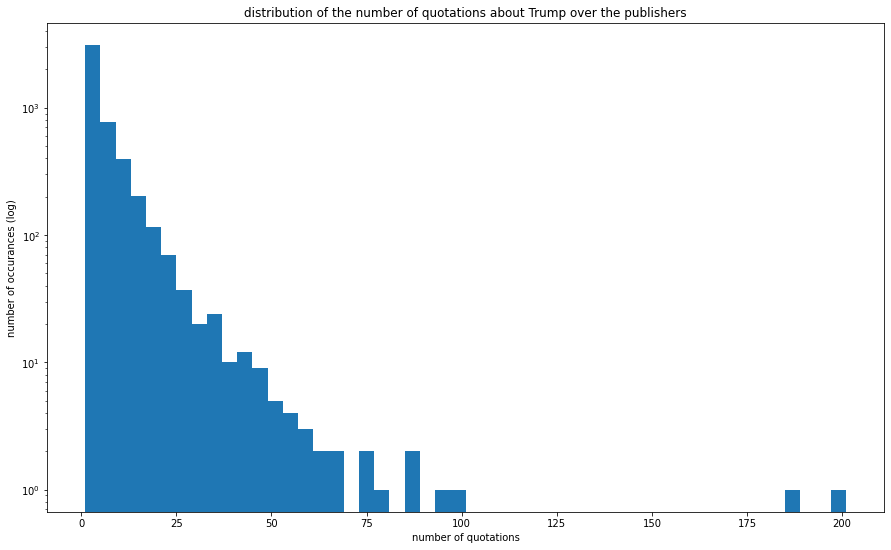

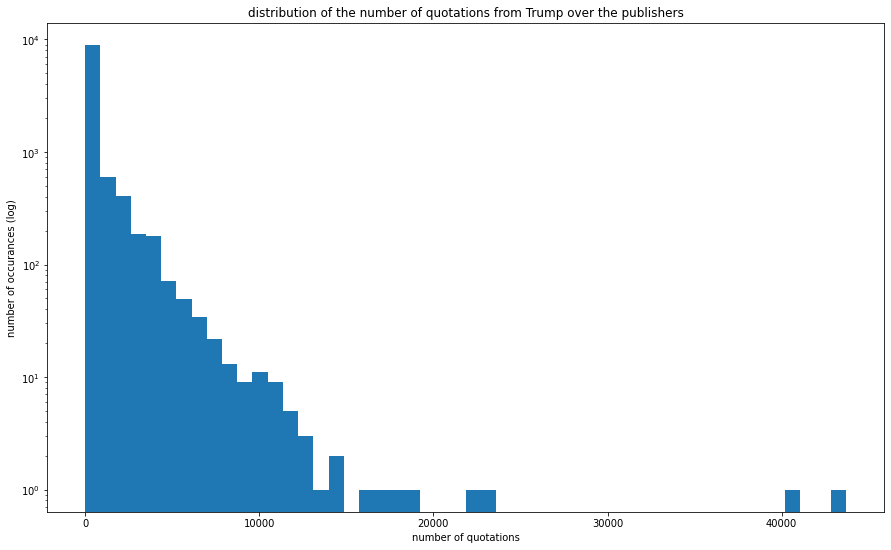

In [23]:
# plot
figure(figsize=(15, 9))
plt.hist(publisher_about_df.num_quotations, log=True, bins=50)
plt.xlabel('number of quotations')
plt.ylabel('number of occurances (log)')
plt.title('distribution of the number of quotations about Trump over the publishers')
plt.show()
figure(figsize=(15, 9))
plt.hist(publisher_from_df.num_quotations, log=True, bins=50)
plt.xlabel('number of quotations')
plt.ylabel('number of occurances (log)')
plt.title('distribution of the number of quotations from Trump over the publishers')
plt.show()

We observe that the distributions are even more skew than a heavy-tail distribution. This means that there are many publishers with few quotations and a few publishers with many quotations. Let's list the 10 most important publishers in terms of number of quotations.

In [24]:
# select
k = 10
top_k_publishers_about = publisher_about_df[:k].reset_index(drop=True)
top_k_publishers_from = publisher_from_df[:k].reset_index(drop=True)

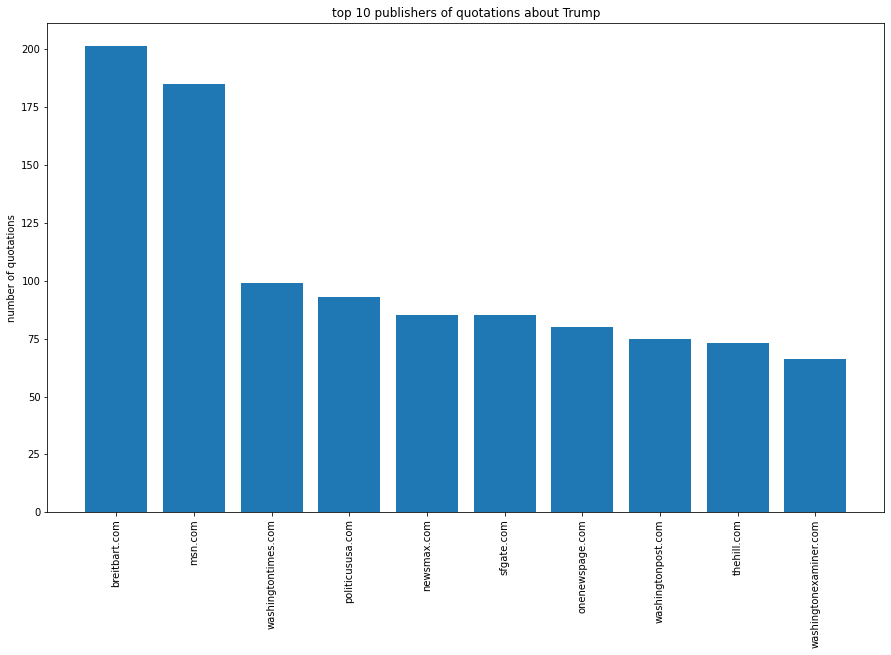

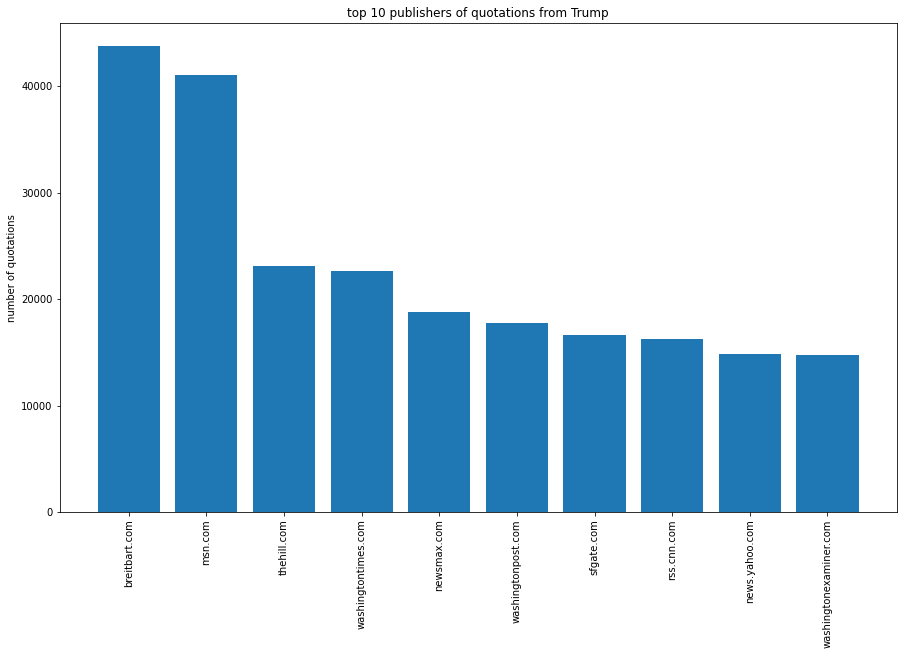

In [25]:
# plot
ticks = np.arange(k)
figure(figsize=(15, 9))
plt.bar(ticks, top_k_publishers_about.num_quotations)
plt.xticks(ticks, top_k_publishers_about.publisher.tolist(), rotation=90)
plt.ylabel('number of quotations')
plt.title(f'top {k} publishers of quotations about Trump')
plt.show()
figure(figsize=(15, 9))
plt.bar(ticks, top_k_publishers_from.num_quotations)
plt.xticks(ticks, top_k_publishers_from.publisher.tolist(), rotation=90)
plt.ylabel('number of quotations')
plt.title(f'top {k} publishers of quotations from Trump')
plt.show()

In [26]:
print('about:\n',top_k_publishers_about[['publisher', 'num_quotations']])
print('from:\n',top_k_publishers_from[['publisher', 'num_quotations']])

about:
                 publisher  num_quotations
0           breitbart.com             201
1                 msn.com             185
2     washingtontimes.com              99
3        politicususa.com              93
4             newsmax.com              85
5              sfgate.com              85
6         onenewspage.com              80
7      washingtonpost.com              75
8             thehill.com              73
9  washingtonexaminer.com              66
from:
                 publisher  num_quotations
0           breitbart.com           43693
1                 msn.com           41029
2             thehill.com           23069
3     washingtontimes.com           22685
4             newsmax.com           18835
5      washingtonpost.com           17724
6              sfgate.com           16615
7             rss.cnn.com           16283
8          news.yahoo.com           14826
9  washingtonexaminer.com           14802


Let's look at these publishers:
- **breitbart** is an American **far-right** syndicated news, opinion and commentary website. <a href='https://en.wikipedia.org/wiki/Breitbart_News'>(Wikipedia)</a>
- **msn.com** is a web portal and related collection of internet services and apps owned by Microsoft. <a href='https://en.wikipedia.org/wiki/MSN'>(Wikipedia)</a> It features news headlines and articles chosen by the editors.
- **The Washington Times** is an American **conservative** daily newspaper published in Washington, D.C. <a href='https://en.wikipedia.org/wiki/The_Washington_Times'>(Wikipedia)</a>
- **politicucusa.com** describes itself as a provider of news, commentary and opinion from a **liberal** point of view independently from any political affiliation. <a href='https://www.politicususa.com/about-us'>(website)</a>
- **SFGate** is **left-center** news website, created by the San Franscisco Chronicle in 1994. They are now two separated entites. <a href='https://en.wikipedia.org/wiki/San_Francisco_Chronicle'>(Wikipedia)</a>
- **newsmax** is a **conservative** American news and opinion website founded by Christopher Ruddy on September 16, 1998, and operated by Newsmax Media. <a href='https://en.wikipedia.org/wiki/Newsmax'>(Wikipedia)</a>
- **onenewspage** describes itself as providing of a one-stop view of breaking news, video coverage by reputable broadcast outlets, a powerful search engine and the ability to view related news headlines and news videos on the same page. <a href='https://www.onenewspage.com/aboutus.php'>(website)</a>
- **The Washington post** is a **liberal-leaning** daily American newspaper published in Washington, D.C. <a href='https://en.wikipedia.org/wiki/The_Washington_Post'>(Wikipedia)</a>
- **The Hill** is a **nonpartisan** American media company based in Washington, D.C focusing on politics, policy, buisness and international relations. <a href='https://en.wikipedia.org/wiki/The_Hill_(newspaper)'>(Wikipedia)</a>
- **The Washington Examiner** is an American **conservative** news website and weekly magazine based in Washington, D.C. <a href='https://en.wikipedia.org/wiki/Washington_Examiner'>(Wikipedia)</a>
- **The New York Times** is a **left-center** an American daily newspaper published in New York. <a href='https://en.wikipedia.org/wiki/The_New_York_Times'>(Wikipedia)</a>
- **Cable News Network (CNN)** is a multinational news-based pay television channel headquartered in Atlanta, United States. It is politcally **left-leaning**. <a href='https://en.wikipedia.org/wiki/CNN'>(Wikipedia)</a>
- **Yahoo! News** is a **left-leaning** news website that originated as an internet-based news aggregator by Yahoo!. <a href='https://en.wikipedia.org/wiki/Yahoo!_News'>(Wikipedia)</a> 


In [27]:
# affiliation mapping (used later)
affiliation_dict = {
    'breitbart.com': 'conservative',
    'msn.com': 'non-affiliated',
    'washingtontimes.com': 'conservative',
    'politicususa.com': 'liberal',
    'newsmax.com': 'conservative',
    'sfgate.com': 'liberal',
    'onenewspage.com': 'non-affiliated',
    'washingtonpost.com': 'liberal',
    'thehill.com': 'non-affiliated',
    'washingtonexaminer.com': 'conservative',
    'rss.cnn.com': 'liberal',
    'news.yahoo.com': 'liberal'
}
# Count affiliations and print
liberal = 0
conservative = 0
na = 0
for val in affiliation_dict.values():
    if val == 'liberal': liberal += 1
    elif val == 'conservative': conservative += 1
    else: na += 1
print(f'top {k} from and about Trump contain:')
print(f'- {conservative} conservative publishers')
print(f'- {liberal} liberal publishers')
print(f'- {na} non-affliated publishers')

top 10 from and about Trump contain:
- 4 conservative publishers
- 5 liberal publishers
- 3 non-affliated publishers


In general, these publishers are mostly but not exclusively based in the United States and seems to be balanced in term of political stance. We note that the most important publisher is a far-right website. Additionally, Fox News, which is well known to be friendly with Donald Trump does not appear in the top 10.

### 3.2) Is there a link between the newspapers that published the most quotations of Trump and the political affiliation of these newspapers? <a class="anchor" id="III.3.1"></a>

In this section we investigate the relation between the number of quotations about Trump and the political affiliation of the newspapers.

We start this analysis by visualizing all the publishers on a scatter plot. The x-axis is the number of quotations and the y-axis the average `VaderCompound` score. In addition to the data points themselves, we also plot the mean VaderCompound (across all publihsers) to oberseve how the data is organized around it.

In [28]:
# Compute means across all publishers
mean_about = []
mean_from = []
_ = publisher_about_df.VaderCompound.apply(lambda x: mean_about.extend(list(x)))
_ = publisher_from_df.VaderCompound.apply(lambda x: mean_from.extend(list(x)))
mean_about = sum(mean_about)/len(mean_about)
mean_from = sum(mean_from)/len(mean_from)

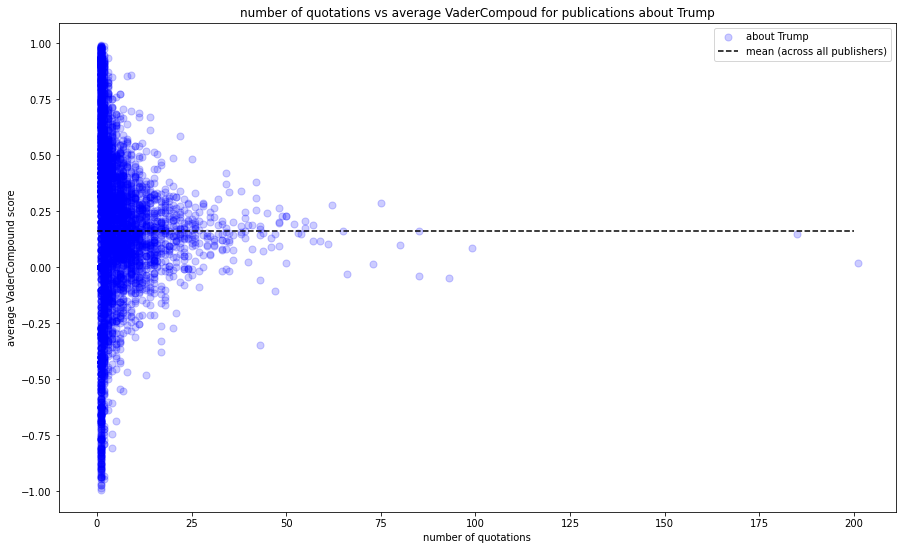

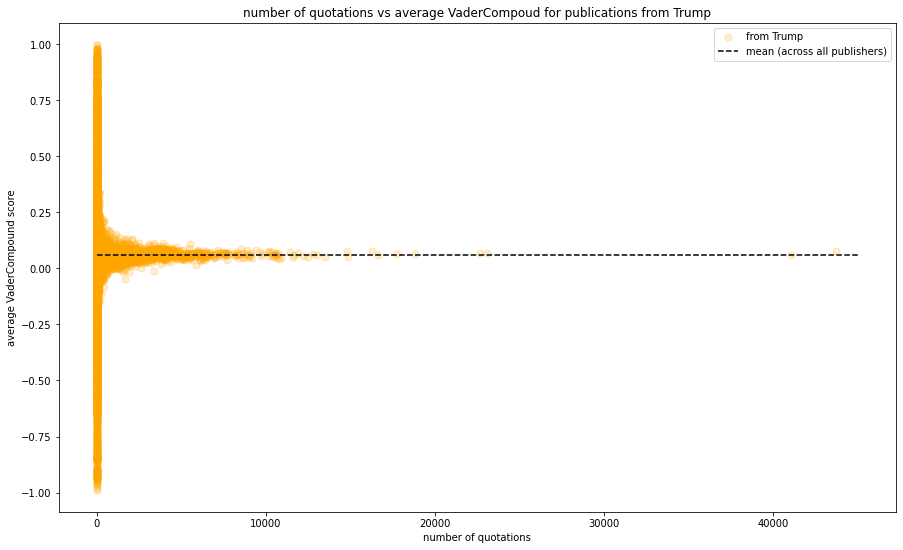

In [29]:
# plot
ax = publisher_about_df.plot.scatter(x='num_quotations', 
                                     y='average_VaderCompound',
                                     s=50,
                                     figsize=(15,9),
                                     c='b',
                                     alpha=0.2,
                                     label='about Trump')
ax.hlines(mean_about, 0, 200, label='mean (across all publishers)', color='k', 
          linestyles='dashed')
ax.set_xlabel('number of quotations')
ax.set_ylabel('average VaderCompound score')
ax.set_title('number of quotations vs average VaderCompoud for publications about Trump')
plt.legend()
plt.show()
ax=publisher_from_df.plot.scatter(x='num_quotations', 
                               y='average_VaderCompound',
                               s=50,
                               figsize=(15,9),
                               c='orange',
                               alpha=0.2,
                               label='from Trump')
ax.hlines(mean_from, 0, 45000, label='mean (across all publishers)', color='k', 
          linestyles='dashed')
ax.set_xlabel('number of quotations')
ax.set_ylabel('average VaderCompound score')
ax.set_title('number of quotations vs average VaderCompoud for publications from Trump')
plt.legend()
plt.show()

This plot shows that most publishers relay, on average, neutral quotations about Trump. We see that extreme opinions occur often for publishers with low number of quotations and become more and more rare the more quotations are published. This phenomenon could be explained by the fact that the less quotations, the less accurate the empirical mean. For publishers with very low quotation count, we may simply have a single extreme quotation which is not representative of the editorial line.

Next, we study the top-10 publishers again. We show below a bar plot of their average `VaderCompund` with error bars corresponding the bootstrapped confidence interval. Combining this information with the research done in point 3.1 about the publishers, we should get an idea of the type of quotations these publishers choose to relay. After that we can try to correlate this with their political affiliation. Additionally, we plot the conservatives, progressists and non-affiliated in different colors.

In [30]:
# affiliation and sort
top_k_publishers_about['affiliation'] = top_k_publishers_about['publisher'].apply(lambda x: affiliation_dict[x])
top_k_publishers_from['affiliation'] = top_k_publishers_from['publisher'].apply(lambda x: affiliation_dict[x])
top_k_publishers_from.sort_values(by=['average_VaderCompound'], ascending=False, inplace=True)
top_k_publishers_about.sort_values(by=['average_VaderCompound'], ascending=False, inplace=True)

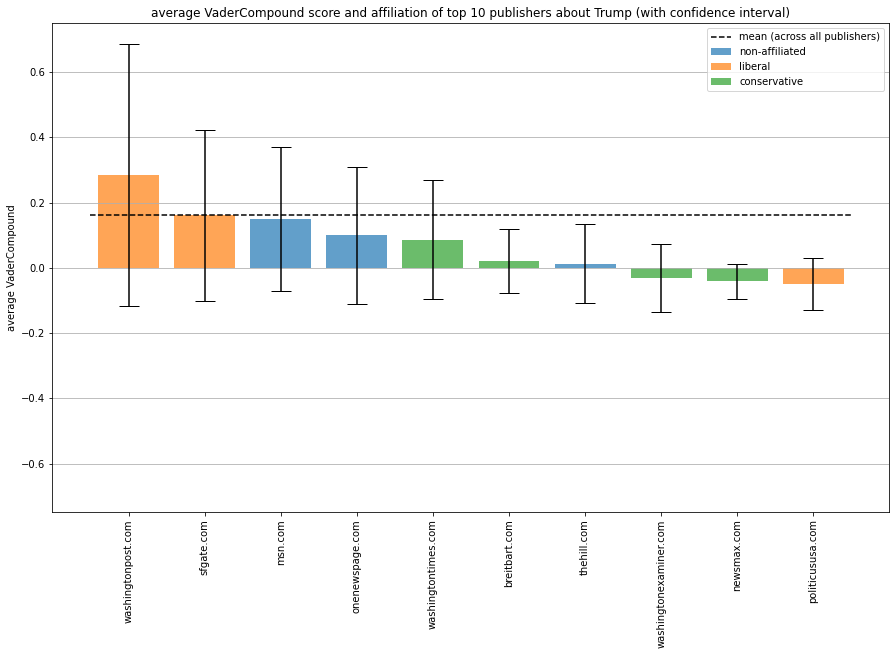

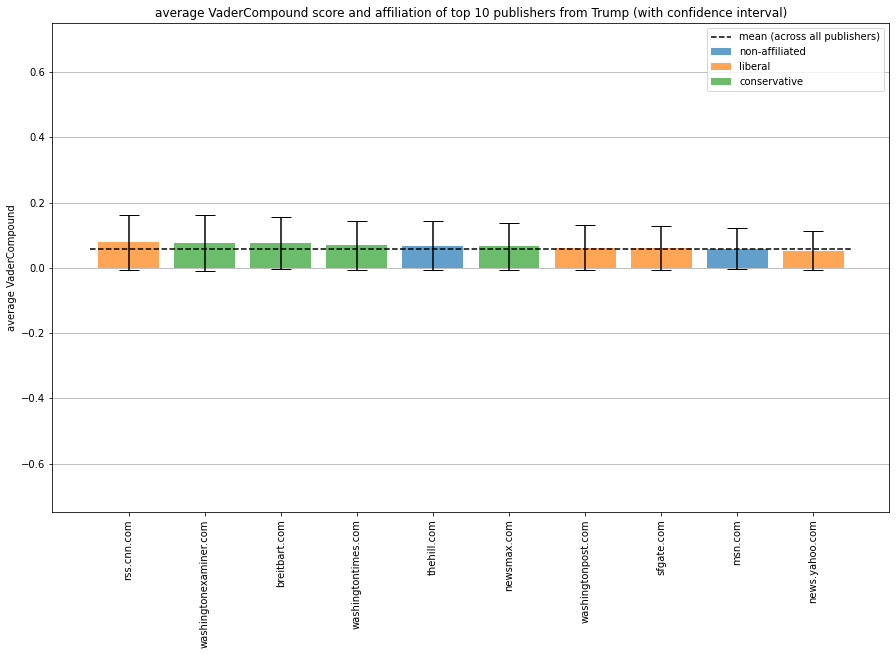

In [31]:
# plot
ticks = np.arange(k)
fig, ax = plt.subplots(figsize=(15, 9))
for aff in set(affiliation_dict.values()):
    idx = top_k_publishers_about.affiliation==aff
    tmp = top_k_publishers_about[idx]
    t = ticks[idx]
    errs = np.concatenate([tmp.lower_err_VaderCompound.values.reshape(-1,1), 
                       tmp.lower_err_VaderCompound.values.reshape(-1,1)], axis=1).T
    ax.bar(t, 
           tmp.average_VaderCompound,
           yerr=errs,
           label=aff,
           align='center', 
           alpha=0.7, 
           ecolor='black', 
           capsize=10)
ax.hlines(mean_about, -.5, k-.5, label='mean (across all publishers)', color='k', 
          linestyles='dashed')
ax.set_ylabel('average VaderCompound')
ax.set_title(f'average VaderCompound score and affiliation of top {k} publishers about Trump (with confidence interval)')
ax.set_xticks(ticks)
ax.set_xticklabels(top_k_publishers_about.publisher, rotation=90)
ax.set_ylim((-.75,.75))
ax.yaxis.grid(True)
plt.legend()
plt.show()

ticks = np.arange(k)
fig, ax = plt.subplots(figsize=(15, 9))
for aff in set(affiliation_dict.values()):
    idx = top_k_publishers_from.affiliation==aff
    tmp = top_k_publishers_from[idx]
    t = ticks[idx]
    errs = np.concatenate([tmp.lower_err_VaderCompound.values.reshape(-1,1), 
                       tmp.lower_err_VaderCompound.values.reshape(-1,1)], axis=1).T
    ax.bar(t, 
           tmp.average_VaderCompound,
           yerr=errs,
           label=aff,
           align='center', 
           alpha=0.7, 
           ecolor='black', 
           capsize=10)
ax.hlines(mean_from, -.5, k-.5, label='mean (across all publishers)', color='k', 
          linestyles='dashed')
ax.set_ylabel('average VaderCompound')
ax.set_title(f'average VaderCompound score and affiliation of top {k} publishers from Trump (with confidence interval)')
ax.set_xticks(ticks)
ax.set_xticklabels(top_k_publishers_from.publisher, rotation=90)
ax.set_ylim((-.75,.75))
ax.yaxis.grid(True)
plt.legend()
plt.show()

The results are quite counter-intuitive. For quotations about Trump, the highest average scores are produced by the more liberal publishers. And the far-right publisher, breitbart, does not even achieve a particularly high score. However, when considering the confidence intervals, these consideration should be taken carefully as the ranking could completly change. For the quotations from Trump, the highest ranked media outlet is considered liberal but is followed by most of the conservative ones, which would be expected. We also observe that most publishers seem to converge to an average score around 0.1. These considerations could be caused and influenced by multiple factors such as press self-censorship or respect towards the president, inaccurate sentiment analysis or lack of correlation between political affiliation and quotations about or from Trump. 

In general, it seems that there is no correlation between the political affiliation and the kind of quotes cited by a publisher. Even Fox News, which is known to be highly sympathetic towards Donald Trump has a very moderate score.

In [32]:
# fox news
fox_about = publisher_about_df[publisher_about_df.publisher=='foxnews.com'].average_VaderCompound.values[0]
fox_from = publisher_from_df[publisher_from_df.publisher=='foxnews.com'].average_VaderCompound.values[0]
print(f'Fox News average VaderCompound: {fox_about} (about), {fox_from} (from)')

Fox News average VaderCompound: 0.1481 (about), 0.04602290413533835 (from)


Finally, we validate these results using the sentiment analysis provided by flair on the publishers about Trump. To do so, we first compute the number of positive quotations for each publisher. Then, we normalize that number to get `average_Flair`, i.e `2*(num_positive/num_quotations)-1`. `average_Flair=-1` means that all the quotations are negative and `average_Flair=1` means that they are all positive. This will allow us to repeat the analysis above analogously.

In [34]:
# build dataframe
publisher_flair_about_df = pd.DataFrame({
    'publisher': publishers_about,
    'num_quotations': [pubidx.sum() for pubidx in publisher_about_idx],
    'FlairSentiment': [Trump_about_sentiment[pubidx].FlairSentiment.values for pubidx in publisher_about_idx],
}).sort_values(by=['num_quotations'], ascending=False)

In [35]:
# Turn POSITIVE and NEGATIVE to 1 and 0 respectively
publisher_flair_about_df.FlairSentiment = publisher_flair_about_df.FlairSentiment.apply(
    lambda x: [1 if xx=='POSITIVE' else 0 for xx in x]
)

In [36]:
# Compute num_positive and average_Flair
publisher_flair_about_df['num_positive'] = publisher_flair_about_df.FlairSentiment.apply(
    lambda x: sum(x)
)
publisher_flair_about_df['average_Flair'] = 2*(publisher_flair_about_df['num_positive']/publisher_flair_about_df['num_quotations'])-1

In [37]:
publisher_flair_about_df.to_pickle("data/publisher_flair_about_df.pkl")

In [38]:
publisher_flair_about_df = pd.read_pickle("data/publisher_flair_about_df.pkl")

In [39]:
# Compute mean Flair score across all publishers
mean_flair = 2*(publisher_flair_about_df.num_positive.sum()/publisher_flair_about_df.num_quotations.sum())-1

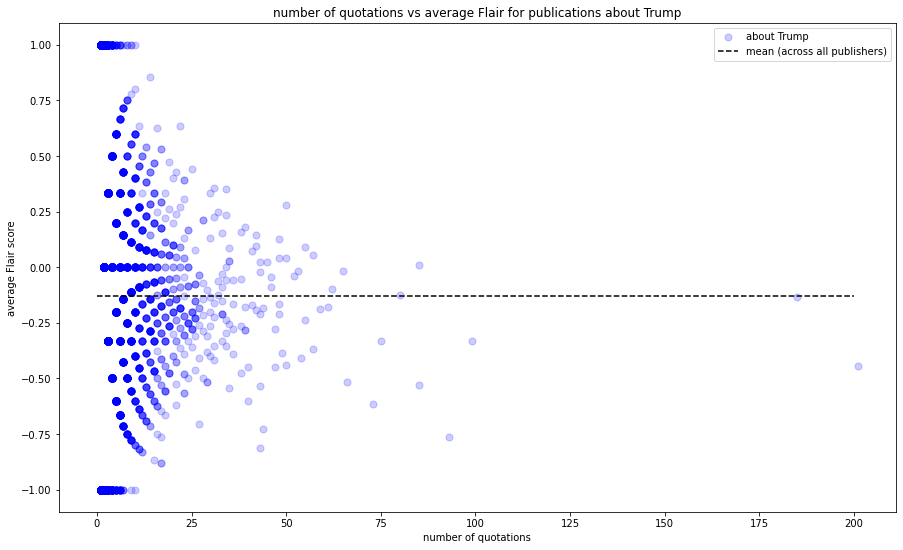

In [40]:
# plot
ax = publisher_flair_about_df.plot.scatter(x='num_quotations', 
                                     y='average_Flair',
                                     s=50,
                                     figsize=(15,9),
                                     c='b',
                                     alpha=0.2,
                                     label='about Trump')
ax.hlines(mean_flair, 0, 200, label='mean (across all publishers)', color='k', 
          linestyles='dashed')
ax.set_xlabel('number of quotations')
ax.set_ylabel('average Flair score')
ax.set_title('number of quotations vs average Flair for publications about Trump')
plt.legend()
plt.show()

The pattern observed with Vader seems to still be present, though less clear. The variance of the average Flair score is high for low number of quotations, as expected, and decreases as the number of quotations increases. However, the rate at which the variance decreases is much slower than with Vader and the value of convergence is therefore less well defined. This could be explained by the fact that we used the `POSITVE` and `NEGATIVE` labels produced by Flair to artificially create a score while Vader already produced a score. These two metrics, though comparable, are not strictly equivalent.

Finally, we plot the scores for the top k publishers about Trump. This time, no confidence intervals are available therefore the results should be taken with a grain of salt.

In [42]:
# select
k = 10
top_k_publishers_flair_about = publisher_flair_about_df[:k].reset_index(drop=True)

In [43]:
# affiliation and sort
top_k_publishers_flair_about['affiliation'] = top_k_publishers_flair_about['publisher'].apply(lambda x: affiliation_dict[x])
top_k_publishers_flair_about.sort_values(by=['average_Flair'], ascending=False, inplace=True)

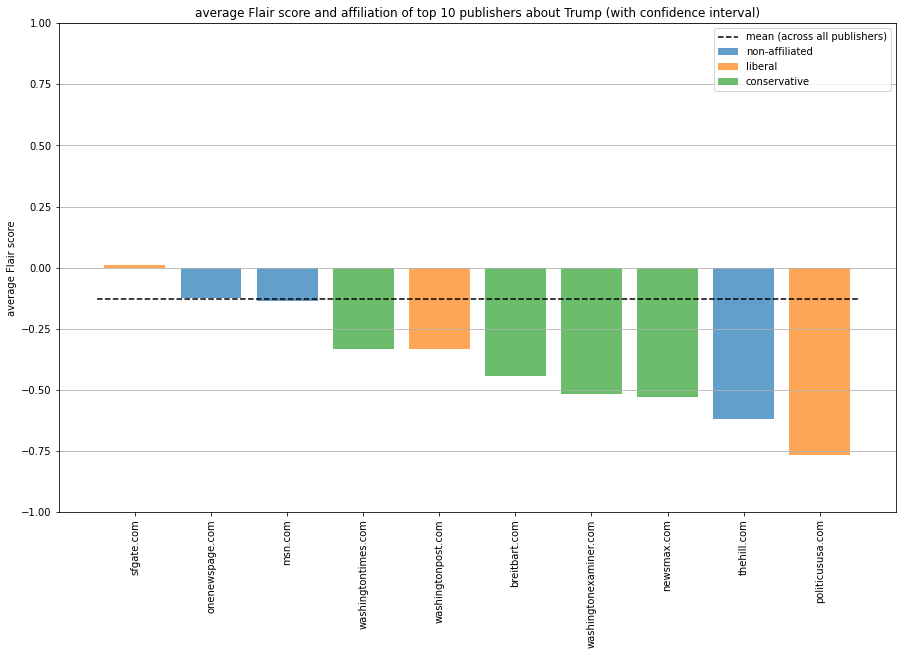

In [44]:
# plot
ticks = np.arange(k)
fig, ax = plt.subplots(figsize=(15, 9))
for aff in set(affiliation_dict.values()):
    idx = top_k_publishers_flair_about.affiliation==aff
    tmp = top_k_publishers_flair_about[idx]
    t = ticks[idx]
    ax.bar(t, 
           tmp.average_Flair,
           label=aff,
           align='center', 
           alpha=0.7, 
           ecolor='black', 
           capsize=10)
ax.hlines(mean_flair, -.5, k-.5, label='mean (across all publishers)', color='k', 
          linestyles='dashed')
ax.set_ylabel('average Flair score')
ax.set_title(f'average Flair score and affiliation of top {k} publishers about Trump (with confidence interval)')
ax.set_xticks(ticks)
ax.set_xticklabels(top_k_publishers_flair_about.publisher, rotation=90)
ax.set_ylim((-1., 1.))
ax.yaxis.grid(True)
plt.legend()
plt.show()

Again, the results do not seem to indicate a correlation between political affiliation and the quotations about Trump published. The highest score is acheieved by a liberal publisher and all conservative ones have negative scores. Note that as mentioned above, no confidence interval can be computed therefore, this ranking may not reflect reality. In any case, the results seem to follow the same trend as what we observed with Vader.

In conclusion, the analysis proposed above seems to indicate that the quotes about and from Trump published by a media is not representative of its political affiliation. As mentionned before, this could be due to respect towards the president or self censorship. Additionally, the sentiment analysis is probably not perfect, resulting in noisy labels for which the uncertainty is difficult to characterize. Finally, we should point out that this conclusion is not really surprising as the sentiment of the quotations about a famous man, but still only a single man, is a weak signal. Characterizing the affiliation of a publisher based on this estimator sounds like a shortcut and our analysis shows that it is indeed one.

## Appendix

In [ ]:
from octis.models.LDA import LDA
from octis.dataset.dataset import Dataset
from octis.evaluation_metrics.coherence_metrics import Coherence
from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from octis.optimization.optimizer import Optimizer
from skopt.space.space import Real, Categorical, Integer

In [ ]:
def get_words_and_weights(lda, feature_names, n_top):
    '''get_words_and_weights: retrieve topic words and their weights for each topic'''
    topic_ids = []
    topic_words = []
    words_weights = []
    for topic_id, topic in enumerate(lda.components_):
        top_features_ind = topic.argsort()[: -n_top - 1 : -1]
        top_words = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        topic_ids.append(topic_id)
        topic_words.append(top_words)
        words_weights.append(weights)
    return topic_ids, topic_words, words_weights

def timechunk_lda(df, text_col, dt_col, chunksize, n_components, n_top=10, 
                  max_iter=15, random_state=2, max_df=0.95, min_df=1, 
                  max_features=1000):
    '''timechunk_lda: Aggregate quotes into date ranges of size chunksize and perform
                      latent dirichlet allocation to extract topic
    Inputs:
    -------
    - df: input dataframe
    - text_col: column containing text (either as strings or list of strings) in df
    - dt_col: column containing Timestamps in df
    - chunksize: size of chunks in days, e.g. '10D' == 10 days
    - n_components: number of different topics to model
    - n_top: number of top words to consider when summarizing a topic
    - max_iter: maximum number of iteration for online lda
    - random_state: lda random state
    - max_df: When building the vocabulary ignore terms that have a document frequency 
              strictly higher than the given threshold (corpus-specific stop words). 
              If float, the parameter represents a proportion of documents, integer 
              absolute counts. This parameter is ignored if vocabulary is not None.
    - min_df: When building the vocabulary ignore terms that have a document frequency 
              strictly lower than the given threshold. This value is also called cut-off 
              in the literature. If float, the parameter represents a proportion of 
              documents, integer absolute counts. This parameter is ignored if vocabulary 
              is not None.
    - max_features: vocabulary size
    
    Outputs:
    --------
    - df: input df with two additional columns, `topic_id_{chunksize}` the assigned topic
          and `topics_dist_{chunksize}` the topic assignment distribution.
    - topics_df: topics dataframe, contains topic_id, words and normalized word weight
                 for each topic.
    - timechunks_df: timechunks dataframe, contains start date (included) and end date 
                     (excluded) of each chunk.'''
    # Transform text column to string if passed as list of strings
    created_text_col = False
    if type(df[text_col].to_list()[0]) == list:
        df['str_text_col'] = df[text_col].apply(lambda x: ' '.join(x))
        text_col = 'str_text_col'
        created_text_col = True
    # Create vectorizer and lda objects
    vectorizer = CountVectorizer(max_df=max_df, min_df=min_df, 
                                 max_features=max_features, 
                                 stop_words="english")
    lda = LatentDirichletAllocation(n_components=n_components,
                                    max_iter=max_iter,
                                    learning_method="online",
                                    random_state=random_state)
    # Aggregate documents according to passed chunksize
    documents = []
    documents_lengths = []
    timechunks = make_timechunks(chunksize, df[dt_col].min(), df[dt_col].max())
    for chunk in timechunks:
        document_list = df[
            df[dt_col].between(chunk[0], chunk[1], inclusive='left')
        ][text_col].to_list()
        documents.append(' '.join(document_list))
        documents_lengths.append(len(document_list))
    # Vectorize data
    tokens = vectorizer.fit_transform(documents)
    # Compute topic distribution for each document and assigned topic (argmax)
    assigned_topics = lda.fit_transform(tokens)
    topics_dist_column = []
    topics_column = []
    total_length = 0
    for document_length, assigned_topic in zip(documents_lengths, assigned_topics):
        total_length += document_length
        topics_dist_column.extend(document_length*[list(assigned_topic)])
        topics_column.extend(document_length*[assigned_topic.argmax()])
    # Add to dataframe
    df[f'topic_id_{chunksize}'] = topics_column
    df[f'topics_dist_{chunksize}'] = topics_dist_column
    # Retrieve topic words and associated words
    topic_ids, topic_words, words_weights = get_words_and_weights(
        lda, vectorizer.get_feature_names(), n_top
    )
    # Create topic dataframe with topic_id, chunksize, [word, normalized_weight]
    # normalized weight computed with normalized exponential (softmax) of word weight
    # for each topic
    colnames = ['topic_id', 'chunksize']
    for i in range(1, n_top+1):
        colnames.append(f'topic_word_{i}')
        colnames.append(f'normalized_weight_{i}')
    topics_df = pd.DataFrame(columns=colnames)
    for topic_id, words, weights in zip(topic_ids, topic_words, words_weights):
        tmp = [topic_id, chunksize]
        denom = np.exp(np.array(weights)).sum()
        for word, weight in zip(words, weights):
            normalized_weight = np.exp(weight)/denom
            tmp.extend([word, normalized_weight])
        topics_df.loc[len(topics_df.index)] = tmp
    # Make timechunks_df
    timechunks_df = pd.DataFrame(columns=['start_date', 'end_date'])
    timechunks_df['start_date'] = [chunk[0] for chunk in timechunks]
    timechunks_df['end_date'] = [chunk[1] for chunk in timechunks]
    # Delete additional text column if added
    if created_text_col:
        df.drop(columns=['str_text_col'], inplace=True)
    return df, topics_df, timechunks_df

In [ ]:
from octis.evaluation_metrics.metrics import AbstractMetric

class CoherenceTimesDiversity(AbstractMetric):
    def __init__(self, texts):
        super().__init__()
        self._texts = texts
        
    def score(self, model_output):
        cv = Coherence(texts=self._texts, measure='c_v')
        td = TopicDiversity()
        return cv.score(model_output) * td.score(model_output)

In [ ]:
def flatten(nested):
    """Flatten nested list.

    Parameters
    ----------
    nested : list
        Nested list to flatten

    Returns
    -------
    list
        Flattened list
    """
    return [inner for outer in nested for inner in outer]

In [ ]:
import csv

with open('data/octis_data/corpus.tsv', 'wt') as out_file:
    tsv_writer = csv.writer(out_file, delimiter='\t')
    for d in documents:
        tsv_writer.writerow([d])
        
with open('data/octis_data/vocabulary.txt', 'w') as out_file:
    for d in list(set(flatten([d.split() for d in documents]))):
        out_file.write(d)
        out_file.write("\n")

In [ ]:
dataset = Dataset()
dataset.load_custom_dataset_from_folder("data/octis_data")b

In [ ]:
metric = CoherenceTimesDiversity(texts=dataset.get_corpus())

In [ ]:
NUM_TOPICS = 10
model = LDA(num_topics=NUM_TOPICS, passes=40, iterations=200, chunksize = 400)
output = model.train_model(dataset)
for t in output['topics']:
    print(" ".join(t))

In [ ]:
metric.score(output)

In [ ]:
scores_num_topics = []

with open('lda_scores_num_topics.txt', 'w') as out_file:
    for n in range(2, 51, 2):
        model = LDA(num_topics=n, passes=40, iterations=200, chunksize = 400)
        output = model.train_model(dataset)
        score = metric.score(output)
        scores_num_topics.append(score)
        out_file.write(f"{n} topics -> score={score}\n")
        print(f"{n} topics -> score={score}")

In [ ]:
with open('lda_scores_alpha.txt', 'w') as out_file:
    for a in ['symmetric', 'asymmetric', 'auto'] + [10**k for k in range(-5, 3)]:
        model = LDA(num_topics=10, alpha=a, passes=40, iterations=200, chunksize = 400)
        output = model.train_model(dataset)
        score = metric.score(output)
        out_file.write(f"alpha={a} -> score={score}\n")
        print(f"alpha={a} -> score={score}\n")

In [ ]:
model = LDA(passes=40, iterations=200, chunksize = 400)
search_space = {"alpha": Real(1e-5, 1e3),
                "eta": Real(1e-2, 1e4),
                "num_topics": Integer(2, 30)}
optimization_runs=45
model_runs=5
optimizer=Optimizer()
optimization_result = optimizer.optimize(
    model, dataset, metric, search_space, number_of_call=optimization_runs, 
    model_runs=model_runs, 
    extra_metrics=None)

In [ ]:
import json
res = json.load(open("results/result.json",'r'))
best_id = np.array(res["f_val"]).argmax()
best_alpha = res['x_iters']['alpha'][best_id]
best_eta = res['x_iters']['eta'][best_id]
best_num_topics = res['x_iters']['num_topics'][best_id]

In [ ]:
model = LDA(num_topics=best_num_topics, alpha=best_alpha, eta=best_eta, passes=40, iterations=200, chunksize = 400)
output = model.train_model(dataset)
for t in output['topics']:
    print(" ".join(t))

In [ ]:
metric.score(output)

Here are the 10 best topics obtained with LDA:

Iran Democrats Russia North_Korea government Congress protect help terrorist cut

Congress Obamacare Russia health government Texas Joe cost Democrats side

cure pathological belt child disease hit molester Starbucks knife book

Paris Israel terrorism peace Muslims terrorist Muslim faith agreement loser

Democrats Ukraine help impeachment India economy statement fight side virus

Russia Democrats North_Korea help meeting administration Iran government tariff relationship

Democrats meeting relationship tariff happy Russia crime North_Korea administration economy

debate Iraq called policy email system government child worst community

Democrats caravan agreement violence act Fed Saudi_Arabia nationalist citizen cut

regulation policy administration worker government help medium Russia cost given